#   Alberto Sartini's Master's Thesis - Stock Market Forecasting

# Packages Loading

In [69]:
#EDA Libraries
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from tabulate import tabulate


#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from pandas.plotting import register_matplotlib_converters

In [70]:
#Statistical Libraries
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from scipy.stats import kurtosis, skew
from scipy.stats import ttest_rel
import itertools

In [71]:
# Sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error , mean_absolute_percentage_error
# Parameter Grid
from sklearn.model_selection import ParameterGrid
# Random Forest
from sklearn.ensemble import RandomForestRegressor


In [72]:
#Reti Neurali

from tensorflow.python.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras import layers, models
import random
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [73]:
# High-frequency synthetic data
import time
from scipy.interpolate import interp1d
from arch import arch_model
import pandas_market_calendars as mcal

# Pre-Processing and EDA

In [74]:
# File reading
df=pd.read_excel('shiller_data.xlsx')

# Setting Date as Index
df.set_index('Date', inplace=True)
df.head()

S&P 500  Dividends  Earnings       CPI  10Y Usa Rate
Date                                                            
1900-01-31     6.10     0.2175      0.48  7.897091      3.150000
1900-02-28     6.21     0.2250      0.48  7.992232      3.145833
1900-03-31     6.26     0.2325      0.48  7.992232      3.141667
1900-04-30     6.34     0.2400      0.48  7.992232      3.137500
1900-05-31     6.04     0.2475      0.48  7.801942      3.133333

In [75]:
#Dropping Dividends e CPI columns
df=df.drop(['Dividends' ,'CPI'],axis=1)
df.dropna()

S&P 500    Earnings  10Y Usa Rate
Date                                             
1900-01-31     6.100000    0.480000      3.150000
1900-02-28     6.210000    0.480000      3.145833
1900-03-31     6.260000    0.480000      3.141667
1900-04-30     6.340000    0.480000      3.137500
1900-05-31     6.040000    0.480000      3.133333
...                 ...         ...           ...
2023-08-31  4457.358696  183.170000      4.170000
2023-09-30  4409.095000  184.250000      4.380000
2023-10-31  4269.400909  186.976667      4.800000
2023-11-30  4460.063333  189.703333      4.500000
2023-12-31  4685.051500  192.430000      4.020000

[1488 rows x 3 columns]

In [76]:
#Data selection (from 1945-01-31 onwards)
first_date = '1944-12-31'
df = df[df.index >= first_date]
df.head()

S&P 500  Earnings  10Y Usa Rate
Date                                       
1944-12-31    13.10  0.930000      2.379167
1945-01-31    13.49  0.940000      2.370000
1945-02-28    13.94  0.950000      2.355000
1945-03-31    13.93  0.960000      2.340000
1945-04-30    14.28  0.973333      2.325000

In [77]:
df.rename(columns={"S&P 500": "sp_500", "Earnings": "earnings","10Y Usa Rate": "10y_usa_rate"}, inplace=True)

In [78]:
df.isnull().any()

sp_500          False
earnings        False
10y_usa_rate    False
dtype: bool

In [79]:
df.describe()

sp_500    earnings  10y_usa_rate
count   949.000000  949.000000    949.000000
mean    734.392395   34.486238      5.237932
std    1029.413737   43.964910      2.916615
min      13.100000    0.840000      0.620000
25%      76.060000    4.470000      2.792500
50%     166.100000   14.810000      4.470000
75%    1171.580000   48.480000      7.140000
max    4685.051500  197.910000     15.320000

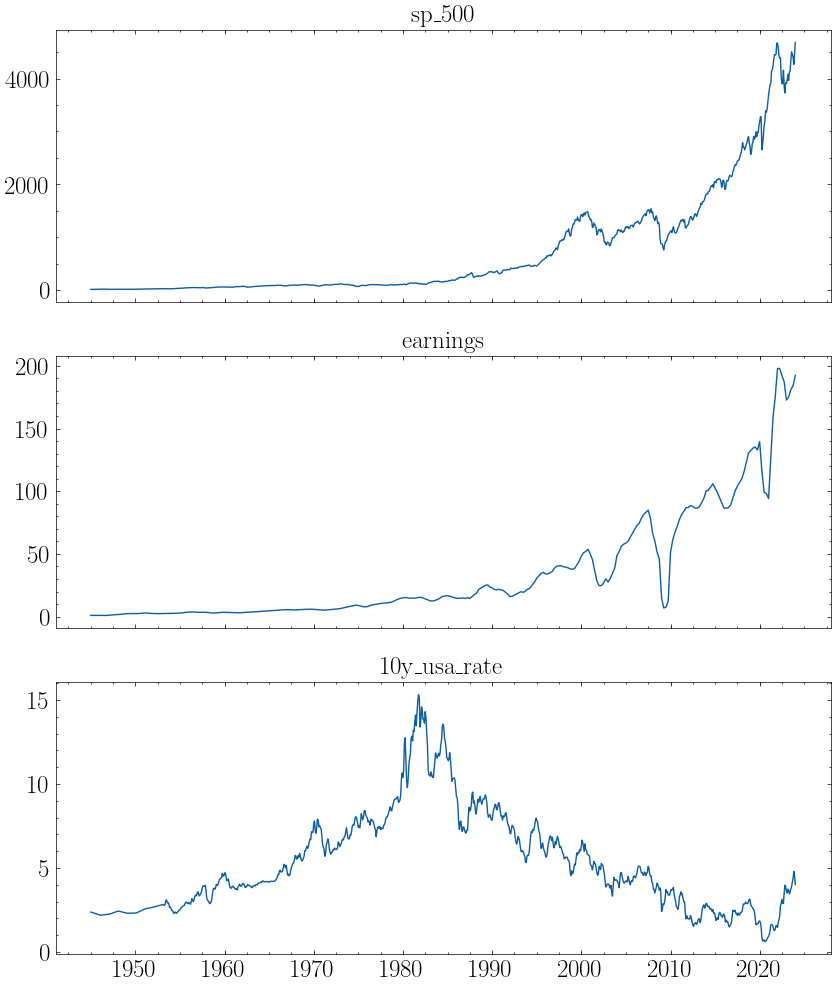

In [80]:
# Plot of the time series in nominal value
with plt.style.context('science'):
    num_vars = len(df.columns)
    fig, axes = plt.subplots(num_vars, 1, figsize=(10, 4 * num_vars), sharex=True)

    for i, col in enumerate(df.columns):
        axes[i].plot(df.index, df[col])
        
        # Imposta titolo e dimensione dei caratteri
        axes[i].set_title(df[col].name, fontsize=18)
        axes[i].tick_params(axis='both', labelsize=18)  # Dimensione dei caratteri degli assi
        axes[i].grid(False)
    #plt.savefig('grafici/serie_in_valore_nominale.svg', format='svg')
    plt.show()


In [81]:
# ADF test to check the stationarity of the time series in nominal value

for i, col in enumerate(df.columns):
    adf_result = adfuller(df[col])
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    used_lags = adf_result[2]
    nobs = adf_result[3]
    critical_values = adf_result[4]
    icbest = adf_result[5]
    
    
    print(f'Results of ADF Test on Residuals for {col}:')
    print(f'ADF Statistic for {col}: {adf_statistic}')
    print(f'p-value for {col} : {p_value}')
    print(f'Number of lags used for {col} : {used_lags}')
    print(f'Number of observations used for {col} : {nobs}')
    print('')
    
# All three series are found to be non-stationary

Results of ADF Test on Residuals for sp_500:
ADF Statistic for sp_500: 5.111592403782126
p-value for sp_500 : 1.0
Number of lags used for sp_500 : 22
Number of observations used for sp_500 : 926

Results of ADF Test on Residuals for earnings:
ADF Statistic for earnings: 2.5518282745567777
p-value for earnings : 0.9990646799171724
Number of lags used for earnings : 21
Number of observations used for earnings : 927

Results of ADF Test on Residuals for 10y_usa_rate:
ADF Statistic for 10y_usa_rate: -1.4773967075951528
p-value for 10y_usa_rate : 0.5446617666846315
Number of lags used for 10y_usa_rate : 22
Number of observations used for 10y_usa_rate : 926



In [82]:
# Transformation of the dataset into log-levels
df_log = np.log(df)
df_log.columns = ['l_' + col for col in df.columns]

In [83]:
df_log

l_sp_500  l_earnings  l_10y_usa_rate
Date                                            
1944-12-31  2.572612   -0.072571        0.866750
1945-01-31  2.601949   -0.061875        0.862890
1945-02-28  2.634762   -0.051293        0.856541
1945-03-31  2.634045   -0.040822        0.850151
1945-04-30  2.658860   -0.027029        0.843720
...              ...         ...             ...
2023-08-31  8.402312    5.210415        1.427916
2023-09-30  8.391425    5.216294        1.477049
2023-10-31  8.359229    5.230984        1.568616
2023-11-30  8.402918    5.245461        1.504077
2023-12-31  8.452132    5.259732        1.391282

[949 rows x 3 columns]

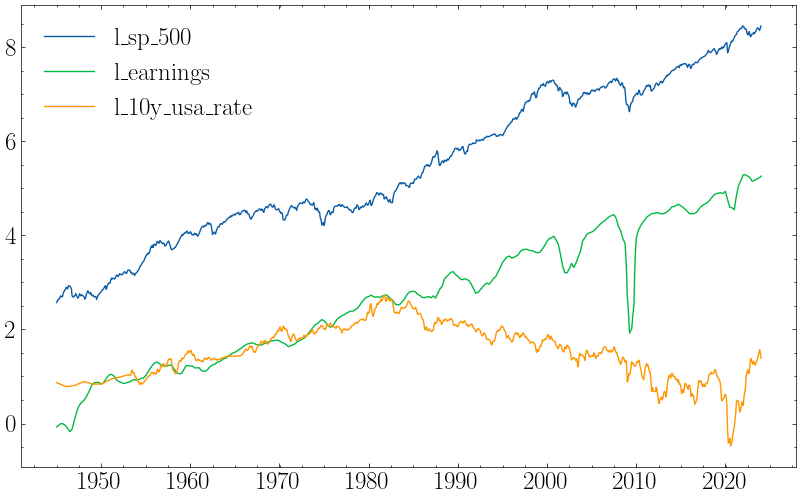

In [84]:
# Plot representing all three series in log-levels
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))

    for column in df_log.columns:
        plt.plot(df_log.index, df_log[column], label=column)

    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)  
    plt.grid(False)
    #plt.savefig('grafici/serie_in_log-livelli.svg', format='svg')
    plt.show()


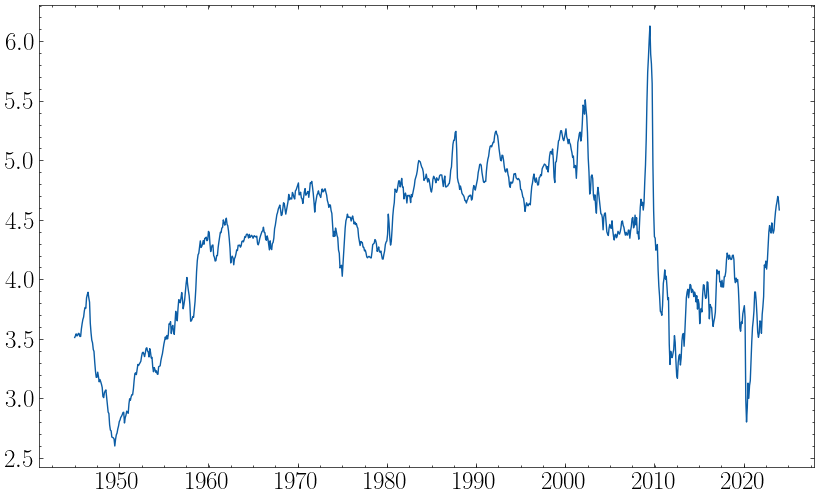

In [85]:
# Plot related to the Ziemba et al. indicator "I"

i_df = df_log['l_10y_usa_rate']-df_log['l_earnings']+df_log['l_sp_500']

with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    plt.plot(df_log.index,i_df, label='I')
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    #plt.savefig('grafici/logarithmic_indicator.svg', format='svg')

    plt.show()

In [86]:
i_df =i_df.to_frame(name='indicator')
i_df.head()

indicator
Date                 
1944-12-31   3.511933
1945-01-31   3.526714
1945-02-28   3.542596
1945-03-31   3.525018
1945-04-30   3.529609

In [87]:
# ADF test for "I"

adf_result = adfuller(i_df['indicator'])
adf_statistic = adf_result[0]
p_value = adf_result[1]
used_lags = adf_result[2]
nobs = adf_result[3]
critical_values = adf_result[4]
icbest = adf_result[5]

print(f'Results of ADF Test on Residuals for indicator:')
print(f'ADF Statistic for indicator: {adf_statistic}')
print(f'p-value for indicator: {p_value}')
print(f'Number of lags used for indicator: {used_lags}')
print(f'Number of observations used for indicator: {nobs}')


Results of ADF Test on Residuals for indicator:
ADF Statistic for indicator: -2.8605556826269845
p-value for indicator: 0.05013086484294637
Number of lags used for indicator: 3
Number of observations used for indicator: 945


# High frequency synthetic data 

In [88]:
def generate_high_freq_series(monthly_series, target_freq='D'):
    """
    monthly_series: pd.Series con frequenza mensile
    target_freq: frequenza desiderata ('D' per giornaliera)
    """
    # Step 1: Interpolazione temporale
    monthly_series = monthly_series.sort_index()
    high_freq_index = pd.date_range(start=monthly_series.index[0],
                                    end=monthly_series.index[-1],
                                    freq=target_freq)

    # Interpolazione lineare (puoi usare anche spline)
    interpolator = interp1d(monthly_series.index.astype(np.int64),
                            monthly_series.values,
                            kind='linear')
    
    interpolated_values = interpolator(high_freq_index.astype(np.int64))
    interpolated_series = pd.Series(interpolated_values, index=high_freq_index)
    
    #first_log_value = interpolated_series.iloc[0]

    # Step 2: Aggiunta rumore GARCH
    # Fitting GARCH(1,1) sul residuo mensile
    returns = monthly_series.diff().dropna()
    scale_factor = 1000
    returns_scaled = returns * scale_factor  # Scaling per GARCH
    # calcolo dei rendimenti
    am = arch_model(returns_scaled, vol='Garch', p=1, q=1)
    res = am.fit(disp='off')
    sim_vol = res.conditional_volatility.mean() / scale_factor  # livello medio di volatilità

    # Aggiunta di rumore casuale con varianza simile
    np.random.seed(42)
    noise = np.random.normal(scale=sim_vol, size=len(interpolated_series))
    synthetic_series = interpolated_series + noise

    return synthetic_series

In [89]:
df.head()

sp_500  earnings  10y_usa_rate
Date                                      
1944-12-31   13.10  0.930000      2.379167
1945-01-31   13.49  0.940000      2.370000
1945-02-28   13.94  0.950000      2.355000
1945-03-31   13.93  0.960000      2.340000
1945-04-30   14.28  0.973333      2.325000

In [90]:
high_freq_l_sp_500 = generate_high_freq_series(df_log['l_sp_500'] , target_freq='D')
print(high_freq_l_sp_500)

1944-12-31    2.590027
1945-01-01    2.568711
1945-01-02    2.597213
1945-01-03    2.628849
1945-01-04    2.568188
                ...   
2023-12-27    8.439792
2023-12-28    8.427502
2023-12-29    8.504730
2023-12-30    8.451836
2023-12-31    8.505113
Freq: D, Length: 28855, dtype: float64


In [91]:
print(high_freq_l_sp_500.isna().sum())  # Conta i NaN
print(np.isinf(high_freq_l_sp_500).sum())  # Conta gli infiniti


0
0


In [92]:
high_freq_l_sp_500.min()

2.517834383560317

In [93]:
high_freq_l_earnings = generate_high_freq_series(df_log['l_earnings'] , target_freq='D')
print(high_freq_l_earnings)

1944-12-31   -0.062368
1945-01-01   -0.075066
1945-01-02   -0.058576
1945-01-03   -0.040251
1945-01-04   -0.076000
                ...   
2023-12-27    5.254382
2023-12-28    5.246711
2023-12-29    5.291489
2023-12-30    5.260029
2023-12-31    5.290773
Freq: D, Length: 28855, dtype: float64


In [94]:
print(high_freq_l_earnings.isna().sum())  # Conta i NaN
print(np.isinf(high_freq_l_earnings).sum())  # Conta gli infiniti


0
0


In [95]:
high_freq_l_earnings.min()

-0.22355565445534636

In [96]:
high_freq_l_10y_usa_rate = generate_high_freq_series(df_log['l_10y_usa_rate'] , target_freq='D')
print(high_freq_l_10y_usa_rate)

1944-12-31    0.887903
1945-01-01    0.860738
1945-01-02    0.894083
1945-01-03    0.931234
1945-01-04    0.856281
                ...   
2023-12-27    1.398561
2023-12-28    1.378066
2023-12-29    1.466302
2023-12-30    1.396489
2023-12-31    1.455633
Freq: D, Length: 28855, dtype: float64


In [97]:
print(high_freq_l_10y_usa_rate.isna().sum())  # Conta i NaN
print(np.isinf(high_freq_l_10y_usa_rate).sum())  # Conta gli infiniti

0
0


In [98]:
high_freq_l_10y_usa_rate.min()

-0.5516753068377909

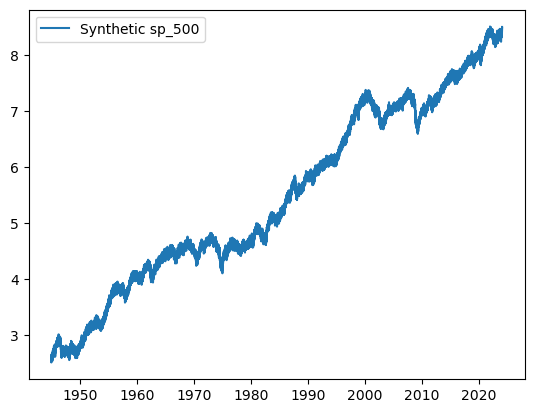

In [99]:
plt.plot(high_freq_l_earnings.index, high_freq_l_sp_500 .values, label='Synthetic sp_500')
plt.legend()
plt.show()

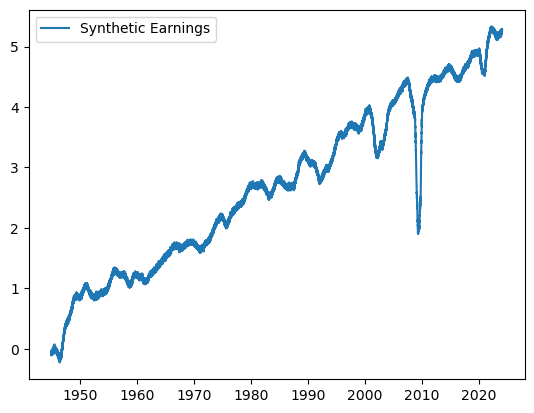

In [100]:
plt.plot(high_freq_l_earnings.index, high_freq_l_earnings.values, label='Synthetic Earnings')
plt.legend()
plt.show()

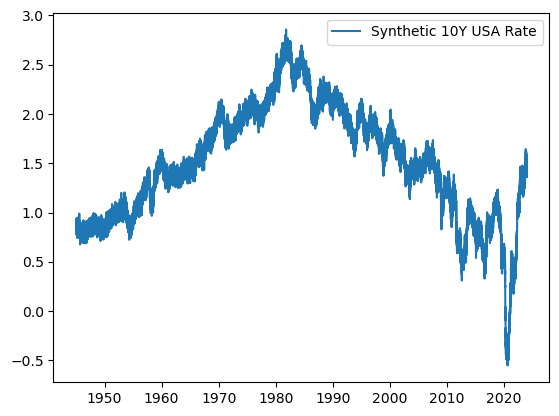

In [101]:
plt.plot(high_freq_l_10y_usa_rate.index, high_freq_l_10y_usa_rate.values, label='Synthetic 10Y USA Rate')
plt.legend()
plt.show()

In [102]:
df_synthetic_log_levels = pd.DataFrame({
    'sp_500': high_freq_l_sp_500,
    'earnings': high_freq_l_earnings,
    '10y_usa_rate': high_freq_l_10y_usa_rate
}, index=high_freq_l_sp_500.index)


In [103]:
df_synthetic_log_levels

sp_500  earnings  10y_usa_rate
1944-12-31  2.590027 -0.062368      0.887903
1945-01-01  2.568711 -0.075066      0.860738
1945-01-02  2.597213 -0.058576      0.894083
1945-01-03  2.628849 -0.040251      0.931234
1945-01-04  2.568188 -0.076000      0.856281
...              ...       ...           ...
2023-12-27  8.439792  5.254382      1.398561
2023-12-28  8.427502  5.246711      1.378066
2023-12-29  8.504730  5.291489      1.466302
2023-12-30  8.451836  5.260029      1.396489
2023-12-31  8.505113  5.290773      1.455633

[28855 rows x 3 columns]

In [104]:
df_synthetic_levels = pd.DataFrame(index=df_synthetic_log_levels.index)

In [105]:
for column in df_synthetic_log_levels.columns:
    df_synthetic_levels[column] = np.exp(df_synthetic_log_levels[column])
    
df_synthetic_levels.head()

sp_500  earnings  10y_usa_rate
1944-12-31  13.330134  0.939538      2.430027
1945-01-01  13.048993  0.927682      2.364905
1945-01-02  13.426268  0.943106      2.445092
1945-01-03  13.857813  0.960549      2.537639
1945-01-04  13.042172  0.926816      2.354388

## Selecting only the trading days

In [106]:
def get_trading_days(df_daily): 
    
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date=df_daily.index[0], 
                                end_date=df_daily.index[-1])
    trading_days = pd.DatetimeIndex(trading_days)
    trading_days = trading_days.tz_localize(None)

    df_traiding_days = df_daily.loc[df_daily.index.isin(trading_days)]

    return df_traiding_days

In [107]:
df_synthetic_log_levels

sp_500  earnings  10y_usa_rate
1944-12-31  2.590027 -0.062368      0.887903
1945-01-01  2.568711 -0.075066      0.860738
1945-01-02  2.597213 -0.058576      0.894083
1945-01-03  2.628849 -0.040251      0.931234
1945-01-04  2.568188 -0.076000      0.856281
...              ...       ...           ...
2023-12-27  8.439792  5.254382      1.398561
2023-12-28  8.427502  5.246711      1.378066
2023-12-29  8.504730  5.291489      1.466302
2023-12-30  8.451836  5.260029      1.396489
2023-12-31  8.505113  5.290773      1.455633

[28855 rows x 3 columns]

In [108]:
df_synthetic_log_levels_trading_days_only = get_trading_days(df_synthetic_log_levels)
df_synthetic_log_levels_trading_days_only

sp_500  earnings  10y_usa_rate
1945-01-02  2.597213 -0.058576      0.894083
1945-01-03  2.628849 -0.040251      0.931234
1945-01-04  2.568188 -0.076000      0.856281
1945-01-05  2.569135 -0.075655      0.856157
1945-01-06  2.633658 -0.038061      0.933253
...              ...       ...           ...
2023-12-22  8.389217  5.227099      1.364966
2023-12-26  8.446800  5.258957      1.412639
2023-12-27  8.439792  5.254382      1.398561
2023-12-28  8.427502  5.246711      1.378066
2023-12-29  8.504730  5.291489      1.466302

[20121 rows x 3 columns]

In [109]:
df_synthetic_levels_trading_days_only = get_trading_days(df_synthetic_levels)
df_synthetic_levels_trading_days_only

sp_500    earnings  10y_usa_rate
1945-01-02    13.426268    0.943106      2.445092
1945-01-03    13.857813    0.960549      2.537639
1945-01-04    13.042172    0.926816      2.354388
1945-01-05    13.054527    0.927136      2.354097
1945-01-06    13.924613    0.962654      2.542767
...                 ...         ...           ...
2023-12-22  4399.370801  186.251719      3.915589
2023-12-26  4660.135894  192.280870      4.106780
2023-12-27  4627.593063  191.403097      4.049368
2023-12-28  4571.066004  189.940543      3.967222
2023-12-29  4938.072979  198.638899      4.333179

[20121 rows x 3 columns]

## df_synthetic_filtered saving

In [110]:
"""""
df_synthetic_log_levels_trading_days_only.to_csv('df_synthetic_log_levels_trading_days_only.csv', index=True)
df_synthetic_levels_trading_days_only.to_csv('df_synthetic_levels_trading_days_only.csv', index=True)
"""""

'""\ndf_synthetic_log_levels_trading_days_only.to_csv(\'df_synthetic_log_levels_trading_days_only.csv\', index=True)\ndf_synthetic_levels_trading_days_only.to_csv(\'df_synthetic_levels_trading_days_only.csv\', index=True)\n'

In [111]:
df_synthetic_log_levels_trading_days_only = pd.read_csv('df_synthetic_log_levels_trading_days_only.csv', index_col=0, parse_dates=True)
df_synthetic_levels_trading_days_only = pd.read_csv('df_synthetic_levels_trading_days_only.csv', index_col=0, parse_dates=True)

In [112]:
df_synthetic_levels_trading_days_only

sp_500    earnings  10y_usa_rate
1945-01-02    13.426269    0.943106      2.445092
1945-01-03    13.857814    0.960549      2.537639
1945-01-04    13.042171    0.926816      2.354388
1945-01-05    13.054527    0.927136      2.354097
1945-01-06    13.924614    0.962654      2.542767
...                 ...         ...           ...
2023-12-22  4399.370325  186.251719      3.915589
2023-12-26  4660.135921  192.280869      4.106780
2023-12-27  4627.593001  191.403097      4.049368
2023-12-28  4571.065802  189.940543      3.967222
2023-12-29  4938.073592  198.638898      4.333179

[20121 rows x 3 columns]

# Functions Definition

## ADF Test Function


In [113]:
def adf_test(residuals_step1):
    
    result = adfuller(residuals_step1)
    return{
        'ADF Statistic:': result[0],
        'p-value:': result[1],
        'Critical Values:':result[4]}

## VAR Lag Selection Function


In [114]:
def var_lag_selection(l_px):
    
    # Creation of the VAR model
    model = VAR(l_px)

    # Using the 'select_order' function to determine the optimal lag
    lag_order = model.select_order(maxlags=15)

    # Find the optimal lag for each criterion
    aic_lag = lag_order.aic
    bic_lag = lag_order.bic
    hqic_lag = lag_order.hqic
    fpe_lag = lag_order.fpe

    # Trova il minimo tra questi lag
    min_lag = min(aic_lag, bic_lag, hqic_lag, fpe_lag)

    return min_lag

## Residual Normality Function (Jarque-Bera Test)

In [115]:
def jb_test(residuals):
    
    result=sms.jarque_bera(residuals)
    return {
        'jb statistic:': result[0],
        'p-value:': result[1],
        'skew:':result[2],
        'kurtosis:':result[3]}

## Series to Lagged Function

In [116]:
def series_to_lagged(d_l_px, lag_ecm, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		d_l_px: Sequence of observations as a dataframe.
		lag_ecm: Number of lags.
		
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""	
	n_vars=d_l_px.shape[1] # number of variables
	cols, names = list(), list()

	# input sequence (t-1, ... t-n)
	for i in range(1, lag_ecm + 1):
		cols.append(d_l_px.shift(i))
		names += [(d_l_px.columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
		
	# merges all the columns into a single dataframe
	agg = concat(cols, axis=1) # axis=1 means that the columns will be concatenated horizontally
	agg.columns = names
 
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True) 
	return agg

## Forecast_Regressor_Construction Function

In [117]:
def forecast_regressors_construction(d_l_px, lag_ecm, residuals_Step1):
    
    regressors_list = []
    n_vars = len(d_l_px.columns)

    # Add the values of the last 'lag_ecm' rows to regressors_list
    for i in range(1, lag_ecm + 1):
        for j in range(n_vars):
            regressors_list.append(d_l_px.iloc[-i, j])
    
    # Add last value of residuals_step1
    regressors_list.append(residuals_Step1.iloc[-1])

    # Converts list into NumPy array
    regressors = np.array(regressors_list)
    # 1: the resulting array will have only one row
    #-1: the resulting array will have as many columns as there are elements in the original array
    regressors = regressors.reshape(1, -1)
                                
    return regressors

## 2_Steps Engle_Granger Function

In [118]:
def f_engle_granger(p,x,rolling_date):
    
    start = time.perf_counter()


    # Assigning the initial values (including rolling_date)
    p = p.loc[:rolling_date]
    x = x.loc[:rolling_date]
    
    # Transforming p and x into log(p) and log(x)
    l_p = np.log(p)
    l_x = np.log(x)
    
    # Join beetween l_p and l_x
    l_px = l_p.join(l_x, how='inner')
    
    # Trasformation in diff_log
    d_l_p = l_p.diff().dropna()
    d_l_x = l_x.diff().dropna()

    # Percentage transformation of d_l_p and d_l_X and removal of non-percentage variables
    d_l_p["sp_500_100"] = d_l_p["sp_500"] * 100
    d_l_p.drop("sp_500", axis=1, inplace=True)

    d_l_x["earnings_100"] = d_l_x["earnings"] * 100
    d_l_x.drop("earnings", axis=1, inplace=True)
    
    d_l_x["10y_usa_rate_100"] = d_l_x["10y_usa_rate"] * 100
    d_l_x.drop("10y_usa_rate", axis=1, inplace=True)
    
    # Join beetween d_l_p and d_l_X
    d_l_px= d_l_p.join(d_l_x, how='inner')
    d_l_px = d_l_px.dropna()
    
    # Step 1  
    l_x_train=l_x
    l_y_train=l_p

    # Adding the constant
    l_x_train = sm.add_constant(l_x_train) 
    
    # Create the regression model on the training data
    model_step1 = sm.OLS(l_y_train, l_x_train).fit()
    residuals_step1 = model_step1.resid
    
    # Call the adf_test function
    adf_output=adf_test(residuals_step1)
    coefficients_step1 = model_step1.params 
    
    
    # Lagging of residuals
    residuals_step1_lagged = residuals_step1.shift(1)
    residuals_step1_lagged.dropna(inplace=True)
        
    #Call Var lag selection function
    min_lag = var_lag_selection(l_px)
  
    # Compute lag_ecm 
    lag_ecm = min_lag - 1
    
    # Call From Series to lagged function
    df_ecm = series_to_lagged(d_l_px,  lag_ecm,  dropnan=True)
    
    # Create a column "eps(t-1)" containing lagged residuals_step1 and add it to df_ecm
    residuals_step1_lagged.name = "eps(t-1)"
    df_ecm = df_ecm.join(residuals_step1_lagged, how='inner')
    
    # Perform an inner join between d_l_p and df_ecm to remove rows from d_l_p 
    # that do not have a match with rows in df_ecm
    df_ecm = df_ecm.join(d_l_p, how='inner') 

    # Step 2
    
    # Reassign the column 'sp_500_100' to d_l_p
    d_l_p_aligned = df_ecm['sp_500_100']   
    d_l_p_aligned = pd.DataFrame(d_l_p_aligned)
    # Remove the 'sp_500_100' column from df_ecm
    df_ecm = df_ecm.drop(columns=["sp_500_100"])
    #X = df_ecm 
    #y = d_l_p_aligned
    
    # Creation of training datasets for step 2
    d_l_x_train_step2 = df_ecm
    d_l_y_train_step2 = d_l_p_aligned
    d_l_x_train_step2 = sm.add_constant(d_l_x_train_step2)
    # Creation of the linear regression model for step 2
    model_step2 = sm.OLS(d_l_y_train_step2, d_l_x_train_step2).fit()
    residuals_step2 = model_step2.resid
    coefficients_step2 = model_step2.params
    
    # Calculate the predictions on the training data
    x_combined_engle_granger = d_l_x_train_step2
    y_combined_engle_granger = d_l_y_train_step2
    y_combined_engle_granger = y_combined_engle_granger.to_numpy().flatten()
    
    y_pred_combined_engle_granger = model_step2.predict(x_combined_engle_granger)
    n = len(d_l_y_train_step2)  # number of observations
    k = len(coefficients_step2)   # number of parameters
    
    # Calculate the likelihood
    residuals = residuals_step2
    sigma_squared = np.var(residuals)  # residuals variance
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals**2) / (2 * sigma_squared)
    
    # Training R2
    engle_granger_training_num = np.inner(y_pred_combined_engle_granger,y_pred_combined_engle_granger)
    engle_granger_training_den = np.inner(y_combined_engle_granger,y_combined_engle_granger)
    r2_training_engle_granger = engle_granger_training_num / engle_granger_training_den
    
    # Training RMSE
    rmse_training_engle_granger = np.sqrt(np.mean((y_combined_engle_granger - y_pred_combined_engle_granger) ** 2))

    std_dev_residuals_step2 = np.std(residuals_step2, ddof = k) #ddof deve esssere pari al numero di parametri udilizzati per fare la regrressione
    rsquared_step2 = model_step2.rsquared
    
    # Call Forecast_Regressors_Construction Function
    ecm_regressors = forecast_regressors_construction(d_l_px, lag_ecm, residuals_step1)
    # Adding costant
    ecm_regressors = sm.add_constant(ecm_regressors, has_constant='add')
    
    # Calculate predictions using model_step2
    forecast_engle_granger = model_step2.predict(ecm_regressors)
    forecast_engle_granger = forecast_engle_granger.item()

    # Calculate confidence intervals
    lower_bound_engle_granger = forecast_engle_granger - 2.33 * std_dev_residuals_step2
    upper_bound_engle_granger = forecast_engle_granger + 2.33 * std_dev_residuals_step2
    start = time.perf_counter()
    # Cointegration test e regressione OLS
    end = time.perf_counter()
    time_engle_granger = end - start

    
    
    risultati = {
        'forecast_engle_granger': forecast_engle_granger,
        'best_engle_granger_model': coefficients_step2,
        'n_observation_engle_granger' : n,
        'n_params_engle_granger': k,
        'log_likelihood' : log_likelihood,
        'r2_training_engle_granger': r2_training_engle_granger,
        'std_dev_residuals_engle_granger':std_dev_residuals_step2, 
        'rmse_training_engle_granger' : rmse_training_engle_granger,
        'lower_bound_engle_granger': lower_bound_engle_granger,
        'upper_bound_engle_granger': upper_bound_engle_granger,
        'rsquared_step2' : rsquared_step2,
        'residuals_step1': residuals_step1,
        'adf_output':adf_output['p-value:'],
        'd_l_px':d_l_px,
        'd_l_p_aligned': d_l_p_aligned,
        'df_ecm': df_ecm,
        'd_l_x_train_step2': d_l_x_train_step2,
        'lag_ecm': lag_ecm,
        'coefficients_step2' : coefficients_step2,
        'residuals_step2' : residuals_step2,
        'coefficients_of_eps(t-1)_step2':coefficients_step2['eps(t-1)'],
        "time_engle_granger": time_engle_granger,
        }
    
    return risultati


## BIC Function

In [119]:
def calculate_bic(n, k, log_likelihood):
    bic =  -2 * log_likelihood + k * np.log(n)
    return  bic

## AIC Function

In [120]:
def calculate_aic(n, k, log_likelihood):
    aic = -2 * log_likelihood + 2 * k
    return aic

## ensemble_learning_weighted_rmse function

In [121]:
def ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf,  forecast_ann, rmse_training_engle_granger, rmse_training_rf, rmse_training_ann):
    inv_rmse_engle_granger = 1 / rmse_training_engle_granger
    inv_rmse_rf = 1 / rmse_training_rf
    inv_rmse_ann = 1 / rmse_training_ann
    total_inv_rmse = inv_rmse_engle_granger + inv_rmse_rf  + inv_rmse_ann
    rmse_training_weight_engle_granger = inv_rmse_engle_granger / total_inv_rmse
    rmse_training_weight_rf = inv_rmse_rf / total_inv_rmse
    rmse_training_weight_ann = inv_rmse_ann / total_inv_rmse
    forecast_ensemble_learning_weighted_rmse = (
        rmse_training_weight_engle_granger * forecast_engle_granger +
        rmse_training_weight_rf * forecast_rf +
        rmse_training_weight_ann * forecast_ann
    )
    
    
    return {"forecast_ensemble_learning_weighted_rmse": forecast_ensemble_learning_weighted_rmse,
            "rmse_training_weight_engle_granger": rmse_training_weight_engle_granger,
            "rmse_training_weight_rf": rmse_training_weight_rf,
            "rmse_training_weight_ann": rmse_training_weight_ann}
    

## Building weights  Function 

In [122]:
def building_weights(ic_engle_granger, ic_rf, ic_ann, best_monthly_ic):
    
    # IC differences
    delta_engle_granger = ic_engle_granger - best_monthly_ic
    delta_rf = ic_rf - best_monthly_ic
    delta_ann = ic_ann - best_monthly_ic
    
    # Normalizing IC differences
    delta_max = max(delta_engle_granger, delta_rf, delta_ann)
    delta_engle_granger_norm = (delta_max - delta_engle_granger) / delta_max
    delta_rf_norm = (delta_max - delta_rf) / delta_max
    delta_ann_norm = (delta_max - delta_ann) / delta_max
    
    # Final weights
    weight_engle_granger = ((delta_engle_granger_norm)**2) / ((delta_rf_norm)**2 + (delta_ann_norm)**2)
    weight_rf = ((delta_rf_norm)**2) / ((delta_rf_norm)**2 + (delta_ann_norm)**2)
    weight_ann = ((delta_ann_norm)**2) / ((delta_rf_norm)**2 + (delta_ann_norm)**2)
    
    return{ 
        'weight_engle_granger': weight_engle_granger,
        'weight_rf': weight_rf,
        'weight_ann': weight_ann
        }


##  Monthly Best Model Function

In [123]:
def monthly_best_model(best_monthly_ic, ic_engle_granger, ic_rf,  
                       best_engle_granger_model, best_rf_model,  best_ann_params,  
                       forecast_engle_granger, forecast_random_forest, forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf, std_dev_residuals_ann):
    
    if best_monthly_ic == ic_engle_granger:
        best_model_name = 'engle_granger'
        best_model_params = best_engle_granger_model
        best_forecast = forecast_engle_granger
        best_std_dev_residuals = std_dev_residuals_engle_granger  
        
    elif best_monthly_ic == ic_rf:
        best_model_name = 'random_forest'
        best_model_params = best_rf_model
        best_forecast = forecast_random_forest
        best_std_dev_residuals = std_dev_residuals_rf  

        

    else:
        best_model_name = 'ann'
        best_model_params = best_ann_params
        best_forecast = forecast_ann
        best_std_dev_residuals = std_dev_residuals_ann
    
    return {
        'best_monthly_ic': best_monthly_ic,
        'best_model_name': best_model_name,
        'best_model_params': best_model_params,
        'best_forecast': best_forecast,
        'best_std_dev_residuals' : best_std_dev_residuals,
    }

##  Monthly Weighted Average Function

In [124]:
def monthly_weighted_average(model_list, return_sp_500):
    
    # Sort models based on weights in descending order
    model_list_sorted = sorted(model_list, key=lambda x: x['weight'], reverse=True)

    # Cumulative sum of weights and selection of the best models
    cumulative_weight = 0
    average_forecast_num = 0
    average_std_dev_residuals_num = 0
    selected_models = []
        
    for model_info in model_list_sorted:
        cumulative_weight += model_info['weight']
        
        average_forecast_num += model_info['weight'] * model_info['forecast']
        average_std_dev_residuals_num += model_info['weight'] * model_info['std_dev_residuals']
        
        average_forecast_den = cumulative_weight
        average_std_dev_residuals_den = cumulative_weight
        selected_models.append(model_info)
        
        # Stop the loop when the cumulative sum exceeds 0.95
        if cumulative_weight >= 0.95:
            break
        
    average_forecast = average_forecast_num / average_forecast_den
    average_std_dev_residuals = average_std_dev_residuals_num / average_std_dev_residuals_den

    return {
        'selected_models': selected_models,
        'total_weight': cumulative_weight,
        'return_sp500': return_sp_500,
        'average_forecast': average_forecast,
        'average_std_dev_residuals' : average_std_dev_residuals
    }


##  Random Forest Function

In [125]:
def f_random_forest(df_ecm, d_l_p_aligned, random_seed=42):

    start = time.perf_counter()
    # Set the seed to ensure reproducibility of the results
    np.random.seed(random_seed)
    
    # Assign the features (x_rf) and target variable (y_rf) from the input DataFrames
    x_rf = df_ecm
    y_rf = d_l_p_aligned
    
    # Split the dataset into training set (70%) and validation set (30%)
    split_index = int(len(x_rf) * 0.7)
    
    x_train_rf = x_rf.iloc[:split_index]
    x_validation_rf = x_rf.iloc[split_index:]

    y_train_rf = y_rf.iloc[:split_index]
    y_validation_rf = y_rf.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_rf = y_train_rf.to_numpy().ravel()
    y_validation_rf = y_validation_rf.to_numpy().ravel()
    
    # Initialize the RandomForestRegressor model with a fixed random seed for reproducibility
    rf = RandomForestRegressor(random_state=random_seed , n_jobs=-1)

    # Define the parameters selected from the Professor's article
    param_grid = {
        'n_estimators': [300],
        #'max_features': ['sqrt'],
        'max_depth': [1, 2, 3, 4, 5, 6],
        #'min_samples_split': [2, 5],
        #'min_samples_leaf': [1, 2],
        'bootstrap': [True]
    }
    
    # Initialize best parameters and minimum error
    best_params = None
    best_error = float('inf')  # Set the initial minimum error to infinity

    # Grid Search
    # Perform Grid Search on Training Set and Validation Set
    for params in ParameterGrid(param_grid):
        rf.set_params(**params)
        rf.fit(x_train_rf, y_train_rf)
        y_pred = rf.predict(x_validation_rf)
        error = root_mean_squared_error(y_validation_rf, y_pred)
        # If the current error is lower than the previous one (best_error), update the best parameters
        if error < best_error:
            best_error = error
            best_params = params
    
    # Combine the training set and validation set to retrain the final model with the best parameters
    x_combined_rf = pd.concat([x_train_rf, x_validation_rf])
    y_combined_rf = np.concatenate([y_train_rf, y_validation_rf])

    # Create a new RandomForestRegressor model with the best parameters found
    best_rf_model = RandomForestRegressor(**best_params, n_jobs=-1)
    # Train the final model with the combined dataset (training + validation)
    best_rf_model.fit(x_combined_rf, y_combined_rf)
    # Calculate predictions on the combined data
    y_pred_combined_rf = best_rf_model.predict(x_combined_rf)
    
    n = len(y_combined_rf)  # number of observations
    k = len(best_params)  # number of parameters 
     
    # Calculate log likelihood
    residuals_rf = y_combined_rf - y_pred_combined_rf
    sigma_squared = np.var(residuals_rf)  # Variance of residuals
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_rf**2) / (2 * sigma_squared)

    # Training R2
    rf_training_num = np.inner(y_pred_combined_rf, y_pred_combined_rf)
    rf_training_den = np.inner(y_combined_rf, y_combined_rf)
    r2_training_rf = rf_training_num / rf_training_den

    # Training RMSE
    rmse_training_rf = np.sqrt(np.mean((y_combined_rf - y_pred_combined_rf) ** 2))
    
    #Standard deviation of residuals
    std_dev_residuals_rf = np.std(residuals_rf, ddof = k)
    
    end = time.perf_counter()
    time_rf = end - start

    return {
        'best_rf_model': best_rf_model,
        'n_observation_rf': n,
        'n_params_rf': k,
        'log_likelihood': log_likelihood,
        'r2_training_rf': r2_training_rf,       
        'rmse_training_rf': rmse_training_rf, 
        'std_dev_residuals_rf' : std_dev_residuals_rf,
        'time_rf': time_rf,
        #'best_params': best_grid,
        #'best_error': best_error,
    }


## ANN Functions

In [126]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

In [127]:

def create_ann_model(activation='relu', neurons=[32,16] ,  input_shape=None ,learning_rate=0.01): #epochs=100 e learning rate=0.01 potrebbero essere eliminati  da  qui in teoria perchè vengono richiamati in f_ann
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(units =neurons[0], activation=activation))
    model.add(layers.Dense(units = neurons[1], activation=activation))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



In [128]:

'''
def f_ann(df_ecm, d_l_p_aligned, random_seed = 42):
    start = time.perf_counter()
    
    # Set the seed to ensure reproducibility
    set_seed(random_seed)
    
    # Assign features (x_ann) and target variable (y_ann) from the input DataFrames
    x_ann = df_ecm
    y_ann = d_l_p_aligned
    
    # Split the dataset into training set and validation set
    split_index = int(len(x_ann) * 0.7)
    
    x_train_ann = x_ann.iloc[:split_index]
    x_validation_ann = x_ann.iloc[split_index:]

    y_train_ann = y_ann.iloc[:split_index]
    y_validation_ann = y_ann.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_ann = y_train_ann.to_numpy().ravel()
    y_validation_ann = y_validation_ann.to_numpy().ravel()
    
    # Grid search parameters
    param_grid = {
        'activation': ['relu'],
        'input_shape': [x_train_ann.shape[1]],
        'learning_rate': [0.01, 0.1],

    }
    
    # Initialize best error and best parameters
    best_error = float('inf')
    best_ann_params = {}
    
  
    # Manual Grid Search
    # Perform Grid Search on Train Set and Validation Set
    for params in ParameterGrid(param_grid):
        # Create and train the model
        model_ann = create_ann_model(**params)
        model_ann.fit(x_train_ann, y_train_ann, epochs=20, batch_size=x_train_ann.shape[0], 
                      validation_data=(x_validation_ann, y_validation_ann), shuffle=False, verbose=0)
        y_pred = model_ann.predict(x_validation_ann).ravel()
        error = root_mean_squared_error(y_validation_ann, y_pred)
        
        # Update best parameters if the error improves
        if error < best_error:
            best_error = error
            best_ann_params = params
            
    # Create combined datasets
    x_combined_ann = pd.concat([x_train_ann, x_validation_ann])
    y_combined_ann = np.concatenate([y_train_ann, y_validation_ann])

    # Create a new ANN model with the best parameters found
    best_ann_model = create_ann_model(**best_ann_params)
    # Train the final model with the combined dataset (training + validation)
    best_ann_model.fit(x_combined_ann, y_combined_ann, epochs= 50, batch_size=x_combined_ann.shape[0], shuffle=False, verbose=0) 
    # Make predictions on the combined data
    y_pred_combined_ann = best_ann_model.predict(x_combined_ann).ravel()
    
    # Calculate the BIC
    n = len(y_combined_ann)  # number of observations
    k = len(best_ann_params)
    
    # Calculate log likelihood
    residuals_ann = y_combined_ann - y_pred_combined_ann
    sigma_squared = np.var(residuals_ann)  # Variance of residuals_ann
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_ann**2) / (2 * sigma_squared)


    # Training R2
    ann_training_num = np.inner(y_pred_combined_ann, y_pred_combined_ann)
    ann_training_den = np.inner(y_combined_ann, y_combined_ann)
    r2_training_ann = ann_training_num / ann_training_den
    
    # Training RMSE
    rmse_training_ann = np.sqrt(np.mean((y_combined_ann - y_pred_combined_ann) ** 2))
    
    #Standard deviation of residuals_ann
    std_dev_residuals_ann = np.std(residuals_ann, ddof = k)
    end = time.perf_counter()
    time_ann = end - start
    return {
        'best_ann_model': best_ann_model,
        'best_ann_params': best_ann_params,
        'n_observation_ann': n,
        'n_params_ann': k,  
        'log_likelihood': log_likelihood,      
        'r2_training_ann': r2_training_ann,
        'rmse_training_ann': rmse_training_ann,
        'std_dev_residuals_ann' : std_dev_residuals_ann,
        'time_ann': time_ann,
        #'best_error': best_error,
    }
'''


"\ndef f_ann(df_ecm, d_l_p_aligned, random_seed = 42):\n    start = time.perf_counter()\n    \n    # Set the seed to ensure reproducibility\n    set_seed(random_seed)\n    \n    # Assign features (x_ann) and target variable (y_ann) from the input DataFrames\n    x_ann = df_ecm\n    y_ann = d_l_p_aligned\n    \n    # Split the dataset into training set and validation set\n    split_index = int(len(x_ann) * 0.7)\n    \n    x_train_ann = x_ann.iloc[:split_index]\n    x_validation_ann = x_ann.iloc[split_index:]\n\n    y_train_ann = y_ann.iloc[:split_index]\n    y_validation_ann = y_ann.iloc[split_index:]\n\n    # Convert y into a numpy array and reshape y into a one-dimensional array\n    y_train_ann = y_train_ann.to_numpy().ravel()\n    y_validation_ann = y_validation_ann.to_numpy().ravel()\n    \n    # Grid search parameters\n    param_grid = {\n        'activation': ['relu'],\n        'input_shape': [x_train_ann.shape[1]],\n        'learning_rate': [0.01, 0.1],\n\n    }\n    \n    # Ini

In [129]:

def f_ann(df_ecm, d_l_p_aligned, random_seed = 42):
    start = time.perf_counter()
    
    # Set the seed to ensure reproducibility
    set_seed(random_seed)
    
    # Assign features (x_ann) and target variable (y_ann) from the input DataFrames
    x_ann = df_ecm
    y_ann = d_l_p_aligned
    
    # Split the dataset into training set and validation set
    split_index = int(len(x_ann) * 0.7)
    
    x_train_ann = x_ann.iloc[:split_index]
    x_validation_ann = x_ann.iloc[split_index:]

    y_train_ann = y_ann.iloc[:split_index]
    y_validation_ann = y_ann.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_ann = y_train_ann.to_numpy().ravel()
    y_validation_ann = y_validation_ann.to_numpy().ravel()
    

  

    # Create combined datasets
    #x_combined_ann = pd.concat([x_train_ann, x_validation_ann])
    #y_combined_ann = np.concatenate([y_train_ann, y_validation_ann])

    # Crea e allena il modello una sola volta
    model_ann = create_ann_model(input_shape=x_ann.shape[1])
    model_ann.fit(x_train_ann, y_train_ann, epochs=10, batch_size=32, shuffle=False, verbose=0)
    # Make predictions on validation data
    y_pred_ann = model_ann.predict(x_validation_ann).ravel()
    
    # Calculate the BIC
    n = len(y_validation_ann)  # number of observations
    k = 1
    
    # Calculate log likelihood
    residuals_ann = y_validation_ann - y_pred_ann
    sigma_squared = np.var(residuals_ann)  # Variance of residuals_ann
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_ann**2) / (2 * sigma_squared)


    # Training R2
    ann_training_num = np.inner(y_pred_ann, y_pred_ann)
    ann_training_den = np.inner(y_validation_ann, y_validation_ann)
    r2_training_ann = ann_training_num / ann_training_den
    
    # Training RMSE
    rmse_training_ann = np.sqrt(np.mean((y_validation_ann - y_pred_ann) ** 2))
    
    #Standard deviation of residuals_ann
    std_dev_residuals_ann = np.std(residuals_ann, ddof = k)
    end = time.perf_counter()
    time_ann = end - start
    return {
        'best_ann_model': model_ann,
        'best_ann_params': model_ann,
        'n_observation_ann': n,
        'n_params_ann': k,  
        'log_likelihood': log_likelihood,      
        'r2_training_ann': r2_training_ann,
        'rmse_training_ann': rmse_training_ann,
        'std_dev_residuals_ann' : std_dev_residuals_ann,
        'time_ann': time_ann,
        #'best_error': best_error,
    }



# Backtest Cycle

In [130]:
# Define the date range
start_backtest_date = pd.to_datetime('2001-01-31')
end_backtest_date = pd.to_datetime('2023-12-31')

# Define p and x
p = df_synthetic_levels_trading_days_only[['sp_500']]
x = df_synthetic_levels_trading_days_only[['earnings', '10y_usa_rate']] 

# Create the backtest dataset
df_filtered = df_synthetic_levels_trading_days_only.loc[start_backtest_date:end_backtest_date]

In [131]:
df_filtered

sp_500    earnings  10y_usa_rate
2001-01-31  1321.984769   48.189202      5.096041
2001-02-01  1322.845408   48.175568      5.102947
2001-02-02  1300.897217   47.673963      5.003115
2001-02-05  1368.394534   49.010229      5.329147
2001-02-06  1366.904031   48.946421      5.325099
...                 ...         ...           ...
2023-12-22  4399.370325  186.251719      3.915589
2023-12-26  4660.135921  192.280869      4.106780
2023-12-27  4627.593001  191.403097      4.049368
2023-12-28  4571.065802  189.940543      3.967222
2023-12-29  4938.073592  198.638898      4.333179

[5765 rows x 3 columns]

In [132]:
print(p.isna().sum())  # Conta i NaN
print(np.isinf(p).sum())  # Conta gli infiniti

sp_500    0
dtype: int64
sp_500    0
dtype: int64


In [133]:
print(x.isna().sum())  # Conta i NaN
print(np.isinf(x).sum())  # Conta gli infiniti


earnings        0
10y_usa_rate    0
dtype: int64
earnings        0
10y_usa_rate    0
dtype: int64


In [134]:
p.min(), x.min()

(sp_500    12.401708
 dtype: float64,
 earnings        0.799670
 10y_usa_rate    0.575984
 dtype: float64)

In [135]:
df_filtered

sp_500    earnings  10y_usa_rate
2001-01-31  1321.984769   48.189202      5.096041
2001-02-01  1322.845408   48.175568      5.102947
2001-02-02  1300.897217   47.673963      5.003115
2001-02-05  1368.394534   49.010229      5.329147
2001-02-06  1366.904031   48.946421      5.325099
...                 ...         ...           ...
2023-12-22  4399.370325  186.251719      3.915589
2023-12-26  4660.135921  192.280869      4.106780
2023-12-27  4627.593001  191.403097      4.049368
2023-12-28  4571.065802  189.940543      3.967222
2023-12-29  4938.073592  198.638898      4.333179

[5765 rows x 3 columns]

In [ ]:
# Backtest Cycle

# Lists initialization
date_list=[]
y_true_list = []
sp_500_true_list = []
# Original models
adf_output_list = []
residuals_step1_list = []
rsquared_step2_list = []
coefficients_of_eps_t_1__step2_list = []

forecast_random_walk_list = []
forecast_engle_granger_list = []
forecast_rf_list = []
forecast_ann_list = []
lower_bound_engle_granger_list = []
upper_bound_engle_granger_list = []
lower_bound_rf_list = []
upper_bound_rf_list = []
lower_bound_ann_list = []
upper_bound_ann_list = []

rmse_training_rf_list = []
rmse_training_ann_list = []

# Weighted models
forecast_ensemble_learning_simple_mean_list = []
forecast_ensemble_learning_weighted_r2_list = []
forecast_ensemble_learning_weighted_rmse_list = []
#
forecast_ensemble_learning_weighted_test_rmse_list = []

lower_bound_ensemble_learning_simple_mean_list =[]
upper_bound_ensemble_learning_simple_mean_list =[]
lower_bound_ensemble_learning_weighted_r2_list =[]
upper_bound_ensemble_learning_weighted_r2_list =[]
lower_bound_ensemble_learning_weighted_rmse_list =[]
upper_bound_ensemble_learning_weighted_rmse_list =[]
#
upper_bound_ensemble_learning_weighted_test_rmse_list = []
lower_bound_ensemble_learning_weighted_test_rmse_list =[]

# Combined Forecast
weight_bic_rf_list = []
weight_bic_ann_list = []
weight_bic_engle_granger_list = []

weight_aic_rf_list = []
weight_aic_ann_list = []
weight_aic_engle_granger_list = []

forecast_bic_monthly_best_list = []
forecast_aic_monthly_best_list = []
forecast_bic_monthly_weighted_average_list = []
forecast_aic_monthly_weighted_average_list = []

forecast_bic_monthly_weighted_average_converted_list = []

lower_bound_bic_monthly_best_list = []
upper_bound_bic_monthly_best_list = []
lower_bound_aic_monthly_best_list = []
upper_bound_aic_monthly_best_list = []

lower_bound_bic_weighted_average_list = []
upper_bound_bic_weighted_average_list = []
lower_bound_aic_weighted_average_list = []
upper_bound_aic_weighted_average_list = []

lower_bound_bic_weighted_average_converted_list = []
upper_bound_bic_weighted_average_converted_list = []



# Dictionaries initialization
engle_granger_dict ={}
rf_dict = {}
ann_dict = {}

forecast_bic_best_dict = {}
forecast_bic_weighted_average_dict = {}
forecast_aic_best_dict = {}
forecast_aic_weighted_average_dict = {}

# Reproducibility of random walk
np.random.seed(42)
log_path = "progress_log.txt"


# df_filtered iteration
idx = 0
for rolling_date, row in df_filtered.iterrows():
    start_time = time.time()
    if rolling_date == pd.Timestamp('2023-12-31'):
        break
    # Get the sp_500 values for the month corresponding to 'rolling_date' from 'df_filtered' (t)
    sp_500_current= df_filtered.loc[rolling_date,'sp_500']
    # Calculate the next day after rolling_date
    if idx + 1 < len(df_filtered.index):
        next_date = df_filtered.index[idx + 1]
    else:
        # Ultima data disponibile: esci dal loop
        break    # Get the sp_500 values for the month following 'rolling_date' from 'df_filtered' (t+1)
    sp_500_next = df_filtered.loc[next_date,'sp_500']
    # log-trasformation
    l_sp_500_current = np.log(sp_500_current)
    l_sp_500_next = np.log(sp_500_next)
    # Returns
    return_sp_500 = (l_sp_500_next - l_sp_500_current)*100
    # Lists update
    date_list.append(next_date)
    sp_500_true_list.append(sp_500_next)
    y_true_list.append(return_sp_500)
    # rolling date update
    idx = idx + 1

    # Data calling
    output_engle_granger = f_engle_granger(p, x, rolling_date)
    d_l_px = output_engle_granger['d_l_px'] 
    return_sp_500_current = d_l_px["sp_500_100"].iloc[-1]
    std_return_sp_500 = d_l_px["sp_500_100"].std()
    
    # Random walk forecast
    noise = np.random.normal(0, 1)
    forecast_random_walk = return_sp_500_current + std_return_sp_500 * noise
    forecast_random_walk_list.append(forecast_random_walk)
    
    # ENGLE - GRANGER
    forecast_engle_granger = output_engle_granger['forecast_engle_granger']
    #forecast_engle_granger = forecast_engle_granger.item()
    best_engle_granger_model = output_engle_granger['best_engle_granger_model']
    n_observation_engle_granger = output_engle_granger['n_observation_engle_granger']
    n_params_engle_granger = output_engle_granger['n_params_engle_granger']
    log_likelihood_engle_granger = output_engle_granger['log_likelihood']
    std_dev_residuals_engle_granger = output_engle_granger['std_dev_residuals_engle_granger']
    # bic
    bic_engle_granger = calculate_bic(n_observation_engle_granger, n_params_engle_granger, log_likelihood_engle_granger)
    # aic
    aic_engle_granger = calculate_aic(n_observation_engle_granger, n_params_engle_granger, log_likelihood_engle_granger)
    # Engle-Granger's lists update
    adf_output_list.append(output_engle_granger['adf_output'])
    residuals_step1_list.append(output_engle_granger['residuals_step1'])
    rsquared_step2_list.append(output_engle_granger['rsquared_step2'])
    coefficients_of_eps_t_1__step2_list.append(output_engle_granger['coefficients_of_eps(t-1)_step2'])
    forecast_engle_granger_list.append(forecast_engle_granger)
    lower_bound_engle_granger_list.append(output_engle_granger['lower_bound_engle_granger'])
    upper_bound_engle_granger_list.append(output_engle_granger['upper_bound_engle_granger'])
    time_engle_granger = output_engle_granger['time_engle_granger']
    print(f"Time taken for Engle-Granger: {time_engle_granger:.2f} seconds")


    
    
    # RANDOM FOREST
    output_rf = f_random_forest(output_engle_granger['df_ecm'],output_engle_granger['d_l_p_aligned'])
    regressors_rf = forecast_regressors_construction(output_engle_granger['d_l_px'],output_engle_granger['lag_ecm'], output_engle_granger['residuals_step1'])
    forecast_rf = output_rf['best_rf_model'].predict(regressors_rf)
    forecast_rf = forecast_rf.item()
    best_rf_model = output_rf['best_rf_model']
    n_observation_rf = output_rf['n_observation_rf']
    n_params_rf = output_rf['n_params_rf']
    log_likelihood_rf = output_rf['log_likelihood']
    std_dev_residuals_rf = output_rf['std_dev_residuals_rf']
    rmse_training_rf = output_rf['rmse_training_rf']
    time_rf = output_rf['time_rf']
    print(f"Time taken for Random Forest: {time_rf:.2f} seconds")
    
    # bic
    bic_rf = calculate_bic(n_observation_rf, n_params_rf, log_likelihood_rf)
    # aic
    aic_rf = calculate_aic(n_observation_rf, n_params_rf, log_likelihood_rf)
    # Confindence interval 99%
    lower_bound_rf = forecast_rf - 2.33 * std_dev_residuals_rf
    upper_bound_rf = forecast_rf + 2.33 * std_dev_residuals_rf
    # Random forest lists update
    forecast_rf_list.append(forecast_rf)
    lower_bound_rf_list.append(lower_bound_rf)
    upper_bound_rf_list.append(upper_bound_rf)
    rmse_training_rf_list.append(rmse_training_rf)

       
        
    # ANN
    output_ann = f_ann(output_engle_granger['df_ecm'],output_engle_granger['d_l_p_aligned'])
    ann_regressors = forecast_regressors_construction(output_engle_granger['d_l_px'],output_engle_granger['lag_ecm'], output_engle_granger['residuals_step1'])
    forecast_ann = output_ann['best_ann_model'].predict(ann_regressors)
    forecast_ann = forecast_ann.item()
    best_ann_model = output_ann['best_ann_model']
    best_ann_params = output_ann['best_ann_params']
    n_observation_ann = output_ann['n_observation_ann']
    n_params_ann = output_ann['n_params_ann']
    log_likelihood_ann = output_ann['log_likelihood']
    std_dev_residuals_ann = output_ann['std_dev_residuals_ann']
    rmse_training_ann = output_ann['rmse_training_ann']
    time_ann = output_ann['time_ann']
    print(f"Time taken for ANN: {time_ann:.2f} seconds")
    
    # bic
    bic_ann = calculate_bic(n_observation_ann, n_params_ann, log_likelihood_ann)
    # aic
    aic_ann = calculate_aic(n_observation_ann, n_params_ann, log_likelihood_ann)
    # Confindence interval 99%
    lower_bound_ann = forecast_ann - 2.33 * std_dev_residuals_ann
    upper_bound_ann = forecast_ann + 2.33 * std_dev_residuals_ann
    # ANN lists update
    forecast_ann_list.append(forecast_ann)
    lower_bound_ann_list.append(lower_bound_ann)
    upper_bound_ann_list.append(upper_bound_ann)
    rmse_training_ann_list.append(rmse_training_ann)
    
    # ENSEMBLE LEARNING SIMPLE MEAN
    forecast_ensemble_learning_simple_mean = (forecast_engle_granger + forecast_rf + forecast_ann) / 3
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_simple_mean = (std_dev_residuals_engle_granger + std_dev_residuals_rf + std_dev_residuals_ann) / 3   
    lower_bound_ensemble_learning_simple_mean = forecast_ensemble_learning_simple_mean - 2.33 * std_dev_residuals_ensemble_learning_simple_mean
    upper_bound_ensemble_learning_simple_mean = forecast_ensemble_learning_simple_mean + 2.33 * std_dev_residuals_ensemble_learning_simple_mean
    # Ensemble learning simple mean lists update
    forecast_ensemble_learning_simple_mean_list.append(forecast_ensemble_learning_simple_mean)
    lower_bound_ensemble_learning_simple_mean_list.append(lower_bound_ensemble_learning_simple_mean)
    upper_bound_ensemble_learning_simple_mean_list.append(upper_bound_ensemble_learning_simple_mean)
    
    # ENSEMBLE LEARNING WEIGHTED R2 MEAN
    r2_training_engle_granger = output_engle_granger['r2_training_engle_granger']
    r2_training_rf = output_rf['r2_training_rf']
    r2_training_ann = output_ann['r2_training_ann']
    total_r2_training = r2_training_engle_granger + r2_training_rf  + r2_training_ann
    r2_training_weight_engle_granger = r2_training_engle_granger / total_r2_training
    r2_training_weight_rf = r2_training_rf / total_r2_training
    r2_training_weight_ann = r2_training_ann / total_r2_training
    forecast_ensemble_learning_weighted_r2 = r2_training_weight_engle_granger * forecast_engle_granger + r2_training_weight_rf*forecast_rf + r2_training_weight_ann*forecast_ann
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_weighted_r2 = r2_training_weight_engle_granger*std_dev_residuals_engle_granger + r2_training_weight_rf*std_dev_residuals_rf + r2_training_weight_ann*std_dev_residuals_ann
    lower_bound_ensemble_learning_weighted_r2 = forecast_ensemble_learning_weighted_r2 - 2.33 * std_dev_residuals_ensemble_learning_weighted_r2
    upper_bound_ensemble_learning_weighted_r2 = forecast_ensemble_learning_weighted_r2 + 2.33 * std_dev_residuals_ensemble_learning_weighted_r2
    # Ensemble learning weighted R2 mean list update
    forecast_ensemble_learning_weighted_r2_list.append(forecast_ensemble_learning_weighted_r2)
    lower_bound_ensemble_learning_weighted_r2_list.append(lower_bound_ensemble_learning_weighted_r2)
    upper_bound_ensemble_learning_weighted_r2_list.append(upper_bound_ensemble_learning_weighted_r2)    

      
    
    # ENSEMBLE LEARNING WEIGHTED RMSE MEAN
    rmse_training_engle_granger = output_engle_granger['rmse_training_engle_granger']
    rmse_training_rf = output_rf['rmse_training_rf']
    rmse_training_ann = output_ann['rmse_training_ann']
    rmse_training_engle_granger = output_engle_granger['rmse_training_engle_granger']
    output_ensemble_learning_weighted_rmse = ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf, forecast_ann, rmse_training_engle_granger, rmse_training_rf, rmse_training_ann)
    forecast_ensemble_learning_weighted_rmse = output_ensemble_learning_weighted_rmse['forecast_ensemble_learning_weighted_rmse']
    rmse_training_weight_engle_granger = output_ensemble_learning_weighted_rmse['rmse_training_weight_engle_granger']
    rmse_training_weight_rf = output_ensemble_learning_weighted_rmse['rmse_training_weight_rf']
    rmse_training_weight_ann = output_ensemble_learning_weighted_rmse['rmse_training_weight_ann']
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_weighted_rmse = rmse_training_weight_engle_granger * std_dev_residuals_engle_granger + rmse_training_weight_rf * std_dev_residuals_rf  + rmse_training_weight_ann*std_dev_residuals_ann
    lower_bound_ensemble_learning_weighted_rmse = forecast_ensemble_learning_weighted_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_rmse
    upper_bound_ensemble_learning_weighted_rmse = forecast_ensemble_learning_weighted_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_rmse
    #Ensemble learning weighted RMSE mean
    forecast_ensemble_learning_weighted_rmse_list.append(forecast_ensemble_learning_weighted_rmse)
    lower_bound_ensemble_learning_weighted_rmse_list.append(lower_bound_ensemble_learning_weighted_rmse)
    upper_bound_ensemble_learning_weighted_rmse_list.append(upper_bound_ensemble_learning_weighted_rmse)    
     
    # ENSEMBLE LEARNING WEIGHTED TEST RMSE
    # At the first iteration of the backtest cycle no weights are given to the forecasts 
    if rolling_date == df_filtered.index[0]:
        forecast_ensemble_learning_weighted_test_rmse = (forecast_engle_granger + forecast_rf + forecast_ann) / 3
        # Confindence interval 99%
        std_dev_residuals_ensemble_learning_weighted_test_rmse = (std_dev_residuals_engle_granger +  std_dev_residuals_rf + std_dev_residuals_ann) / 3
        lower_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
        upper_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
    else:
        # Calcolo degli RMSE per ogni modello (dalla seconda iterazione in poi)
        rmse_test_engle_granger = root_mean_squared_error(y_true_list, forecast_engle_granger_list)
        rmse_test_rf = root_mean_squared_error(y_true_list, forecast_rf_list)
        rmse_test_ann = root_mean_squared_error(y_true_list, forecast_ann_list)
        # Calcolo dei pesi e dei forecast  per ogni modello (dalla seconda iterazione in poi)
        output_ensemble_learning_weighted_test_rmse = ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf, forecast_ann, rmse_test_engle_granger, rmse_test_rf, rmse_test_ann)
        forecast_ensemble_learning_weighted_test_rmse = output_ensemble_learning_weighted_test_rmse['forecast_ensemble_learning_weighted_rmse']
        test_rmse_weight_engle_granger = output_ensemble_learning_weighted_rmse['rmse_training_weight_engle_granger']
        test_rmse_weight_rf = output_ensemble_learning_weighted_rmse['rmse_training_weight_rf']
        test_rmse_weight_ann = output_ensemble_learning_weighted_rmse['rmse_training_weight_ann']
        # Confindence interval 99%
        std_dev_residuals_ensemble_learning_weighted_test_rmse = test_rmse_weight_engle_granger * std_dev_residuals_engle_granger + test_rmse_weight_rf * std_dev_residuals_rf + test_rmse_weight_ann * std_dev_residuals_ann
        lower_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
        upper_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
    # Ensemble learning weighted TEST RMSE mean list update
    forecast_ensemble_learning_weighted_test_rmse_list.append(forecast_ensemble_learning_weighted_test_rmse)
    upper_bound_ensemble_learning_weighted_test_rmse_list.append(upper_bound_ensemble_learning_weighted_test_rmse)
    lower_bound_ensemble_learning_weighted_test_rmse_list.append(lower_bound_ensemble_learning_weighted_test_rmse)

    
    # ENSEMBLE LEARNING GIANFREDA SCANDOLO
    best_monthly_bic = min(bic_engle_granger, bic_rf, bic_ann) 
    best_monthly_aic = min(aic_engle_granger, aic_rf, aic_ann) 

    # Building weights
    # BIC weights
    weights_bic = building_weights(bic_engle_granger, bic_rf, bic_ann, best_monthly_bic)
        
    weight_bic_engle_granger = weights_bic['weight_engle_granger']
    weight_bic_engle_granger_list.append(weight_bic_engle_granger)
    
    weight_bic_rf = weights_bic['weight_rf']
    weight_bic_rf_list.append(weight_bic_rf)
    

    
    weight_bic_ann = weights_bic['weight_ann']
    weight_bic_ann_list.append(weight_bic_ann)

    # AIC weights
    weights_aic = building_weights(aic_engle_granger, aic_rf, aic_ann, best_monthly_aic)
        
    weight_aic_engle_granger = weights_aic['weight_engle_granger']
    weight_aic_engle_granger_list.append(weight_aic_engle_granger)
    
    weight_aic_rf = weights_aic['weight_rf']
    weight_aic_rf_list.append(weight_aic_rf)
    
    weight_aic_ann = weights_aic['weight_ann']
    weight_aic_ann_list.append(weight_aic_ann)

    # Dictionaries update
    engle_granger_dict[next_date] = {
        'model_name' : 'engle_granger',
        'best_engle_granger_model_params' : best_engle_granger_model,
        'return_sp_500' : return_sp_500,
        'forecast_engle_granger': forecast_engle_granger,
        'std_dev_residuals_engle_granger':std_dev_residuals_engle_granger,
        'bic_engle_granger' :bic_engle_granger,
        'weight_bic_engle_granger':weight_bic_engle_granger,
        'aic_engle_granger' :aic_engle_granger,
        'weight_aic_engle_granger':weight_aic_engle_granger,        
        }
    
    rf_dict[next_date] = {
        'model_name' : 'random_forest',
        'best_rf_model_params' : best_rf_model,
        'return_sp_500' : return_sp_500,
        'forecast_rf': forecast_rf,
        'std_dev_residuals_rf':std_dev_residuals_rf,
        'bic_rf' :bic_rf,
        'weight_bic_rf':weight_bic_rf,
        'aic_rf' :aic_rf,
        'weight_aic_rf':weight_aic_rf,        
        }

    
    ann_dict[next_date] = {
        'model_name' : 'ann',
        'best_ann_model_params' : best_ann_params,    
        'return_sp_500' : return_sp_500,
        'forecast_ann':  forecast_ann,
        'std_dev_residuals_ann':std_dev_residuals_ann,
        'bic_ann' : bic_ann,
        'weight_bic_ann' : weight_bic_ann,
        'aic_ann' : aic_ann,
        'weight_aic_ann' : weight_aic_ann,        
        }
    
    
    # Identifying the monthly best model for each information critherion
    output_monthly_best_model_bic = monthly_best_model(best_monthly_bic, bic_engle_granger, bic_rf, 
                       best_engle_granger_model,best_rf_model,  best_ann_params,  
                       forecast_engle_granger,forecast_rf,  forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf, std_dev_residuals_ann
        )
    
    forecast_bic_best_dict[next_date] = output_monthly_best_model_bic
    
    output_monthly_best_model_aic = monthly_best_model(best_monthly_aic, aic_engle_granger,aic_rf,
                       best_engle_granger_model, best_rf_model,  best_ann_params,  
                       forecast_engle_granger, forecast_rf,   forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf,  std_dev_residuals_ann
        )

    forecast_aic_best_dict[next_date] = output_monthly_best_model_aic
    
    # Extract the best monthly forecasts for each information criterion
    forecast_bic_monthly_best = forecast_bic_best_dict[next_date]['best_forecast']
    forecast_aic_monthly_best = forecast_aic_best_dict[next_date]['best_forecast']

    # Confindence interval 99%
    std_dev_residuals_bic_monthly_best = forecast_bic_best_dict[next_date]['best_std_dev_residuals']
    std_dev_residuals_aic_monthly_best = forecast_aic_best_dict[next_date]['best_std_dev_residuals']
    
    lower_bound_bic_monthly_best = forecast_bic_monthly_best - 2.33 * std_dev_residuals_bic_monthly_best
    upper_bound_bic_monthly_best = forecast_bic_monthly_best + 2.33 * std_dev_residuals_bic_monthly_best
    lower_bound_aic_monthly_best = forecast_aic_monthly_best - 2.33 * std_dev_residuals_aic_monthly_best
    upper_bound_aic_monthly_best = forecast_aic_monthly_best + 2.33 * std_dev_residuals_aic_monthly_best
    
    
    
    # monthly best model for each information critherion lists update
    forecast_bic_monthly_best_list.append(forecast_bic_monthly_best) 
    forecast_aic_monthly_best_list.append(forecast_aic_monthly_best)
    lower_bound_bic_monthly_best_list.append(lower_bound_bic_monthly_best)
    upper_bound_bic_monthly_best_list.append(upper_bound_bic_monthly_best)
    lower_bound_aic_monthly_best_list.append(lower_bound_aic_monthly_best)
    upper_bound_aic_monthly_best_list.append(upper_bound_aic_monthly_best)  
     


    #Identifying the set of plausible models "P"
    model_list_bic = [
        {'model_name': 'engle_granger', 'model_params': best_engle_granger_model, 'forecast': forecast_engle_granger, 'std_dev_residuals': std_dev_residuals_engle_granger, 'weight': weight_bic_engle_granger },
        {'model_name': 'random_forest', 'model_params': best_rf_model, 'forecast': forecast_rf, 'std_dev_residuals':std_dev_residuals_rf, 'weight': weight_bic_rf},
        {'model_name': 'ann', 'model_params': best_ann_params, 'forecast': forecast_ann,'std_dev_residuals':std_dev_residuals_ann, 'weight': weight_bic_ann}]
    
    model_list_aic = [
        {'model_name': 'engle_granger', 'model_params': best_engle_granger_model, 'forecast': forecast_engle_granger, 'std_dev_residuals': std_dev_residuals_engle_granger, 'weight': weight_aic_engle_granger },        
        {'model_name': 'random_forest', 'model_params': best_rf_model, 'forecast': forecast_rf, 'std_dev_residuals': std_dev_residuals_rf, 'weight': weight_aic_rf},
        {'model_name': 'ann', 'model_params': best_ann_params, 'forecast': forecast_ann, 'std_dev_residuals': std_dev_residuals_ann, 'weight': weight_aic_ann}]
     
    # Add the information to the forecast_ic_average_dict dictionary
    output_weighted_average_bic = monthly_weighted_average(model_list_bic, return_sp_500)
    forecast_bic_weighted_average_dict[next_date] = output_weighted_average_bic
    
    output_weighted_average_aic = monthly_weighted_average(model_list_aic, return_sp_500)
    forecast_aic_weighted_average_dict[next_date] = output_weighted_average_aic
    
    # Extract the combination monthly forecasts for each information criterion
    forecast_bic_weighted_average = forecast_bic_weighted_average_dict[next_date]['average_forecast']
    forecast_aic_weighted_average = forecast_aic_weighted_average_dict[next_date]['average_forecast']
    
    # Confindence interval 99%
    std_dev_residuals_bic_weighted_average = forecast_bic_weighted_average_dict[next_date]['average_std_dev_residuals']
    std_dev_residuals_aic_weighted_average= forecast_aic_weighted_average_dict[next_date]['average_std_dev_residuals']
    
    lower_bound_bic_weighted_average = forecast_bic_weighted_average - 2.33 * std_dev_residuals_bic_weighted_average
    upper_bound_bic_weighted_average = forecast_bic_weighted_average + 2.33 * std_dev_residuals_bic_weighted_average
    lower_bound_aic_weighted_average = forecast_aic_weighted_average - 2.33 * std_dev_residuals_aic_weighted_average
    upper_bound_aic_weighted_average = forecast_aic_weighted_average + 2.33 * std_dev_residuals_aic_weighted_average
    
    # Conversion from "d_l_P" to "P"
    
    forecast_bic_weighted_average_converted = sp_500_current * np.exp(forecast_bic_weighted_average / 100)
    
    std_dev_residuals_bic_weighted_average_converted = forecast_bic_weighted_average_converted * (std_dev_residuals_bic_weighted_average / 100)
    lower_bound_bic_weighted_average_converted = forecast_bic_weighted_average_converted - 2.33 * std_dev_residuals_bic_weighted_average_converted
    upper_bound_bic_weighted_average_converted = forecast_bic_weighted_average_converted + 2.33 * std_dev_residuals_bic_weighted_average_converted

    # Monthly weighted average lists update for each information criterion 
    forecast_bic_monthly_weighted_average_list.append(forecast_bic_weighted_average)
    forecast_aic_monthly_weighted_average_list.append(forecast_aic_weighted_average)
    forecast_bic_monthly_weighted_average_converted_list.append(forecast_bic_weighted_average_converted)
    

    lower_bound_bic_weighted_average_list.append(lower_bound_bic_weighted_average)  
    upper_bound_bic_weighted_average_list.append(upper_bound_bic_weighted_average) 
    lower_bound_aic_weighted_average_list.append(lower_bound_aic_weighted_average)  
    upper_bound_aic_weighted_average_list.append(upper_bound_aic_weighted_average)
    lower_bound_bic_weighted_average_converted_list.append(lower_bound_bic_weighted_average_converted)
    upper_bound_bic_weighted_average_converted_list.append(upper_bound_bic_weighted_average_converted)    
    elapsed = time.time() - start_time
    with open(log_path, "a") as f:
        f.write(f"Rolling date: {rolling_date}, Elapsed time: {elapsed:.2f} seconds\n")




c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.20 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.21 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.81 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.42 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.50 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.47 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.47 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.46 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.78 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.42 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.38 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 2.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 2.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 2.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.60 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 2.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.55 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 3.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.79 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.87 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.18 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.13 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 3.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.80 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.38 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.14 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.90 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.97 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.19 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.18 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.97 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.17 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.18 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.08 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.18 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.19 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.53 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.14 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.45 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.12 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.16 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.19 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.36 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.18 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.20 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.19 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.18 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.59 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.17 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.63 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.42 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.24 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.42 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.79 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.19 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Time taken for ANN: 2.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.38 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.22 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.82 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.21 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.02 seconds
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.42 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.23 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.47 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.38 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.16 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.30 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.38 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.38 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.25 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.29 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.31 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.41 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.38 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.38 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.46 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.36 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.26 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.27 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.34 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.42 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.66 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.52 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.35 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.32 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.42 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.28 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.33 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.50 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.46 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.50 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.37 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 2.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 2.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.54 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 2.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 2.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.49 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.46 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.54 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.46 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.40 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.87 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.49 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.47 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.56 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.56 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.50 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.43 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.39 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.53 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.58 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.53 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.54 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Time taken for ANN: 2.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.52 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.49 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.53 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.49 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.49 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.60 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 5.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.49 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.46 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 2.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.54 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.61 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.59 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.54 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 2.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 2.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.49 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.46 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.41 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.49 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.44 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.56 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.52 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.58 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.56 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.45 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.72 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.53 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.48 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.63 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.59 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.50 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.58 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.56 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.56 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.58 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.53 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.59 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.60 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.55 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.52 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.55 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.58 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.54 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.67 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.60 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.51 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.77 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.53 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.58 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 3.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.57 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 3.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.58 seconds
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 3.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.70 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.63 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.70 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.73 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.58 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.67 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.59 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.63 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.63 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.68 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.70 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.58 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.60 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.74 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.73 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.59 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 2.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.67 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.73 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.72 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.63 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.67 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.74 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.77 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.61 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.06 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.66 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.82 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.79 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.78 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.74 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.79 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.77 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.84 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.80 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.85 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.70 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.79 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.80 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.77 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.97 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.82 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.77 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.70 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.72 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.72 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.61 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.59 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.59 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.77 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.71 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.73 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.74 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.70 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.73 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.82 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.76 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 3.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.65 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 3.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.72 seconds
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 3.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.61 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.69 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.64 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.72 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.78 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.61 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time taken for ANN: 3.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.70 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.72 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.83 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.23 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.35 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 3.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.36 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.78 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.89 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.89 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.75 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.70 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.62 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.92 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.03 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.91 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.94 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.87 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.86 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.94 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.96 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.88 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.00 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.12 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.11 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.26 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.18 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.02 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.02 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 3.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.04 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.99 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.01 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.05 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.84 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.43 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.36 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.34 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 4.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.27 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 4.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.28 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.46 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 4.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.40 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.57 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.96 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.84 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.93 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.08 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.94 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.15 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.02 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.00 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.01 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.00 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.01 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.04 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.97 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.97 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.92 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.97 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.88 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.03 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.99 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.11 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.96 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.96 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.01 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.94 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.96 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.99 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.99 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.08 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 6.97 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 3.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.02 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 3.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.06 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.37 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.39 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.43 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 3.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.39 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 3.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.53 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.48 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.45 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.62 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 3.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.39 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.34 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.53 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.33 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.34 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.46 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.50 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.75 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.61 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.49 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.50 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.54 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.58 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.39 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.54 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.47 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.49 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 4.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.39 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 4.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.56 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 4.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.49 seconds
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 3.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.33 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 3.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.59 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.48 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.57 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.56 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.51 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.60 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.43 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.55 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.65 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.50 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.52 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.68 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.53 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.49 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.59 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.52 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.51 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.75 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.77 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.56 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.74 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.60 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.65 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.63 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.65 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.65 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.70 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.66 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.62 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.63 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.73 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.63 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.76 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.68 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.78 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.64 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.57 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 4.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.59 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.69 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.75 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.67 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 4.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.20 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.67 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.73 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.74 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.64 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.80 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.82 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.90 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.41 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.24 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.18 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.17 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.26 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.27 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.28 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.28 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.23 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.25 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.42 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.24 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.33 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.25 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.25 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.19 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.28 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.24 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.38 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.23 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.28 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.33 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.25 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.22 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.37 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.36 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.26 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.34 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.37 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.32 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.35 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.31 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.38 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.42 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.27 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.35 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.41 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.32 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.34 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.50 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.38 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.35 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 3.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.49 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.42 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.42 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.49 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.29 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.33 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.41 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.35 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.34 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.36 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.44 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.42 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 4.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.40 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 4.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.44 seconds
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.50 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.44 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.40 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.54 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.41 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.37 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.42 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.43 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.38 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.51 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.45 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.45 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.42 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.30 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.34 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.41 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.45 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.42 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.33 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.45 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.56 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.50 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.43 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.54 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.48 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.47 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.32 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.49 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.48 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.47 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.67 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.62 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.44 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.53 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.60 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.51 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.60 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.54 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.54 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.50 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.52 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 4.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.62 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.60 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.58 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Time taken for ANN: 4.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.54 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.60 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.35 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 5.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.24 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 6.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.36 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 5.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.23 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 5.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.74 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.51 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.11 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 5.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.30 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 5.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.30 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.85 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.72 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.71 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.71 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.61 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.56 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.51 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 5.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.59 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.62 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.64 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.96 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.72 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.65 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.67 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.60 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.68 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 5.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.61 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.70 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.62 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.65 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.56 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.61 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.66 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 4.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.64 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 5.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.62 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.67 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 4.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.61 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 4.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.58 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 5.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.05 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.43 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 6.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.27 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 6.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.28 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Time taken for ANN: 5.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.74 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 5.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.88 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Time taken for ANN: 4.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.67 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 7.94 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.30 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.30 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.26 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.30 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.21 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 5.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.21 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.29 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.31 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.30 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.33 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.21 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.15 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.29 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.17 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 5.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.22 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 5.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.11 seconds
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 5.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.20 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.13 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 5.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.20 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.28 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.20 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.20 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 5.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.32 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.20 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.29 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.26 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 6.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.21 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.33 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.16 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.18 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.31 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.27 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.45 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.34 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.37 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.31 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.25 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.32 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.34 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.39 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.44 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.51 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.33 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.26 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 5.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.24 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.30 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.28 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.51 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.22 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.35 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.34 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.55 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.36 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.38 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.37 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.28 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 5.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.32 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.40 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.30 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.45 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.47 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.91 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.99 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 6.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.79 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.76 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 6.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.77 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.82 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.67 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 5.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.67 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.53 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.54 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 5.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.64 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.57 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.58 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 5.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.61 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.83 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.57 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.65 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.72 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.72 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.61 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.65 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.53 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.66 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 5.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.76 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.88 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 5.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.74 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.74 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.71 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.69 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.72 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.76 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 6.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.70 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.70 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.74 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.74 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 5.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.71 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.77 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.72 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 6.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.63 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.74 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.68 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.65 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.90 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.71 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 6.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.74 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.73 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.71 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.78 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.79 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.86 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.78 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.72 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.84 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.90 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.77 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.77 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.88 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 6.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.74 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 6.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.72 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 6.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.58 seconds
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 5.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.68 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 5.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.70 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.57 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.94 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.66 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.76 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.70 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 6.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.68 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.69 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Time taken for ANN: 6.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.77 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.71 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.70 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.66 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.73 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.71 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.67 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.76 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.73 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 6.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.01 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.77 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.69 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.71 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.77 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.78 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.86 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.79 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.85 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.83 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 6.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.79 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.89 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.74 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.87 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.81 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.71 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 6.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.83 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.84 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.90 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 6.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.75 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.80 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.88 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.98 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.90 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.00 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.02 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.91 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.89 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.00 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.93 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.99 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.01 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.97 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 6.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.08 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.97 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.01 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.98 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.10 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 6.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.03 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.06 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 8.95 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.02 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.06 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.13 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.06 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.05 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.18 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.09 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.11 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.02 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.02 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.02 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.06 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.01 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.17 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.12 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.10 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 6.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.13 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.20 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.10 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.22 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.11 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.29 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.83 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.20 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.22 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.21 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.12 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.16 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.14 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.11 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.12 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Time taken for ANN: 7.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.16 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.11 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 7.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.17 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.16 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.25 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.31 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.26 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.25 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 7.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.25 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 7.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.20 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 7.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.23 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.14 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.22 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.38 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.42 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 6.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.27 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.16 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.25 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.40 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.21 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.22 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.21 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.27 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.30 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.37 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.24 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.26 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.24 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.28 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.24 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.38 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 9.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.32 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.22 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.40 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.29 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.28 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.27 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.33 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.32 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.37 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.40 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.26 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.33 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.26 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.32 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.33 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.40 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.44 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.30 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.21 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.39 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.38 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.51 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.32 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.46 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.43 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.38 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.48 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.38 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.42 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.41 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.45 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.34 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.48 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.41 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 8.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.45 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.37 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 7.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.43 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.38 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.34 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.45 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.40 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.39 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.53 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 8.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.45 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.39 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.46 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.66 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.46 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.54 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.50 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.80 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.56 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.43 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.46 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.64 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 7.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.65 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.59 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.49 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.55 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.50 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.63 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.55 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 7.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.67 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.56 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.60 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.62 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.68 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.54 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.60 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.64 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.59 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.60 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.57 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.60 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 7.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.56 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.56 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.61 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.62 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.63 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.60 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.55 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.62 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 8.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.61 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.67 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 8.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.73 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 7.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.63 seconds
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 7.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.64 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.69 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.63 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.71 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.72 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 7.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.61 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.66 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 7.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.67 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.76 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.77 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.66 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.76 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.53 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.74 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.86 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.64 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.80 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.76 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.65 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 7.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.81 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.80 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.79 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.68 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.79 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.65 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.72 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.74 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.70 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.78 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.74 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.72 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.92 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 8.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.75 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.91 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.77 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.87 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.77 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.85 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.74 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.82 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.75 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.87 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.80 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.71 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.78 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.86 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.81 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.84 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.94 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.81 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.85 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.81 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.86 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.91 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.04 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.90 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.93 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.88 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.89 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.83 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 9.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.90 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.98 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.93 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.87 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.87 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 16.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.93 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.96 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.88 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.92 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.83 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.93 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 8.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.88 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.97 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.12 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.76 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.90 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.05 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.91 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 8.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.91 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.99 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.98 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.90 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 8.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.93 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.97 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.96 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.92 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.86 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.97 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 8.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.03 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 8.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.97 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.96 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 8.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.90 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.99 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.13 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 10.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.08 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.96 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.04 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.07 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 8.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.10 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.17 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.05 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 8.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.91 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.11 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.15 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 8.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.06 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 8.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.09 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 9.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.10 seconds
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 8.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.16 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.15 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Time taken for ANN: 8.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.08 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 9.91 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.05 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.17 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.20 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.02 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.02 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.16 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.07 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.22 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.09 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.15 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.07 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.15 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 9.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.18 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.17 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.19 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 8.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.10 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.32 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.13 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.20 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.17 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.13 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 8.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.05 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 9.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.21 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 8.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.17 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.25 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 8.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.21 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.14 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.37 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 8.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.28 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.30 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.26 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.34 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.48 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.29 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.26 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 8.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.31 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 9.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.44 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.30 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 8.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.20 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 8.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.27 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.33 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 8.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.34 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.23 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.34 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.39 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.30 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 8.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.50 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 9.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.27 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 9.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.30 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.41 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 9.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.39 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.40 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.33 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.39 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.44 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 9.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.38 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.11 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 9.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.48 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.41 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.50 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.64 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.48 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.45 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.46 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.27 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.43 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.37 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 9.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.52 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.47 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 9.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.35 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.39 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.45 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.50 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.38 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.58 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.45 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.59 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.59 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.49 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.33 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.45 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.47 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.37 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.38 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.56 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.40 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.27 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.47 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.40 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.42 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.38 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.37 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.30 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.43 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 9.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.33 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 11.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.23 seconds
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 11.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.32 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.28 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.29 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.38 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.22 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.33 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.29 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.13 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.28 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.30 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.29 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.25 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.35 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.26 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 9.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.25 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.43 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.26 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.38 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 9.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.37 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.30 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.31 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.34 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.28 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 9.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.41 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 10.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.31 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.27 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.30 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 9.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.31 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.38 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.24 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.32 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 10.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.34 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.27 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.36 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.34 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.33 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.44 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.34 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.39 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.31 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.34 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.39 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.59 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.51 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.44 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.49 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.43 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 9.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.46 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.31 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 9.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.47 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 9.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.42 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.54 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.39 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.44 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 9.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.42 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.42 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.41 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.49 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.58 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.52 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.52 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.41 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.53 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.50 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.60 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.49 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 9.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.56 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.55 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.56 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.42 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.44 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.87 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.52 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 10.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.50 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.57 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 9.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.60 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.53 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 10.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.50 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.46 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.65 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.49 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.47 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.59 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.49 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.53 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 13.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.58 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.61 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 10.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.54 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.59 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.51 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 10.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.64 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.57 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.61 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.61 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.62 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.52 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.62 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.63 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.80 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.65 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.59 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.57 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.65 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 11.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.62 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 10.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.73 seconds
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 11.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.59 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.68 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.68 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.72 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.66 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.66 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.64 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.67 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.66 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.75 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.73 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.77 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.59 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.75 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.76 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.73 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.70 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.68 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.68 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.80 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.73 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.96 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.83 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.75 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.81 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.84 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.81 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.88 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.87 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.76 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.86 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.69 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.84 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.88 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.80 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.75 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.73 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 10.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.80 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.82 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.79 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.80 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.97 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.90 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.80 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.82 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.78 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.84 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.95 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.77 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.73 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 11.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.93 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.92 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.80 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.86 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.90 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.87 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.84 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.91 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 10.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.88 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.89 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.87 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.91 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.91 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.97 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.98 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.95 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.04 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.94 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.92 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.85 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 11.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.97 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.92 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.90 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 11.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.96 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.96 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.89 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.92 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.96 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Time taken for ANN: 11.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.04 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.01 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.01 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.09 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.94 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.89 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.92 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.03 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.95 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.07 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.01 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.38 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.06 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.15 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 10.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.10 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.09 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.97 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.10 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.97 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.02 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 10.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.91 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.03 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.97 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.00 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 10.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.95 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.97 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 12.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.06 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 11.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.92 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 11.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.02 seconds
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 11.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.03 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 11.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.01 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.04 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.14 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.09 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.16 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.15 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.99 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.20 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.16 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.99 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.04 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.09 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.20 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 10.99 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.00 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 10.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.02 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.09 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.07 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.10 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.11 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.00 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.15 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.06 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.09 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 10.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.07 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.13 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.17 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.14 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.12 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.19 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.13 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.22 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.12 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.20 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.22 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.27 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.18 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.22 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.15 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 11.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.22 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.23 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.24 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.24 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 11.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.36 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 12.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.19 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.16 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.18 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.22 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.22 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.41 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.39 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 11.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.29 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.34 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.20 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.39 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.20 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.31 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 11.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.37 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.23 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.28 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.14 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.28 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.21 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.29 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.29 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 11.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.28 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.28 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.30 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.26 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.34 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.27 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 11.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.31 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.22 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.43 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.24 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.48 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.26 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.28 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.39 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.40 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.30 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.39 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.43 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.46 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.37 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.26 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.50 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.48 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.29 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.46 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.35 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.28 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.47 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 12.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.37 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 11.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.43 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.35 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.43 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 11.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.37 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.42 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 11.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.46 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.35 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.34 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.46 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 12.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.49 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 14.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.43 seconds
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 11.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.35 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.42 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.42 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.55 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 11.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.42 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.35 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.54 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 12.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.41 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.77 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.40 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 12.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.39 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.47 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.43 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.62 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 12.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.40 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.41 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.40 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 11.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.51 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.39 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.45 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.66 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.56 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 11.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.42 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.56 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 11.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.55 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 12.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.68 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.59 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.61 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.50 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.57 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.69 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.67 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 11.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.55 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.55 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.64 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 13.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.69 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.63 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.51 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.71 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 11.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.70 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.57 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.64 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.66 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.66 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.60 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 12.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.63 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 12.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.63 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 11.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.59 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.72 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.65 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.70 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.66 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.69 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.70 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.66 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.67 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 12.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.77 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.60 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.76 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.66 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.77 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.72 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.75 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.78 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.80 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.75 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.83 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.73 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.81 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.59 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.70 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.78 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.75 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 13.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.86 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.87 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 12.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.79 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.79 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.81 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.88 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.84 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.91 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.80 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.77 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.86 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.87 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.88 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.90 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.80 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.95 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.90 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.88 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.90 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.86 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 12.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.06 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 12.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.88 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.87 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.16 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.05 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.83 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.98 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.04 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.89 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 11.97 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.06 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.19 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 12.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.05 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 12.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.13 seconds
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 12.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.23 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.06 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.20 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.19 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.09 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.16 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.22 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.26 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.16 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.12 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 12.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.25 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.32 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 12.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.28 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 12.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.12 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.12 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 13.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.27 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.22 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.23 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.26 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.21 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 12.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.12 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.20 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 13.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.44 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.33 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.23 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.15 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 12.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.26 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.37 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.22 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.34 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.36 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 12.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.29 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Time taken for ANN: 13.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.28 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.45 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 14.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.34 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 13.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.38 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.40 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.50 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.42 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.42 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.39 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.30 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 14.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.36 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.51 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.33 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.42 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.42 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.55 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.36 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.41 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 12.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.50 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.47 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.38 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.50 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.49 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.53 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Time taken for ANN: 13.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.48 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 13.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.46 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.62 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.62 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 13.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.48 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.59 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.62 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.50 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.70 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.69 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.66 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 12.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.61 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 13.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.74 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 13.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.72 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.74 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.82 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.83 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.76 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 13.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.87 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.78 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 13.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.90 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.91 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.90 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.81 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 13.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.79 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.73 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 13.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.82 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.84 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.84 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.80 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.78 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.87 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 13.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.87 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.85 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.85 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.95 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.86 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 13.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.86 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.81 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 16.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.89 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.86 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.95 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.90 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 13.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.82 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.84 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 13.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.85 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 12.83 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.24 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.28 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 14.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.28 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 14.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.35 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 14.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.30 seconds
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 13.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.27 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 13.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.30 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.33 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 13.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.29 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.37 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.49 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 13.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.27 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.45 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 14.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.41 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 13.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.49 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.37 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.41 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.48 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.49 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.44 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.40 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.33 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.27 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 14.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.32 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.16 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 13.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.15 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.36 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.22 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.57 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.62 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.36 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.32 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 14.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.43 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 13.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.38 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.37 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 13.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.27 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.10 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.30 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.51 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.54 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.23 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.31 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 15.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.40 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.38 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.19 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.14 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.23 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 14.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.21 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.26 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.33 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.32 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.25 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 13.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.30 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.33 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.35 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.32 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.31 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.31 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.16 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 14.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.55 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 14.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.37 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.32 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.38 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 14.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.49 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 14.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.29 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.50 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.26 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.48 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.22 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.32 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.40 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.32 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 14.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.24 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.31 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 15.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.33 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 18.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.24 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.37 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.17 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 14.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.39 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 14.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.49 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.37 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.44 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.28 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.31 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.36 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.44 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.44 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.68 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.58 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.61 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 15.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.59 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.73 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.77 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 14.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.75 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.98 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.76 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.62 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 14.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.67 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.90 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.80 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.90 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.72 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.85 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 14.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.67 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.89 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.80 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.82 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.82 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 14.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.84 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 14.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.81 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 14.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.87 seconds
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 15.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.95 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 15.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.79 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.85 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.74 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.03 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.00 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.96 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.05 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.86 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.03 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.87 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.98 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.92 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.93 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.91 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.95 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.99 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.11 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 15.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.97 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.01 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 15.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.93 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.94 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.87 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 18.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.96 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 14.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.92 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.03 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.07 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.96 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.82 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 14.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.81 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.88 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 14.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.81 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 15.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.04 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.93 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.12 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.91 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 15.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.93 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.94 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.92 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 14.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.10 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 15.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.07 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.01 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.07 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.21 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.19 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.04 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.14 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.20 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.03 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.12 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.12 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.11 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.24 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.19 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 15.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.14 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 15.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.19 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 15.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.29 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.37 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 15.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.18 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 16.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.19 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.17 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 15.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.11 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.29 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 15.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.20 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 15.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.21 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.15 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 17.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.25 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.14 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.19 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 15.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.09 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.22 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 15.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.05 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.16 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.17 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.31 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 15.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.36 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 16.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.32 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.19 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.27 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.20 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 15.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.20 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.06 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 17.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.17 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.22 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.31 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 16.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.36 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 17.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.40 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 15.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.45 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.31 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 16.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.14 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 17.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.41 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.42 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.32 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.28 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 16.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.22 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 18.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.20 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 16.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.26 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.33 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 16.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.36 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 18.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.25 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.39 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.22 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.36 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.15 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.28 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 15.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.25 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 16.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.25 seconds
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 19.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.20 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.22 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.31 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.11 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 18.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.15 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 18.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.19 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 17.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.12 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.24 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 16.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.10 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.13 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.06 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.09 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.23 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 15.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.02 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.00 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.04 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.94 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 17.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.99 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.16 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.04 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.02 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.07 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Time taken for ANN: 16.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.99 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.12 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.97 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.12 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 15.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.07 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.11 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 13.91 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.11 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.13 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.14 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.15 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.04 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.10 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.31 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.15 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 19.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.36 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.42 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.25 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.30 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.15 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 16.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.27 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.24 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.33 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 15.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.33 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.26 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 30.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.41 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 15.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.42 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.45 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.38 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.52 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 16.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.49 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.46 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.54 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 17.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.54 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.44 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 20.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.33 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.43 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.25 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Time taken for ANN: 16.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.25 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 15.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.34 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.37 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.45 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.37 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.43 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.49 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.52 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 16.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.67 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.56 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.77 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.79 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.79 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.82 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.78 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.97 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 19.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.08 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.04 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.01 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.94 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.83 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 16.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.83 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.86 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.99 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.76 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.86 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.98 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 16.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.83 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.02 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.93 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 17.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.87 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.92 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 16.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.00 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.07 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.98 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.92 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.95 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 16.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.94 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 16.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.89 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.05 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.96 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.36 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.12 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 17.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.02 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 16.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.05 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 16.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.07 seconds
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 16.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.02 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.17 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.99 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.26 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.20 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.03 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.12 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 14.94 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.10 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.09 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.19 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.21 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.21 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Time taken for ANN: 17.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.09 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.04 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 20.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.22 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.13 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.26 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 17.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.22 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.24 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.28 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.14 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.18 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.24 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.33 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.36 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.24 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.23 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.31 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.17 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.32 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.35 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.38 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.42 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.56 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 17.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.37 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.42 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.32 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.55 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.62 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.39 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 16.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.52 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 16.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.41 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.50 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.50 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.53 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.55 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.45 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.65 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.40 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.61 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.59 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.54 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.65 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.55 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.52 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 18.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.57 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.74 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.73 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.70 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.77 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.67 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.67 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.75 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.72 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.91 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.77 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.64 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.72 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.76 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.75 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.83 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 16.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.82 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.90 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.97 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.98 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.89 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 17.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.85 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 18.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.96 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.96 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.94 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.04 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.03 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.86 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.97 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.83 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.03 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 16.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.94 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.13 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.90 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.04 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 16.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.94 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.20 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.89 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.17 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.12 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.08 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 18.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.01 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.95 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.06 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.06 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 16.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.08 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 20.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 15.95 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 16.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.19 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 17.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.18 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 19.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.12 seconds
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 17.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.21 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.19 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.18 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.29 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 17.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.19 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 18.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.22 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.24 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.24 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.28 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.28 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.31 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.44 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.36 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.43 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 17.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.30 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 18.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.23 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 17.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.20 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 17.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.29 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.33 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 17.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.42 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 18.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.32 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.32 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.41 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 17.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.56 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.42 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.30 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 21.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.38 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 18.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.50 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.38 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.49 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.26 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.28 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 16.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.32 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 19.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.11 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 18.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.30 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.34 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 17.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.51 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.50 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.48 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 18.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.28 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 18.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.37 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.38 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.47 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.39 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.43 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.24 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.42 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.51 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 17.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.44 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.38 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 18.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.34 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.35 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 19.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.43 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.36 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 18.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.39 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 17.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.45 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.52 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 17.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.19 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 18.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.43 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.56 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 17.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.67 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 18.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.55 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.53 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.45 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.66 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 17.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.48 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.52 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 19.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.57 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 19.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.63 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 18.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.50 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.66 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.74 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.63 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.57 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 17.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.60 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 17.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.64 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.65 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 17.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.82 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.73 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 17.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.50 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.47 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.58 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.64 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 19.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.69 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.65 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.54 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.60 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 18.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.85 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 23.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.63 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.70 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 18.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.78 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.70 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.85 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.81 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 18.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.68 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.76 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.73 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.71 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.73 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 18.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.76 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.86 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.89 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.73 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.80 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 18.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.93 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 18.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.96 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 20.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.05 seconds
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 18.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.91 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 18.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.78 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 19.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.97 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.92 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.01 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.12 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.89 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.83 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 18.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.92 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.95 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.18 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 18.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.04 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.06 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 21.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.79 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.96 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.98 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 18.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.04 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 22.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.01 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 19.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.13 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 19.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.06 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.03 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.17 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 18.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.12 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 18.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.12 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.04 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.22 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.07 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 16.92 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 18.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.10 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.18 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.07 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 19.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.25 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.23 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.27 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 19.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.26 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.20 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.26 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.29 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.17 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 20.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.30 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.23 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.15 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.21 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.24 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 20.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.27 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 19.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.43 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.41 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.15 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.33 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 19.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.22 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.41 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.28 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.28 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 19.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.32 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.71 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 18.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.54 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.50 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.30 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.26 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 18.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.29 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.42 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 19.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.21 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 20.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.34 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.58 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.32 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.43 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.37 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.36 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.44 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 18.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.35 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 18.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.37 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.34 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.46 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 21.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.40 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.75 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.51 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.47 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.66 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Time taken for ANN: 19.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.56 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.49 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 20.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.56 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 19.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.43 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.53 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.58 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.48 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.67 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.56 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.54 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.94 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 19.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.67 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 19.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.60 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.61 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.70 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.60 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.69 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.68 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.65 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.77 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 19.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.34 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 19.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.19 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.60 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.91 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 19.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.74 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.83 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 20.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.61 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 18.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.31 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 18.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.33 seconds
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 18.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 36.06 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 18.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.36 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 18.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.26 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 18.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.19 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.08 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 19.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.02 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.10 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.98 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.93 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.64 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.95 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.97 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.07 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.93 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Time taken for ANN: 20.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.04 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 19.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.12 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.13 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.09 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.31 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.00 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.01 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 22.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.01 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.17 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.01 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.04 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.00 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.93 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.02 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 22.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.12 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.13 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 20.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.27 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.07 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.92 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.19 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.32 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.15 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.26 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 17.85 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 19.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.29 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.24 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.18 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.41 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.07 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.00 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.36 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.21 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 20.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.32 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 20.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.30 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.26 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.35 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.40 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.28 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.40 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.28 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.18 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.49 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 19.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.24 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.31 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.37 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.36 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.43 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.33 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 19.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.44 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.32 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.42 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 22.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.23 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.34 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.33 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.41 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.46 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.63 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 19.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.30 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.39 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.54 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.54 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.49 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.51 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.44 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.48 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 19.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.57 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.63 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.51 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.33 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.32 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.55 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.55 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 20.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.66 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.77 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.54 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.77 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.77 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.63 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.61 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 21.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.73 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.58 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.70 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.87 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.69 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.82 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.71 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.70 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.92 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.92 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 20.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.77 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 21.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.79 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 21.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.60 seconds
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 23.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.74 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.86 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 20.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.88 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.70 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.69 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.63 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.00 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.94 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 20.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.99 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 21.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.75 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.81 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.73 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.01 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 22.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.98 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 23.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.91 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.85 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.78 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.76 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.96 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 21.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.89 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.90 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 20.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.08 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.81 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.88 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.83 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.88 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.96 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.91 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.08 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.98 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.97 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.33 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.04 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.74 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.99 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.81 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.08 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.05 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 20.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.06 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.11 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 20.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.80 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.21 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.27 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.26 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.11 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 22.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.93 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.10 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 22.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.29 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 21.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.27 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 20.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.04 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.30 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.19 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 20.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.12 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 22.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.46 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.25 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.38 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.15 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.00 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.97 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.18 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 22.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.19 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.53 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 20.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 18.87 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.34 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 22.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.42 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.22 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.19 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 22.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.22 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.10 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.06 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.44 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.26 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.31 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 21.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.26 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.27 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 21.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.26 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.46 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 20.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.29 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.29 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.08 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.30 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.36 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.34 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.29 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.43 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.36 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.45 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 21.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.50 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.54 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 22.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.39 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.39 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.32 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.77 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.72 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 21.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.69 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.40 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.36 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.25 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 21.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.48 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.65 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.57 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.66 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 20.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.51 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.57 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.37 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 22.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.72 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 21.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.38 seconds
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 21.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 37.90 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.74 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.79 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.85 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.79 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.00 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.78 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.80 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.92 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.03 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.94 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.63 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 22.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.55 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 22.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.50 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.59 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.68 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.50 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.53 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.64 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 21.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.58 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.61 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 22.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.69 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.77 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.61 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.68 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 27.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.79 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 27.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.77 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.83 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.90 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.87 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 25.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.72 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.89 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.64 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.75 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 22.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.62 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.01 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 22.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.75 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.10 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.85 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.76 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 21.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.96 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.86 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 22.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.78 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.98 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.83 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.86 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 22.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.98 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.98 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.01 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.88 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 23.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.73 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 22.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.94 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.76 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 22.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.91 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.90 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.92 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.90 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.96 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.68 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 22.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.26 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 28.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.95 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 21.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.93 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.01 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 22.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.11 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.81 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.05 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.97 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 22.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.04 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 23.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.88 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.25 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.01 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.18 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.18 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.24 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 21.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.98 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.05 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.05 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.17 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 22.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.30 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 26.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.15 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.18 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.93 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.92 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.23 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.08 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.04 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 23.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.08 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.93 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.29 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.13 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 23.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.37 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 24.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.47 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.06 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.01 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 22.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.37 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.03 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 25.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.25 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 23.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.19 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.12 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 25.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.35 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.45 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.38 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.15 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.32 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 22.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.35 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 22.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.23 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 23.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.53 seconds
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 22.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.29 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.36 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.37 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.20 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.33 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 26.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.19 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.36 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.48 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.19 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.53 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.47 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 22.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.25 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.54 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 30.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.41 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.39 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.47 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.59 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.39 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.70 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 29.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.63 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.29 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.48 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.37 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.74 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.74 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 26.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.72 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.58 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.45 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.44 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.48 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.39 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 27.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.44 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.64 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.62 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.83 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.62 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 24.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.74 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.35 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 22.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.77 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.65 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 24.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.69 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 28.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.84 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 22.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.17 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.39 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 20.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.35 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.15 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 19.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.78 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 20.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.54 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.55 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.70 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.74 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 20.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.54 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 21.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.09 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 21.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.71 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.63 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.55 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.92 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.80 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.00 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.51 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.61 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.68 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.66 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 23.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.77 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 21.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.82 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.90 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.56 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.70 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.67 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 20.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.68 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.81 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 23.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.32 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 25.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.21 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.63 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 20.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.69 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.85 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.85 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.82 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 21.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.10 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.04 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.80 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.54 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.83 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.74 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.72 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.89 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.81 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 29.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.20 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 28.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.85 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.97 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.91 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 26.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.02 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 27.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.86 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.84 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 28.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.70 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.87 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.14 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.03 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.98 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.73 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 27.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.72 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.97 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 25.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.51 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.13 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 23.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.06 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 24.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.80 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 25.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.82 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.07 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 26.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.37 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 27.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.18 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 26.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.07 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 28.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.89 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.27 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 27.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.10 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.19 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.97 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 25.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.15 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.93 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 25.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.29 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 26.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.46 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.69 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 26.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.11 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 26.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 41.91 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.96 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 25.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.13 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 25.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.12 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 26.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.49 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 24.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.22 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.09 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.24 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 22.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.18 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.15 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.02 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.90 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.05 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 21.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.29 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 26.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.16 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.31 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.51 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 25.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.19 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 19.89 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 28.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.29 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 26.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.44 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 22.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.41 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.14 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.20 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 22.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.13 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.38 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.01 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.28 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.54 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.14 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 26.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.37 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.44 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.34 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 21.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.35 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.36 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 21.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.01 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.06 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 22.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.42 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.48 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.28 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.58 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.24 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 22.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.34 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.19 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.93 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.73 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.24 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.34 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 22.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.41 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.33 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.37 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.51 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 25.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.56 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.56 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.66 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 22.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.58 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 22.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.36 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 26.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.53 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 30.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.37 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.46 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.57 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.81 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 25.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.69 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 24.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.54 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.43 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 23.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.45 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.53 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 23.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.65 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.76 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 22.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.71 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.76 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 22.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.70 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 24.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.68 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 21.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.73 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.64 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.50 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.91 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.04 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 22.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.65 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 22.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.72 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 25.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.81 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 27.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.83 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 24.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.51 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.64 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.74 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 25.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.79 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.88 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.78 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 26.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.71 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 23.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.01 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 23.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.82 seconds
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 23.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.71 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.95 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.23 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.07 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 22.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.93 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.92 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.95 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.07 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.05 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.05 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 25.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.10 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 23.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.16 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 26.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.74 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 24.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.92 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.76 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.09 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.14 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 22.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.24 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.94 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.16 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Time taken for ANN: 24.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.98 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 24.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.12 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.99 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.21 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.06 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.03 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 26.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.29 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.96 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 24.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.11 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 24.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.27 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.92 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 20.96 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 21.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.00 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.01 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.40 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 25.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.05 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.03 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 23.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.36 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 27.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.40 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.41 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 23.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.16 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.44 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 27.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.21 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 23.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.27 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 24.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.05 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.09 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 22.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.34 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.33 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.42 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.71 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.48 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.38 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.51 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 25.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.20 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 25.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.37 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.49 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.70 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.23 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 28.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.35 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.54 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.22 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.34 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 26.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.50 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 29.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.66 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.44 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 24.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.81 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 24.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.52 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.60 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.27 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.21 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.57 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.98 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 25.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.54 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.70 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 21.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.67 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 27.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.48 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 26.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.42 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.47 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 26.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.78 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 26.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.41 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 21.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.63 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.53 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 24.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.47 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 24.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.52 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 26.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.57 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 24.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.68 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 29.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.67 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.90 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.96 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 26.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.70 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.64 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 25.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.70 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.42 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 25.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.72 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.97 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 26.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.99 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.71 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 27.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.85 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 23.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.41 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.92 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 26.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.77 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.60 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.88 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 26.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.74 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 25.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.49 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 25.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.60 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 26.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.70 seconds
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 26.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.79 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 21.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.73 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 24.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.82 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 27.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.80 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 27.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.00 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.84 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 26.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.02 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 26.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.83 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 29.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.51 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 26.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.99 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.94 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 26.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.97 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 25.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.03 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 26.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.86 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 26.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.63 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.89 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.93 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.88 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 27.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.98 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.76 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 27.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.73 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.91 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 27.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.73 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 26.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.91 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 23.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.99 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.92 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 26.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.00 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.23 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.04 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 26.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.00 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.00 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.68 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.76 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 29.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.99 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 23.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.08 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 26.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.19 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 26.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.08 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.91 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 28.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.49 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.32 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Time taken for ANN: 26.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.09 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 28.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.37 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 34.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.21 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.83 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.90 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 28.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.27 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 30.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.87 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.96 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 26.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.86 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.26 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 28.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.02 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 26.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.52 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 29.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 44.56 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 33.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.31 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 25.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.02 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 27.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.35 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 28.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.17 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.19 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.31 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.24 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 29.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.12 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 27.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.36 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 26.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.16 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 30.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.24 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 27.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.35 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 34.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.07 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 22.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.25 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 29.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.46 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 28.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.42 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.36 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 29.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.50 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.15 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 29.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.02 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.06 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.43 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.46 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.31 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.27 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 28.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.42 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 25.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.31 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 26.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.13 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 28.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.40 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 28.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 21.99 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 30.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.22 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 28.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.43 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.50 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.40 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.47 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 27.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.49 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 30.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.25 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.50 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 29.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.80 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 27.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.53 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 27.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.14 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 27.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.41 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 23.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.35 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.57 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 26.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.30 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 27.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.42 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 31.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.51 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.25 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 28.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.58 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 28.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.60 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.31 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 33.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.52 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 29.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.55 seconds
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 28.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.59 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 28.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.82 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 29.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.70 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 25.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.77 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 29.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.54 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 29.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.37 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.84 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 27.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.54 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 27.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.67 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.86 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 28.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.76 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 29.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.29 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 29.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.78 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.73 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.42 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.84 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 29.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.51 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.69 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.82 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.86 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 29.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.69 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 23.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.59 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 30.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.47 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.79 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.72 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.60 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 29.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.68 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.85 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.53 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 29.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.68 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 29.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.80 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 30.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.56 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 22.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.03 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.77 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.77 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 28.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.67 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.90 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.82 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 25.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.90 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 29.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.94 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 26.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.81 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 28.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.87 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.76 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 26.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.74 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 36.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.04 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 29.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.84 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.82 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 26.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.80 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.07 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 32.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.10 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 31.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.99 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.76 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.93 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 31.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.92 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 31.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.07 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 32.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.98 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 30.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.13 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 26.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.27 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.00 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 28.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.42 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.18 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 29.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.32 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 31.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.92 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 29.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.36 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.37 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.16 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.47 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 29.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.25 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.33 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 29.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.23 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 30.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.40 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.98 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 30.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.79 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 29.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.03 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.15 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 32.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.28 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 33.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.36 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.29 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 29.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.16 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 28.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.10 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 31.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.15 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 28.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.45 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 30.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.47 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 32.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.50 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 30.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.42 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 29.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.30 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 30.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.42 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.16 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 30.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.35 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 28.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.43 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 24.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.22 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.97 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 29.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.21 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 31.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.26 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 25.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.53 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 29.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.37 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 25.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.93 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 24.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.14 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 31.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.35 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 27.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.21 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.27 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 32.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.03 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 28.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.10 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 32.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.37 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 30.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.32 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 29.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.08 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 30.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.22 seconds
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 33.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.17 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.12 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 30.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.13 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 30.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.21 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 31.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.29 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 31.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.15 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 28.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.04 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 29.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.98 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 29.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.32 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.35 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 25.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.98 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.37 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.06 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.10 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.14 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 35.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.06 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 31.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.18 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 26.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.21 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 31.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.96 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.18 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 29.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.19 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 30.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 22.87 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 32.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.42 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 30.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.03 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 31.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.07 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 30.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.24 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 32.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.14 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 24.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.27 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 32.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.03 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 30.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.25 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 31.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.13 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 33.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.17 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.53 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 33.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.28 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 32.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.37 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Time taken for ANN: 33.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.19 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 31.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.37 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 33.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.27 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.30 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 31.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.38 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 33.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.27 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 31.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.36 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 34.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.28 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.23 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 31.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.26 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 32.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.32 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 29.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.24 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 32.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.39 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 31.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.32 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 26.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.32 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.74 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 31.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.43 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 31.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.46 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 31.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.46 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 30.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.55 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 34.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.62 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 32.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.67 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 31.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.66 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 32.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.44 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 31.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.82 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 31.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.63 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 31.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.74 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 25.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.76 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Time taken for ANN: 31.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.86 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 31.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.61 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 29.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.62 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 32.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.74 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 32.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.72 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 33.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.78 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 31.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.62 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 31.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.73 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 32.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.87 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Time taken for ANN: 33.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.78 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 31.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.85 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 31.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.86 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 33.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.59 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 30.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.73 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 34.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.87 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 34.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.65 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 34.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.98 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 29.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.70 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Time taken for ANN: 33.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.68 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 34.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.75 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 32.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.82 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 32.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.73 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 31.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.86 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 33.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.66 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Time taken for ANN: 31.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.59 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 32.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.93 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 34.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 23.89 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 25.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.21 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 36.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.25 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 35.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.92 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 33.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.93 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 35.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.85 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 34.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.99 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 36.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.91 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 35.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.11 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 39.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.97 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 29.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.39 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 31.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.14 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 35.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.04 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 35.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.95 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.09 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 27.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.88 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Time taken for ANN: 33.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.17 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 35.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.99 seconds
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 36.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.94 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 32.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 48.76 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 28.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.02 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 33.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.95 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 31.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.73 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 36.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.93 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 33.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.81 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 33.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.80 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 28.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.72 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 35.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.87 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 34.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.94 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.88 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 35.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.75 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 35.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.75 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 35.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.70 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.77 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 35.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.73 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 35.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.72 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 34.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.78 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 33.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.60 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 35.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.71 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 36.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.80 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 33.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.73 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.83 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 33.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.85 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.56 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 34.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.74 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 34.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.64 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 35.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.97 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 31.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.92 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 36.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.88 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 35.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.82 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 35.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.96 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 39.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.03 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 34.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.99 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 36.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.16 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 36.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.14 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 34.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.02 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 34.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.98 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 30.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.26 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 34.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.11 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 37.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.13 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 24.91 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 28.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.26 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 28.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.09 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 36.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.43 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 32.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.43 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 37.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.51 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 35.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.43 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 34.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.63 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 34.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.57 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 36.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.50 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 34.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.40 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.45 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 36.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.23 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 35.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.25 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.69 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.49 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 36.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.60 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 34.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.43 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 33.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.53 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 40.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.47 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 33.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.53 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 34.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.48 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 36.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.91 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 34.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.43 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 35.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.46 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 36.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.63 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.40 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 33.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.61 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 31.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.77 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 34.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.38 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.63 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken for ANN: 32.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.49 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 29.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.65 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 36.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.65 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 36.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.71 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.73 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 36.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.64 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 36.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.54 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 36.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.35 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 35.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.46 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 32.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.48 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 36.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.67 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 36.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.91 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.06 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 36.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.94 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 38.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.94 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 36.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.77 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 30.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.78 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.85 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.71 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 34.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.86 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 35.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.10 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.75 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.85 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 36.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.79 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 34.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.82 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 35.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.92 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 36.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 39.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.67 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 37.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.63 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.72 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 36.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.59 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 37.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.75 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Time taken for ANN: 36.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.53 seconds
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 40.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.92 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 37.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.08 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 36.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.82 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 35.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.88 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.88 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.00 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 36.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.04 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 29.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.96 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 37.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.96 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.21 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.02 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.93 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 36.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.01 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 29.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.06 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.83 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.89 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 39.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.89 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 38.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.21 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 32.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.29 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 37.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.07 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 36.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.95 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.07 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.09 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 35.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.06 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.05 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.15 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.02 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 35.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.22 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 31.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.09 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.24 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 31.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.98 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 34.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.00 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.04 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 37.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.50 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.31 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 42.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.04 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.91 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 39.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.82 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 33.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.60 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 35.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.87 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.86 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 36.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.87 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.92 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 29.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.87 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 32.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.91 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 38.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.05 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 36.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.13 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.12 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 31.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.87 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 38.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.98 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.84 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 36.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.18 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 35.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.25 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 30.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.09 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.26 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 39.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.26 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 36.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.49 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 33.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.33 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 42.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.25 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 36.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.26 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 36.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.17 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 33.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.06 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 33.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.06 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.26 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Time taken for ANN: 37.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.23 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.79 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 36.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.79 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.12 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 36.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.93 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 38.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.60 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.71 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 37.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.70 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.63 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.69 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.78 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 31.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.78 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.86 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.54 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 33.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.74 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 36.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.96 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.16 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.27 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 41.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.19 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 35.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.06 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 38.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.96 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 38.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.98 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 33.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.01 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 38.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.77 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 38.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.75 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 34.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.09 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.91 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 37.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.99 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.75 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.80 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 31.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.68 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 38.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.83 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.81 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.11 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 36.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.65 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.65 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 37.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.96 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 36.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.77 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Time taken for ANN: 38.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.54 seconds
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Time taken for ANN: 41.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.84 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 38.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.59 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 46.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.65 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 39.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.86 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.87 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 39.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.64 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 36.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.45 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 36.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.67 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 37.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.67 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 39.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.76 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 40.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 33.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.39 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.59 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 36.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.63 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.81 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 37.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.92 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 32.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.72 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.66 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 39.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.57 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 38.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.46 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.58 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 40.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.51 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 37.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.64 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 38.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.59 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.69 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 34.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.56 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.77 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 37.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.57 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 38.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.02 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 42.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.62 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 38.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.46 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 40.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.48 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 39.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.56 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.85 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.82 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 39.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.52 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.68 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 37.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.80 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 38.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.75 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 36.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.95 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.77 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 39.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.70 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 32.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.74 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 34.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.84 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 41.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.17 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 38.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.59 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 39.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.57 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 42.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.54 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 32.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.80 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.99 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.75 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.84 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 37.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 36.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.49 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 40.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.63 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.87 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.92 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 40.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.84 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 40.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.98 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 40.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.99 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 40.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.24 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 34.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.85 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.92 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 40.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.10 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 49.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.02 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.08 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 39.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.24 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 39.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.98 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.83 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.18 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.88 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 39.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.92 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.88 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 37.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.97 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 37.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.96 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.91 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.87 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 37.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.83 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 41.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.11 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.95 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.12 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 65.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.25 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.13 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 31.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.80 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 39.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.17 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 39.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.08 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 40.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.98 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 36.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.26 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 40.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.90 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 40.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.99 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 31.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.95 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 38.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.23 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.30 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 39.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.84 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 40.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.12 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 40.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.15 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.23 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 43.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.09 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 35.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.45 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 43.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.32 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.30 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 38.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.34 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.29 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 41.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.20 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Time taken for ANN: 40.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.31 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Time taken for ANN: 41.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.13 seconds
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 30.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.39 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 40.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.31 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 40.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.27 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.28 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 39.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.47 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 43.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.61 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 44.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.92 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.29 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.43 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 42.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.41 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 41.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.16 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 40.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.52 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 39.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.31 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.51 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 40.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 25.99 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 38.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.83 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 40.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.59 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 40.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.51 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 33.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.34 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 40.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.60 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 42.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.59 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 37.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.41 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 38.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.57 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.28 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.87 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 36.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.59 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.59 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 42.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.30 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.78 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 31.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.31 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 43.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.56 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 39.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.98 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.45 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 41.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.46 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 41.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.52 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.51 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 39.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.43 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.70 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 37.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.45 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 40.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.21 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 40.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.50 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 45.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.77 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 37.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.54 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 40.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.18 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 40.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.68 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 33.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.87 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.26 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 39.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.86 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 33.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.30 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.79 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 41.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.86 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 39.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.79 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 39.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.50 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 40.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.60 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.80 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 34.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.17 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 32.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.64 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.13 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 32.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.88 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.78 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.48 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 38.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.81 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.66 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 32.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.69 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 40.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.55 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 40.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.89 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 41.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.86 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 41.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.74 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 41.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.20 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 36.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.14 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 40.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.86 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.48 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.21 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.79 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 40.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.67 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.06 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 41.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.21 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.59 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 41.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.03 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 42.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.87 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 41.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.49 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 39.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.74 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 40.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.94 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 38.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.71 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.47 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 42.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.80 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.65 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 40.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.59 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 39.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.71 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 38.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.21 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 44.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.73 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 38.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.94 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.70 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.89 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 51.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.15 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.08 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 42.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.85 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 53.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.90 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 39.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.03 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.07 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 43.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.92 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.00 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.25 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.84 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Time taken for ANN: 42.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.07 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Time taken for ANN: 45.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.14 seconds
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 41.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.99 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 45.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.09 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 42.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.80 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 51.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.04 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.23 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 40.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.61 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 35.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.90 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.00 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 42.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.86 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 43.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.15 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 42.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.15 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.80 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.81 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.71 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.07 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.03 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 38.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.89 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.28 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 34.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.91 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 35.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.83 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.20 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.07 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.70 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.19 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.11 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 46.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.06 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.23 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.20 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 36.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.92 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.03 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.46 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 47.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.33 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 49.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.57 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.53 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.13 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.27 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.84 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 34.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.08 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 42.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.91 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 54.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.20 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.28 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 40.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.36 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.30 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 41.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.23 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 47.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.30 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 43.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.57 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.76 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 42.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.10 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.51 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 42.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 26.80 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 34.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.21 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 38.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.38 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 42.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.27 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 47.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.28 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 49.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.39 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 42.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.28 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.13 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.46 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.05 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.39 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.67 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.31 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 39.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.62 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.30 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 42.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.28 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 42.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.69 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 39.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.15 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 47.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.49 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 50.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.55 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.35 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 44.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.48 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 38.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.35 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 44.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.44 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 42.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.45 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 42.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.39 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.71 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 47.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.51 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.56 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.43 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 43.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.48 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 41.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.35 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.33 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.06 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.58 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 42.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.53 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 44.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.33 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.48 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.74 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.63 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 43.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.38 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.61 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 40.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.51 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.69 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.39 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 42.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.59 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 43.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.71 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.71 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 57.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.57 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.56 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 42.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.51 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 47.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.74 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.73 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.55 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 45.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.39 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.89 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 43.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.47 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 37.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.39 seconds
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 43.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.56 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.96 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.62 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 37.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.56 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.75 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 39.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.55 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 43.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.37 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.73 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 51.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.72 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 44.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.60 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 44.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.60 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.64 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 38.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.80 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.71 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.02 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 39.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.60 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 52.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.83 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 43.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.21 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 41.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.94 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 43.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.08 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 42.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.83 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 44.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.67 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 38.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.94 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.70 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 46.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.90 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 35.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.49 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.83 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.79 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.95 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 42.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.85 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.76 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.71 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 43.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.92 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.81 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 37.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.81 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.79 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.85 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.81 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.70 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 44.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.94 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 44.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.64 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.86 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.87 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 46.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.86 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.97 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.83 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 47.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.95 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.92 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.85 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.98 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.56 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 43.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.95 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 52.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.78 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 45.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.19 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 43.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.08 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 49.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.78 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 44.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.22 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.40 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.02 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.03 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 40.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.74 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 50.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.87 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.10 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.83 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.64 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 40.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.07 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 44.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.96 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.87 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 34.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.82 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 40.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.99 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.02 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.99 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 54.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.98 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.04 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 43.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.94 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.92 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 56.46 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 35.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.58 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 35.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.06 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 35.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.30 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.16 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.51 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 45.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.11 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 41.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.15 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 48.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.20 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.00 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.33 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.15 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.07 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.26 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.08 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.16 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.84 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 48.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.09 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.77 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.93 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.51 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.70 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.04 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 35.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.05 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.93 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.52 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 45.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.13 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.34 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 38.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.00 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 40.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.13 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Time taken for ANN: 46.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.13 seconds
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 50.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.31 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 39.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.38 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.33 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 45.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.04 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.46 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.40 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.15 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 55.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.05 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 49.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.12 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.09 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 46.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.89 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 48.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.43 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.96 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.72 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.30 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 49.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.36 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 45.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.27 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 49.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.47 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 40.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.58 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 37.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.21 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.28 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.29 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.39 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.25 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.36 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.43 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.25 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 55.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.05 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 49.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.15 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.65 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.42 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.62 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 36.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.35 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.40 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 57.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.34 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 51.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.69 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 35.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.40 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 37.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.64 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 50.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.38 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.48 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 38.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.57 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.29 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 42.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.60 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 46.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.56 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.68 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.48 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 49.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.69 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.00 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 45.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.53 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 38.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.87 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 47.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.14 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.52 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 49.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.73 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.40 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.26 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 35.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.61 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 46.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.54 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 42.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.32 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 47.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.46 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 54.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.43 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.70 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 43.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.95 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 44.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.35 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 46.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.66 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.69 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 48.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.38 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 48.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.54 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 48.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.69 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.65 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.62 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.66 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.68 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.84 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 40.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.32 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.73 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 51.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.59 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.73 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 45.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.50 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 46.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.43 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.60 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.37 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.25 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 49.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.67 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.31 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 38.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.75 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 42.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.82 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.99 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.74 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 44.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.50 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 51.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.71 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 48.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.62 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.80 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.00 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.99 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.09 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.03 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.26 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.88 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.59 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.19 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 47.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.86 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Time taken for ANN: 41.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.77 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Time taken for ANN: 47.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.05 seconds
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Time taken for ANN: 58.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.07 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 46.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.77 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 44.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.10 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 46.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.65 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 54.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.07 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 47.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.08 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.45 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.08 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.10 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.00 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 46.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.02 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.99 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 55.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.24 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 45.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.40 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 44.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.05 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.91 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 49.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.00 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 51.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.18 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 50.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.14 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 51.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.94 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 47.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 47.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.11 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.15 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 48.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.31 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.15 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.35 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 43.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.10 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 51.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.30 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.28 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 38.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.83 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 50.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.60 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.14 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.09 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.23 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 48.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.15 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.65 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 48.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.12 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 47.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.54 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 40.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.25 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.32 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 51.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.09 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.79 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.51 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 49.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.60 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.68 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.17 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 43.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.77 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 39.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.19 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.96 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.82 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 34.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.07 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.81 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 43.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.95 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.88 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 44.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.67 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 43.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.19 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 34.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.00 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.92 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 52.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.17 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.08 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 34.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.78 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 41.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.08 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 46.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.27 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.87 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 40.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.98 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 42.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.88 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 34.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.00 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.16 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.02 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.90 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.08 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 40.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.16 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 43.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.00 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.09 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.01 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 43.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.19 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.99 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 43.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.51 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.90 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 45.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.11 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.48 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 41.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.90 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.16 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 38.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.03 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 42.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.80 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.11 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.18 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 43.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.94 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 50.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.33 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 43.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.82 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.92 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.05 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.15 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 43.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.07 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.93 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 39.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.96 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 51.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.27 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 43.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.11 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 37.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.03 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Time taken for ANN: 43.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.93 seconds
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 42.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.11 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 48.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.04 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 40.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.14 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 42.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 27.96 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.08 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 41.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.07 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 42.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.15 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 43.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.27 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 41.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.21 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.06 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 44.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.22 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 43.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.01 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.01 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 43.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.38 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 41.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.25 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 44.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.04 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 38.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.15 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 43.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.18 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.01 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 39.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.27 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.39 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 34.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.07 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 43.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.15 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 40.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.13 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 44.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.13 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.34 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.44 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.16 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.28 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.41 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.39 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.12 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 43.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.09 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.53 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 43.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.24 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 41.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.16 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 40.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.35 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 44.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.22 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.37 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 40.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.31 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 41.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.57 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 44.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.41 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 42.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.06 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 42.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.24 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.34 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 43.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.10 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.11 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 40.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.36 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 45.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.17 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.52 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 48.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 44.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.63 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.29 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 42.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.63 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 46.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.53 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.37 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 34.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.69 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 35.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.64 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 42.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.45 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.38 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.01 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 37.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.23 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.88 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 39.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.77 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.49 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 42.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.50 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.43 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.36 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.39 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 44.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.31 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 44.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.61 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 42.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.67 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 35.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.39 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 40.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.40 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 44.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.11 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.40 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.68 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 45.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.55 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 39.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.60 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.58 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.30 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 43.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.76 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 43.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.71 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.71 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.31 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.52 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.03 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 37.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.34 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 50.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.79 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 41.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.53 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.82 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 43.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.73 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.63 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 47.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.80 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.56 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 55.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.54 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.72 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.73 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.49 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.78 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 42.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.69 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 45.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.78 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 59.61 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 35.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.22 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 35.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.78 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 35.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.84 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 35.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.58 seconds
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Time taken for ANN: 34.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.69 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.60 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.58 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.27 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.53 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 36.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.56 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 41.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.64 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 45.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.74 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 46.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.53 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 35.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.62 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 42.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.50 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 36.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.34 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 42.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.57 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.47 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.35 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 47.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.45 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.65 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 42.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.72 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.56 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 42.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.66 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.70 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 45.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.59 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 45.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.64 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.64 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.88 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 43.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.29 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.00 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.83 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 46.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.74 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.59 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.86 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.74 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 41.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 37.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.68 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.75 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 40.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.79 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.73 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.82 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.31 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.49 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.77 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 45.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.48 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 47.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.87 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 40.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.99 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.61 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.76 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.69 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.77 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 47.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.82 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 48.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.99 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 52.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.75 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 45.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.83 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 39.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.87 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 52.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.60 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 45.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.87 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 46.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.72 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 45.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.65 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.65 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.65 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 42.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.92 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 47.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.78 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.68 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 44.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.87 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.98 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.89 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 44.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.84 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 43.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.85 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.80 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 49.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.79 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 50.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.81 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.59 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 45.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.65 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.97 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Time taken for ANN: 45.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.85 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 46.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.93 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 43.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.04 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.74 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.95 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.81 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.95 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 45.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.76 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 44.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.96 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.73 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 44.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.89 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.99 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 38.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.98 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.70 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.97 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.86 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 37.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 38.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.84 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 44.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.27 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 46.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.23 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 47.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 57.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.20 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 43.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.08 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.79 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 48.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.91 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 43.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.12 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Time taken for ANN: 43.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.09 seconds
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Time taken for ANN: 47.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.94 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 43.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.77 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.93 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.40 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 44.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.91 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.96 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 42.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.00 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 50.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.83 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.91 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 38.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.82 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 41.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.74 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 40.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.89 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 36.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.87 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 44.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 49.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.08 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.98 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 39.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.85 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.00 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.47 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.95 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.74 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 43.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.96 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 43.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.91 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 50.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.71 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 45.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.78 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 43.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.19 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 37.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.96 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 41.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.97 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.03 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.64 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.03 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 40.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.94 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 39.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.85 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.24 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.09 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.11 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 48.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.95 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.97 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 43.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.05 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 49.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.07 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 45.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.22 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.21 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.75 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 42.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.95 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.83 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 49.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.21 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 51.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.49 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.99 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 48.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 42.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.84 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.07 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 38.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.41 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.81 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 39.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.13 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 46.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.89 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 38.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 41.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.31 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 46.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.21 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 48.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 41.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.19 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 40.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.11 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.95 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.84 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.14 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.90 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 39.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.97 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 38.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.55 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 36.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.88 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 38.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.95 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 46.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.89 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 37.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.96 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 38.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 40.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.98 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 40.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.02 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.24 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 48.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 40.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.18 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.10 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 36.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.97 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 47.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.29 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.93 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 51.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.02 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.18 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 45.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.09 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.19 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 45.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.10 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.15 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.23 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.21 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Time taken for ANN: 56.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.24 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Time taken for ANN: 48.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.20 seconds
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 45.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.05 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 46.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.54 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 48.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.32 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Time taken for ANN: 54.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.91 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 47.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.00 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 42.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.09 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 38.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.20 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.18 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 45.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.33 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 46.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.40 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 39.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 47.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.26 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.20 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 39.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.33 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 38.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 47.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.24 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 49.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 28.96 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 45.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.19 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 43.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.14 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.15 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.20 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.36 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.31 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 41.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.14 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.14 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.15 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.23 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 49.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.29 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.35 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.28 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 45.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.52 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 47.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.21 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 47.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.17 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 48.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.39 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.04 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 47.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.33 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.44 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 54.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.06 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.57 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 47.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.22 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.12 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.25 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 38.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.21 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.24 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 46.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.32 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.59 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.48 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 46.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.14 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.42 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.39 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 47.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.46 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 47.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.76 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 48.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.26 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 49.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.57 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 47.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.34 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 41.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.21 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 47.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.55 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 48.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.59 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 47.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.01 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.16 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 50.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.34 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.40 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.21 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.35 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.34 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.51 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 41.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.24 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 49.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.54 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 39.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.64 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 48.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.39 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.45 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 48.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.23 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.38 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 47.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.50 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.43 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 58.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.32 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 47.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.37 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 46.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.28 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.52 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 49.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.39 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 37.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.70 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 50.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.54 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 46.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.34 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 45.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.34 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 46.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.53 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.49 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 58.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.47 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.48 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.61 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Time taken for ANN: 44.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.71 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 50.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.42 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 40.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.74 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 49.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.71 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.57 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 52.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.47 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 46.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.43 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.61 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 48.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.71 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Time taken for ANN: 47.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.68 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 44.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.80 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Time taken for ANN: 44.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.55 seconds
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Time taken for ANN: 46.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.34 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 50.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.41 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.41 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.48 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 40.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.56 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.98 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 50.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.48 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.73 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 42.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.69 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 47.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.38 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 49.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.52 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.64 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.52 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 47.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.94 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.71 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 49.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.52 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 46.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.48 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 49.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.58 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 45.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.49 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.65 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 52.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.35 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 49.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.80 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.68 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.70 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.69 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.46 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.67 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.42 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 48.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.49 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.48 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.75 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 47.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.91 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 48.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.56 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 42.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.46 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 47.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.31 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.62 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.51 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 48.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.67 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 48.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.55 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.55 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 45.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.89 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 48.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.69 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.86 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 47.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.66 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.86 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 41.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 63.09 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.75 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 36.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.67 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 37.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.66 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 37.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.61 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 38.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.51 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 45.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.56 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.48 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.67 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.77 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.48 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 40.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.77 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 43.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.53 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 47.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.85 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.72 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 49.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.67 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 50.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.77 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 50.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.59 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 47.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.78 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 41.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.55 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.84 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.61 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.54 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.94 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 41.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.73 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 48.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.71 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 47.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.67 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 51.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.99 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 47.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.74 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 48.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.83 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 48.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.96 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.78 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 46.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.73 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.68 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.63 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 44.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.63 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.04 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 53.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.80 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 47.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.76 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 38.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.80 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.60 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 49.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.79 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.75 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 48.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.66 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.88 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 50.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.04 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 52.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.83 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 51.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.94 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 59.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.74 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 50.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.68 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.74 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 52.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.92 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 44.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.71 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 43.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.94 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 49.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.03 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 50.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.77 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 53.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.96 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 43.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.92 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 54.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.98 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 58.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.71 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Time taken for ANN: 48.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.86 seconds
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Time taken for ANN: 50.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.03 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 47.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.83 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.84 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 57.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.05 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 53.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.80 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 46.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.84 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 50.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.84 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 48.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.98 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 49.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.09 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.92 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 49.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.01 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 49.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.08 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 50.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.92 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 48.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.00 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 47.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.85 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 51.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.00 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 51.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.83 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 52.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.07 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 52.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.71 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 44.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.90 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.07 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 50.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.07 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.62 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 48.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.86 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 51.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.92 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.02 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.02 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 45.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.74 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.98 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 51.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.93 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 48.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.06 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 47.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.23 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 45.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.33 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.04 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 48.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.98 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 48.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.23 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 51.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.91 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 53.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.07 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.77 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 51.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.11 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 49.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.15 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.27 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 50.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.09 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.13 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 44.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.99 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 55.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.11 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 51.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.15 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.32 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 61.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.24 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 43.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.98 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 47.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.24 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 43.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.20 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 49.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.93 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 48.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.14 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.63 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 41.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.17 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.11 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 47.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.08 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 50.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.02 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.03 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 51.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.22 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 49.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.18 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 51.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.20 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 38.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.22 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 57.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.05 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 51.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.14 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 48.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.24 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.93 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 50.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.24 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 45.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.97 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 51.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.05 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 47.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.00 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 49.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.11 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.15 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 47.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.30 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.23 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 48.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.14 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 46.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.25 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 47.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.30 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 44.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.09 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 39.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.45 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 52.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.10 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 48.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.18 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 45.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.34 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 50.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.43 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 45.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.31 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 55.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.44 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.45 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.23 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 51.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.99 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.87 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 48.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.48 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 51.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.34 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 56.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 29.92 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.21 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.34 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 50.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.27 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 48.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.46 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 50.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.18 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 56.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.00 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 48.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.18 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 47.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.17 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 57.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.44 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 53.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.15 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 50.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.20 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Time taken for ANN: 53.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.49 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Time taken for ANN: 49.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.41 seconds
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Time taken for ANN: 47.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.14 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 50.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.32 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 41.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.45 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 54.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.31 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 46.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.33 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.56 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.41 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.33 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 53.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.36 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 54.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.70 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 44.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.87 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.46 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 51.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.44 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 52.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.78 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Time taken for ANN: 50.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.73 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 48.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.61 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 45.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.98 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 46.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.52 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 50.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.76 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 50.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.78 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 50.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.46 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 41.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.71 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 50.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.69 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 46.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.69 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 44.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.76 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 39.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.72 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.68 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 47.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.82 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.70 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 48.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.62 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.74 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 50.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.33 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.69 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 47.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.64 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 52.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.88 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 50.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.63 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.32 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 42.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.05 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 51.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.78 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 54.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.17 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 41.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.43 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 50.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.49 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 47.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.45 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 52.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.86 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 52.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.99 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 51.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.73 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 57.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.70 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 48.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.17 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 56.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.80 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.76 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 51.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.91 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 50.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.98 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.70 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 46.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.81 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 49.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.86 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 50.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.52 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.57 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.93 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.15 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 51.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.00 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.69 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 49.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.63 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 51.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.06 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.02 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.78 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.17 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 48.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.05 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 41.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.99 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.04 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 49.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.66 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 50.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.90 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 57.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.87 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.96 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.94 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 48.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.02 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 51.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.86 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 51.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.05 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 48.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.19 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 49.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.10 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 54.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.06 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 50.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.76 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 41.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.04 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 39.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.84 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 42.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.13 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.40 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 41.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.21 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 39.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.79 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 52.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.14 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 43.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.76 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 45.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.06 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 48.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.39 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 50.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.21 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 39.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.93 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 53.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.60 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 51.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.80 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 46.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.27 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 52.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.91 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 51.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.12 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 51.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.12 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 40.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.84 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 40.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.95 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 50.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.23 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.87 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 50.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.80 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Time taken for ANN: 49.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.03 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Time taken for ANN: 40.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.76 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Time taken for ANN: 49.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.15 seconds
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Time taken for ANN: 50.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.81 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 51.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.93 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 51.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.24 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 51.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.04 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 48.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.23 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 51.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.09 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.42 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 59.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.26 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 53.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.07 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 47.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.03 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 50.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.30 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 52.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.35 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 49.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.99 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 53.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.38 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 51.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.25 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 52.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.97 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.08 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 46.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.04 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 51.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.26 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 51.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.01 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 47.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.02 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.08 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 53.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.31 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 48.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.11 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 64.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.28 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 52.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.24 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 49.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.07 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.07 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 52.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.90 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.02 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 59.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.39 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 43.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.97 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 54.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.41 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 48.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.42 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 50.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.13 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 51.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.44 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 51.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.30 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 47.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.37 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.29 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 47.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.63 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 48.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.19 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 48.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.25 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 58.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.34 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 51.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.32 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 40.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.54 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 50.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 30.99 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 51.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.35 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 48.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.23 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 54.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.55 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 52.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.68 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 55.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.38 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 55.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.46 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 52.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.55 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 45.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.44 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 44.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.71 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 46.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.59 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 49.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.45 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.29 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 52.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.30 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 52.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.61 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 46.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.76 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 51.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.30 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 49.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.37 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 51.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.46 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 50.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.32 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 51.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.39 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 53.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.50 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 47.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.23 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 54.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.68 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 51.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.45 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 63.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.38 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 40.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.99 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 55.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.52 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 56.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.51 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.54 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 52.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.37 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 53.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.62 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 50.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.34 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 43.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.41 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 53.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.22 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 52.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.61 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 55.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.89 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 68.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.55 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 51.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.59 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.40 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 51.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.83 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 53.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.91 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 43.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.13 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 51.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.49 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 48.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.45 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 51.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.64 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 51.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.87 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 50.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.74 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 55.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.69 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 50.86 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.74 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 51.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.84 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 50.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.96 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.54 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 55.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.49 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 56.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.94 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 54.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.95 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Time taken for ANN: 54.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.77 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 44.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.57 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 55.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.81 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Time taken for ANN: 50.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.13 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Time taken for ANN: 51.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.94 seconds
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Time taken for ANN: 53.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.60 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 54.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.86 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 51.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.59 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 47.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.74 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 52.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.54 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Time taken for ANN: 46.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.00 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 52.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.20 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 57.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.73 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 41.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.99 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 54.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.07 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 52.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.99 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 42.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.99 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 54.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.14 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 54.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.07 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 53.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.98 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 52.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 68.45 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 50.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.30 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 49.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.20 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 53.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.97 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 43.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.29 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 48.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.98 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 52.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.28 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 40.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.97 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 53.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.32 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 53.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.37 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 51.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.19 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 52.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.19 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 48.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.11 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 53.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.56 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 52.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.22 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 53.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.15 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 51.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.52 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.81 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 56.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.28 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 51.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.23 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 52.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.94 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 55.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.07 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 58.09 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.19 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 44.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.39 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 62.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.28 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 55.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.13 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 62.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.28 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 54.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.03 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.98 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 54.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.54 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 49.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 31.97 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 54.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.12 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 53.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.28 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 58.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.09 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 55.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.52 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 54.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.14 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 53.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.73 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 55.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.25 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 58.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.30 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 50.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.53 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 55.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.50 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 55.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.43 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 51.07 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.37 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 57.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.55 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 55.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.27 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 52.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.54 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 58.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.49 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 42.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.50 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 51.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.39 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 57.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.41 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 53.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.40 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 52.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.20 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 54.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.60 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 45.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.54 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 54.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.47 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 51.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.31 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 53.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.31 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 52.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.63 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 54.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.61 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 55.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.30 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 53.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.50 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 57.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.50 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 48.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.33 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 53.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.38 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Time taken for ANN: 55.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.71 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 57.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.70 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 55.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.14 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 57.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.39 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 54.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.54 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 59.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.28 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 57.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.54 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 52.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.77 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 55.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.86 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 53.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.87 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 57.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.63 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 56.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.11 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 58.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.46 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 69.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.73 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 55.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.78 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 52.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.51 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 46.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.72 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 57.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.69 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 55.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.73 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 55.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.65 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 56.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.72 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 62.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.71 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 59.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.52 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 57.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.60 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 42.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.78 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 56.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.33 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 56.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.34 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Time taken for ANN: 56.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.46 seconds
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Time taken for ANN: 63.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.51 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 49.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.57 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 54.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.65 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 53.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.84 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 49.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.87 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 50.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.42 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 57.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.49 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 52.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.70 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 58.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.68 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 56.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.60 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.58 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 54.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.67 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 55.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.88 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 58.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.56 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 60.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.64 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 55.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.94 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 52.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.68 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 55.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.57 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 53.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.72 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 55.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.63 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 44.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.67 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 52.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.69 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 61.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.89 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 57.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.79 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 43.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.77 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 51.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.98 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 54.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.57 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Time taken for ANN: 56.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.57 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 49.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.00 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 57.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.01 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 54.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.01 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 60.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.85 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 57.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.09 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 56.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.03 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 56.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.24 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 56.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.88 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 50.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.84 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 53.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.96 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 56.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.91 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 59.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.91 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 56.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.87 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 55.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.97 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 47.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.76 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 57.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.86 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 49.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.05 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 61.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.04 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 55.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.92 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 57.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.26 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 57.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.87 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 51.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.02 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 57.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.93 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 60.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.25 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 56.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.04 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 58.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.94 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 61.42 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.23 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 58.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.98 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 54.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.07 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 57.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.10 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 49.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.12 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 51.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.85 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 67.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.12 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 59.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.24 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 54.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.36 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 57.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.17 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 56.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.89 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 61.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.17 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 52.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.13 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 60.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.14 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 56.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.01 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 52.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.32 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 53.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.36 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 49.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.31 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 54.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.10 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 58.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.83 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.17 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 59.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.47 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 58.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 32.91 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 55.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.21 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 55.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.19 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 65.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.28 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 60.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.44 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 53.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.31 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 59.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.68 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 59.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.08 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 59.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.14 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 56.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.29 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 57.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.45 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 61.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.29 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 57.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.31 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 65.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.40 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 57.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.19 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 57.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.32 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 53.05 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.44 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 54.87 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.44 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 54.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.19 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 57.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.21 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 43.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.32 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 56.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.42 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 58.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.70 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 48.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.53 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 58.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.42 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 61.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.53 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 55.15 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.50 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 58.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.55 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Time taken for ANN: 63.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.48 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Time taken for ANN: 57.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.27 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Time taken for ANN: 48.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.47 seconds
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Time taken for ANN: 52.16 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.74 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 59.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.64 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 64.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.52 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 57.97 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.05 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 56.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.03 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 59.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.74 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 59.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.47 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 59.57 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.37 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 59.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.58 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 59.35 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.20 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 64.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.39 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 61.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.71 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 52.88 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.51 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 57.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.70 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 59.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.53 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 59.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.18 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Time taken for ANN: 57.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.23 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 66.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.52 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 55.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.32 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 59.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.69 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 56.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.71 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 56.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.45 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 61.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.93 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 60.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.24 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Time taken for ANN: 57.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.64 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 51.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.77 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 58.43 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.75 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 59.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.63 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 61.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.43 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 58.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.33 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 60.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.69 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 61.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.55 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 56.91 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.34 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 52.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.70 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 75.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.43 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 60.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.58 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 63.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.46 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 56.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.03 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 60.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.78 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 55.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.98 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 45.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.82 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 59.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.64 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 59.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.96 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 60.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.68 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 58.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.84 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 63.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.72 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 60.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.64 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 55.27 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.61 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 56.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.51 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 60.10 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.32 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 57.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.84 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 58.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.84 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Time taken for ANN: 55.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.59 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 53.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.79 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 57.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.87 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 55.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.74 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 62.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.71 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 60.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.64 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 62.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.89 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 61.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.16 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 60.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.70 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 60.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.82 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 54.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.97 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 57.72 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.95 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 58.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.04 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 60.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.80 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 56.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.89 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 56.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.85 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 56.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.92 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 61.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.09 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 61.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.84 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 54.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.98 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 60.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.27 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 60.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.02 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 62.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.71 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 57.68 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.19 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 61.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.10 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 57.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.00 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 60.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.31 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 44.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.88 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 71.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.96 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 60.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.89 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 53.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.86 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 65.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.55 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 61.23 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.91 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 58.14 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.32 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 63.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.11 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 57.50 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.18 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 55.78 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.19 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 61.49 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.14 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 52.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.16 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 61.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.01 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Time taken for ANN: 42.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.45 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 60.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.68 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 62.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.07 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 61.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.02 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 60.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.13 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 62.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 33.91 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 50.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.30 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 57.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.30 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 57.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.30 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 56.77 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.36 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 59.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.13 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Time taken for ANN: 48.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.30 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Time taken for ANN: 61.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.37 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Time taken for ANN: 59.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.24 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Time taken for ANN: 53.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.33 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 51.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.22 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 62.90 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.65 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 63.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.34 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 46.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.35 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 60.46 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.40 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 61.66 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.34 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 59.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.42 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 57.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.41 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 46.89 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.78 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Time taken for ANN: 61.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.26 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Time taken for ANN: 59.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.41 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 60.40 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.22 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Time taken for ANN: 61.76 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.38 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 58.70 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.69 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 60.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.32 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 62.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.52 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 62.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.68 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 52.59 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.11 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 46.74 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.33 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Time taken for ANN: 61.96 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.49 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 56.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.29 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 59.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.48 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 61.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.45 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 61.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.37 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 59.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.94 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 57.38 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.18 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 60.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.01 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 61.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.58 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 61.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.41 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 55.80 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.63 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 60.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.40 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 48.24 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.87 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 56.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.57 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 58.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.67 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 62.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.04 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 62.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.73 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 75.61 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.77 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 62.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.66 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 59.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.75 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 60.53 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.45 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 57.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.05 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 60.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.50 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 65.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.47 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 55.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.60 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 55.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.46 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 60.25 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.50 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 62.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.39 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 59.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.94 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 65.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.74 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 61.31 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.76 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 59.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.50 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 57.32 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.55 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 62.28 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.93 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 63.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.83 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 62.12 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.70 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 47.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.79 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 61.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.82 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 53.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.77 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 62.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.90 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 63.21 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.64 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 58.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.81 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 55.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.11 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 60.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.21 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 73.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.31 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 57.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.10 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 47.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.87 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 62.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.96 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 64.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.91 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Time taken for ANN: 63.08 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.75 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 62.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.06 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 55.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.03 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 65.39 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.00 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 61.62 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.61 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Time taken for ANN: 63.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.71 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 61.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.90 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 61.02 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.96 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 59.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.26 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 57.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.85 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 63.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.78 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 60.54 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.11 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 57.81 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.76 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 59.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.01 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 69.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.02 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 62.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.44 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 60.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.09 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 62.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.94 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 63.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.39 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 49.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.18 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 60.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.61 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Time taken for ANN: 56.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.40 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Time taken for ANN: 65.11 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.02 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Time taken for ANN: 60.30 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.94 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 57.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.72 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 63.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.77 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 61.47 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.75 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 61.17 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.65 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Time taken for ANN: 69.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.55 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 60.20 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.57 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 64.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.48 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 62.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.03 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 47.29 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.15 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 63.56 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.28 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 62.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.24 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 62.98 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.00 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Time taken for ANN: 62.71 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.50 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Time taken for ANN: 60.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.96 seconds
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Time taken for ANN: 63.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.32 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 62.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.81 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 60.01 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.43 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 65.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.21 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 61.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.04 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 56.75 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.28 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 61.26 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.35 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 63.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.28 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 59.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.07 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Time taken for ANN: 67.58 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.04 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 69.36 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.00 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 63.41 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.09 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 63.63 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.14 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 63.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.14 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Time taken for ANN: 55.44 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.40 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 102.79 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.44 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 62.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.38 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 45.93 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.11 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Time taken for ANN: 45.60 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.02 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 45.92 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.22 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Time taken for ANN: 45.34 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.93 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Time taken for ANN: 60.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.70 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 64.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.68 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Time taken for ANN: 63.13 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.65 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 61.95 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.35 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Time taken for ANN: 63.45 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.25 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Time taken for ANN: 62.06 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.57 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 71.18 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.43 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 47.69 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 34.90 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 63.67 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.48 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 77.64 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.66 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 65.51 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.30 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 63.73 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.22 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 59.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.11 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Time taken for ANN: 64.37 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.47 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 64.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.45 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Time taken for ANN: 62.22 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.38 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Time taken for ANN: 62.52 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.45 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Time taken for ANN: 49.84 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.62 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 69.55 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.82 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 64.19 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.85 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 59.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.68 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 61.99 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.41 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 58.85 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.87 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 63.94 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.25 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Time taken for ANN: 63.82 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.63 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Time taken for ANN: 62.83 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.37 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Time taken for ANN: 71.48 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 36.08 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Time taken for ANN: 60.33 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.47 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Time taken for ANN: 56.04 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.71 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 47.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.47 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Time taken for ANN: 65.03 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.71 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Time taken for ANN: 62.65 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\Usuario\anaconda3\envs\mioenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Time taken for Random Forest: 35.60 seconds
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Time taken for ANN: 61.09 seconds


In [137]:
len(date_list)

5764

In [138]:
len(forecast_engle_granger_list)

5764

In [139]:
len(y_true_list)

5764

# Data saving

In [153]:
# Dataframe creation

all_models_forecast_over_time_synthetic_data_no_svr_df = pd.DataFrame({"observed_sp500_returns" : y_true_list,
                                                 "forecast_randomwalk": forecast_random_walk_list,
                                                 "forecast_engle_granger": forecast_engle_granger_list, 
                                                 "lower_bound_engle_granger": lower_bound_engle_granger_list, 
                                                 "upper_bound_engle_granger": upper_bound_engle_granger_list,
                                                 "forecast_rf": forecast_rf_list, 
                                                 "lower_bound_rf": lower_bound_rf_list, 
                                                 "upper_bound_rf": upper_bound_rf_list,
                                                 "forecast_ann": forecast_ann_list, 
                                                 "lower_bound_ann": lower_bound_ann_list,
                                                 "upper_bound_ann": upper_bound_ann_list,
                                                 "forecast_ensemble_learning_simple_mean": forecast_ensemble_learning_simple_mean_list,
                                                 "lower_bound_ensemble_learning_simple_mean": lower_bound_ensemble_learning_simple_mean_list,
                                                 "upper_bound_ensemble_learning_simple_mean": upper_bound_ensemble_learning_simple_mean_list,
                                                 "forecast_ensemble_learning_weighted_r2": forecast_ensemble_learning_weighted_r2_list,
                                                 "lower_bound_ensemble_learning_weighted_r2": lower_bound_ensemble_learning_weighted_r2_list,
                                                 "upper_bound_ensemble_learning_weighted_r2": upper_bound_ensemble_learning_weighted_r2_list,
                                                 "forecast_ensemble_learning_weighted_rmse": forecast_ensemble_learning_weighted_rmse_list,
                                                 "lower_bound_ensemble_learning_weighted_rmse": lower_bound_ensemble_learning_weighted_rmse_list,
                                                 "upper_bound_ensemble_learning_weighted_rmse": upper_bound_ensemble_learning_weighted_rmse_list,
                                                 "forecast_ensemble_learning_weighted_test_rmse": forecast_ensemble_learning_weighted_test_rmse_list,
                                                 "lower_bound_ensemble_learning_weighted_test_rmse": lower_bound_ensemble_learning_weighted_test_rmse_list,
                                                 "upper_bound_ensemble_learning_weighted_test_rmse": upper_bound_ensemble_learning_weighted_test_rmse_list,
                                                 "rmse_training_rf": rmse_training_rf_list,
                                                 "rmse_training_ann": rmse_training_ann_list,
                                                
                                                 "forecast_bic_monthly_best": forecast_bic_monthly_best_list,
                                                 "lower_bound_bic_monthly_best": lower_bound_bic_monthly_best_list,
                                                 "upper_bound_bic_monthly_best": upper_bound_bic_monthly_best_list,
                                                
                                                 "forecast_aic_monthly_best": forecast_aic_monthly_best_list,
                                                 "lower_bound_aic_monthly_best": lower_bound_aic_monthly_best_list,
                                                 "upper_bound_aic_monthly_best": upper_bound_aic_monthly_best_list,
                                                 
                                                 "forecast_bic_monthly_weighted_average": forecast_bic_monthly_weighted_average_list,
                                                 "lower_bound_bic_weighted_average": lower_bound_bic_weighted_average_list,
                                                 "upper_bound_bic_weighted_average": upper_bound_bic_weighted_average_list,
                                                 
                                                 "forecast_aic_monthly_weighted_average": forecast_aic_monthly_weighted_average_list,
                                                 "lower_bound_aic_monthly_weighted_average": lower_bound_aic_weighted_average_list,
                                                 "upper_bound_aic_monthly_weighted_average": upper_bound_aic_weighted_average_list, 
                                                 
                                                 "forecast_bic_monthly_weighted_average_converted": forecast_bic_monthly_weighted_average_converted_list,
                                                 "lower_bound_bic_weighted_average_converted": lower_bound_bic_weighted_average_converted_list,
                                                 "upper_bound_bic_weighted_average_converted": upper_bound_bic_weighted_average_converted_list,
                                                 "adf_output": adf_output_list,
                                                # "residuals_step1": residuals_step1_list,
                                                 "rsquared_step2": rsquared_step2_list,
                                                 "coefficients_of_eps_t_1__step2": coefficients_of_eps_t_1__step2_list
                                                                                                 
                                                 }, index = date_list )

#  Combined Forecast (BIC): Weights comparison with return

In [160]:

# Weight comparison with returns
# Model: forecast_bic_weighted_average

# Creiamo una lista di date ordinate
dates = sorted(forecast_bic_weighted_average_dict.keys())
return_sp_500_list = []
models_weights_over_time_no_svr_dict = {}
all_models_set = set()

# Creo un insieme che contiene il nome dei modelli
for values in forecast_bic_weighted_average_dict.values():
    for model in values['selected_models']:
        all_models_set.add(model['model_name'])

# Creo una chiave "model_name" (all'interno del dizionario weights) e la inizializzo con una lista vuota
for model_name in all_models_set:
    models_weights_over_time_no_svr_dict[model_name] = []
for timestamp in dates:
    return_sp_500_list.append(forecast_bic_weighted_average_dict[timestamp]['return_sp500'])

    model_weights_dict = {}  # Creiamo un dizionario vuoto per i pesi
    for model in forecast_bic_weighted_average_dict[timestamp]['selected_models']:
        model_name = model['model_name']  # Estraiamo il nome del modello
        model_weight = model['weight']  # Estraiamo il peso del modello
        model_weights_dict[model_name] = model_weight  # Aggiungiamo al dizionario
    
    for model_name in all_models_set:
        models_weights_over_time_no_svr_dict[model_name].append(model_weights_dict.get(model_name, np.nan))  # Usa NaN se il modello non è presente



In [161]:
# Weights over time in  DataFrame
models_weights_over_time_synthetic_data_no_svr_df = pd.DataFrame(models_weights_over_time_no_svr_dict, index=dates) 
models_weights_over_time_synthetic_data_no_svr_df["return_sp_500"] = return_sp_500_list


In [162]:
models_weights_over_time_synthetic_data_no_svr_df.head()

ann  return_sp_500
2001-02-01  1.0       0.065081
2001-02-02  1.0      -1.673084
2001-02-05  1.0       5.058399
2001-02-06  1.0      -0.108983
2001-02-07  1.0     -10.951482

In [163]:
all_models_forecast_over_time_synthetic_data_no_svr_df.head()

observed_sp500_returns  forecast_randomwalk  \
2001-02-01                0.065081            -2.717320   
2001-02-02               -1.673084             2.565117   
2001-02-05                5.058399             0.826875   
2001-02-06               -0.108983             7.558357   
2001-02-07              -10.951482             2.390889   

            forecast_engle_granger  lower_bound_engle_granger  \
2001-02-01                1.206924                  -7.436898   
2001-02-02                1.132390                  -7.511158   
2001-02-05                2.637251                  -6.006167   
2001-02-06               -2.553330                 -11.196574   
2001-02-07               -2.372198                 -11.015272   

            upper_bound_engle_granger  forecast_rf  lower_bound_rf  \
2001-02-01                   9.850746     2.474166       -6.617069   
2001-02-02                   9.775938     1.729827       -7.361090   
2001-02-05                  11.280670     2.046671       -7.044391   
2001-02-06                   6.089915    -3.071525      -12.162623   
2001-02-07                   6.270875    -1.160595      -10.251466   

            upper_bound_rf  forecast_ann  lower_bound_ann  ...  \
2001-02-01       11.565400      1.501398        -7.339180  ...   
2001-02-02       10.820743      1.784897        -7.053576  ...   
2001-02-05       11.137733      1.172374        -7.663680  ...   
2001-02-06        6.019573     -2.881974       -11.717859  ...   
2001-02-07        7.930276     -2.384071       -11.230129  ...   

            upper_bound_bic_weighted_average  \
2001-02-01                         10.341976   
2001-02-02                         10.623370   
2001-02-05                         10.008429   
2001-02-06                          5.953910   
2001-02-07                          6.461987   

            forecast_aic_monthly_weighted_average  \
2001-02-01                               1.501398   
2001-02-02                               1.784897   
2001-02-05                               1.172374   
2001-02-06                              -2.881974   
2001-02-07                              -2.384071   

            lower_bound_aic_monthly_weighted_average  \
2001-02-01                                 -7.339180   
2001-02-02                                 -7.053576   
2001-02-05                                 -7.663680   
2001-02-06                                -11.717859   
2001-02-07                                -11.230129   

            upper_bound_aic_monthly_weighted_average  \
2001-02-01                                 10.341976   
2001-02-02                                 10.623370   
2001-02-05                                 10.008429   
2001-02-06                                  5.953910   
2001-02-07                                  6.461987   

            forecast_bic_monthly_weighted_average_converted  \
2001-02-01                                      1341.982773   
2001-02-02                                      1346.668818   
2001-02-05                                      1316.238356   
2001-02-06                                      1329.520612   
2001-02-07                                      1334.701462   

            lower_bound_bic_weighted_average_converted  \
2001-02-01                                 1223.343739   
2001-02-02                                 1227.643857   
2001-02-05                                 1199.934813   
2001-02-06                                 1212.045710   
2001-02-07                                 1216.633000   

            upper_bound_bic_weighted_average_converted  adf_output  \
2001-02-01                                 1460.621806    0.157426   
2001-02-02                                 1465.693780    0.157461   
2001-02-05                                 1432.541900    0.156969   
2001-02-06                                 1446.995513    0.158181   
2001-02-07                                 1452.769923    0.159042   

            rsqua

In [164]:
all_models_forecast_over_time_synthetic_data_no_svr_df.to_csv("all_models_forecast_over_time_synthetic_data_no_svr_df.csv", index=True, encoding="utf-8")
models_weights_over_time_synthetic_data_no_svr_df.to_csv("models_weights_over_time_synthetic_data_no_svr_df.csv", index=True, encoding="utf-8")

# Data loading

In [165]:
all_models_forecast_over_time_synthetic_data_no_svr_df = pd.read_csv("all_models_forecast_over_time_synthetic_data_no_svr_df.csv", index_col=0, parse_dates=True)
models_weights_over_time_synthetic_data_no_svr_df = pd.read_csv("models_weights_over_time_synthetic_data_no_svr_df.csv", index_col=0, parse_dates=True)

In [166]:
all_models_forecast_over_time_synthetic_data_no_svr_df.head()

observed_sp500_returns  forecast_randomwalk  \
2001-02-01                0.065081            -2.717320   
2001-02-02               -1.673084             2.565117   
2001-02-05                5.058399             0.826875   
2001-02-06               -0.108983             7.558357   
2001-02-07              -10.951482             2.390889   

            forecast_engle_granger  lower_bound_engle_granger  \
2001-02-01                1.206924                  -7.436898   
2001-02-02                1.132390                  -7.511158   
2001-02-05                2.637251                  -6.006167   
2001-02-06               -2.553330                 -11.196574   
2001-02-07               -2.372198                 -11.015272   

            upper_bound_engle_granger  forecast_rf  lower_bound_rf  \
2001-02-01                   9.850746     2.474166       -6.617069   
2001-02-02                   9.775938     1.729827       -7.361090   
2001-02-05                  11.280670     2.046671       -7.044391   
2001-02-06                   6.089915    -3.071525      -12.162623   
2001-02-07                   6.270875    -1.160595      -10.251466   

            upper_bound_rf  forecast_ann  lower_bound_ann  ...  \
2001-02-01       11.565400      1.501398        -7.339180  ...   
2001-02-02       10.820743      1.784897        -7.053576  ...   
2001-02-05       11.137733      1.172374        -7.663680  ...   
2001-02-06        6.019573     -2.881974       -11.717859  ...   
2001-02-07        7.930276     -2.384071       -11.230129  ...   

            upper_bound_bic_weighted_average  \
2001-02-01                         10.341976   
2001-02-02                         10.623370   
2001-02-05                         10.008429   
2001-02-06                          5.953910   
2001-02-07                          6.461987   

            forecast_aic_monthly_weighted_average  \
2001-02-01                               1.501398   
2001-02-02                               1.784897   
2001-02-05                               1.172374   
2001-02-06                              -2.881974   
2001-02-07                              -2.384071   

            lower_bound_aic_monthly_weighted_average  \
2001-02-01                                 -7.339180   
2001-02-02                                 -7.053576   
2001-02-05                                 -7.663680   
2001-02-06                                -11.717859   
2001-02-07                                -11.230129   

            upper_bound_aic_monthly_weighted_average  \
2001-02-01                                 10.341976   
2001-02-02                                 10.623370   
2001-02-05                                 10.008429   
2001-02-06                                  5.953910   
2001-02-07                                  6.461987   

            forecast_bic_monthly_weighted_average_converted  \
2001-02-01                                      1341.982773   
2001-02-02                                      1346.668818   
2001-02-05                                      1316.238356   
2001-02-06                                      1329.520612   
2001-02-07                                      1334.701462   

            lower_bound_bic_weighted_average_converted  \
2001-02-01                                 1223.343739   
2001-02-02                                 1227.643857   
2001-02-05                                 1199.934813   
2001-02-06                                 1212.045710   
2001-02-07                                 1216.633000   

            upper_bound_bic_weighted_average_converted  adf_output  \
2001-02-01                                 1460.621806    0.157426   
2001-02-02                                 1465.693780    0.157461   
2001-02-05                                 1432.541900    0.156969   
2001-02-06                                 1446.995513    0.158181   
2001-02-07                                 1452.769923    0.159042   

            rsqua

In [167]:
models_dict = {"random_walk": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_randomwalk"],
                               "forecast_residuals": all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_randomwalk"],
                                "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_randomwalk"]) / np.absolute( all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"])},
               
               "engle_granger": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_engle_granger"],
                                 "forecast_residuals": all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_engle_granger"],
                                 "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_engle_granger"]) / np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]),
                                 "lower_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["lower_bound_engle_granger"],
                                 "upper_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["upper_bound_engle_granger"]},
               
               "random_forest": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_rf"],
                                 "forecast_residuals": all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_rf"],
                                    "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_rf"]) / np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]),
                                 "lower_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["lower_bound_rf"],
                                 "upper_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["upper_bound_rf"]},               
               
               "ann": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_ann"],
                       "forecast_residuals": all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_ann"],
                          "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_ann"]) / np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]),
                       "lower_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["lower_bound_ann"],
                       "upper_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["upper_bound_ann"]},
               
               "bic_monthly_weighted_average": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_bic_monthly_weighted_average"],
                                                "forecast_residuals" : all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_bic_monthly_weighted_average"],
                                                "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_bic_monthly_weighted_average"]) / np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]),
                                                "lower_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["lower_bound_bic_weighted_average"],
                                                "upper_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["upper_bound_bic_weighted_average"]}
                  }

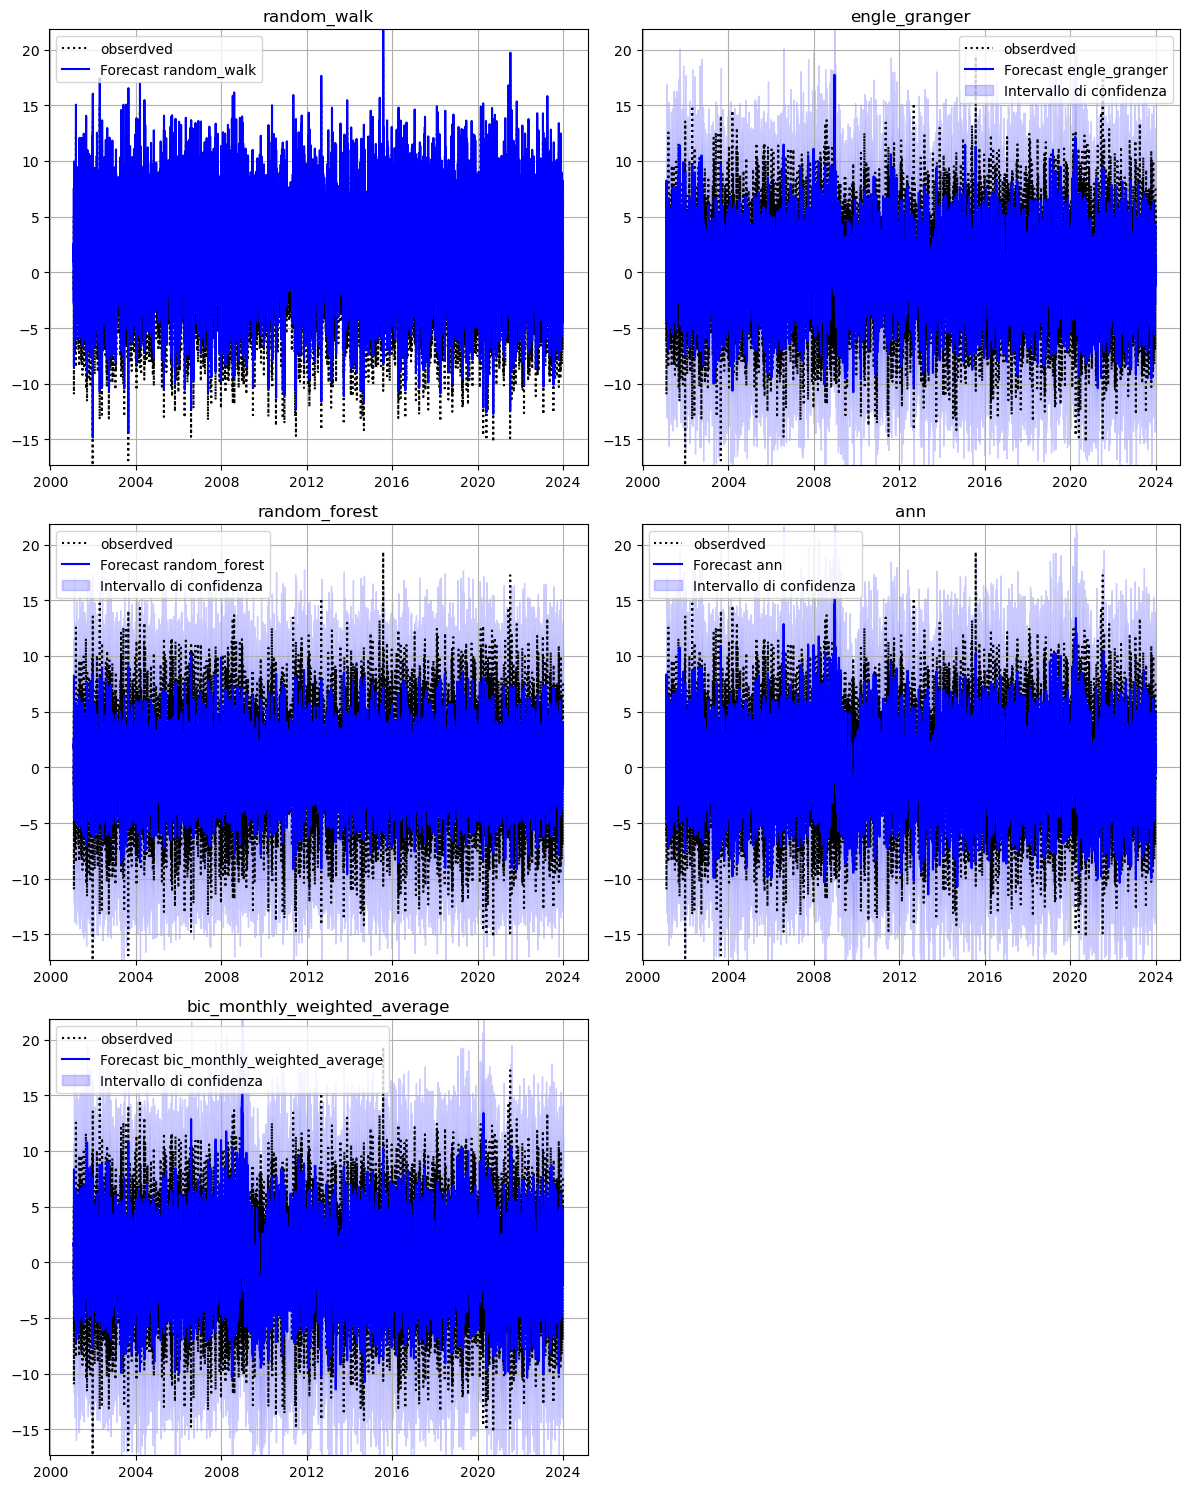

In [168]:
# Supponiamo che all_models_forecast_over_time_synthetic_data_df sia già definito
observed_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]

# Troviamo i valori minimi e massimi per uniformare gli assi Y
y_min = min(observed_returns.min(), min(data["forecast"].min() for data in models_dict.values()))
y_max = max(observed_returns.max(), max(data["forecast"].max() for data in models_dict.values()))

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):
    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot delle osservazioni
    ax.plot(observed_returns, label="obserdved", color='black', linestyle="dotted")

    # Plot del forecast
    ax.plot(data["forecast"], label=f"Forecast {model_name}", color='blue')

    # Se il modello ha intervalli di confidenza, li aggiungiamo
    if "lower_bound" in data and "upper_bound" in data:
        ax.fill_between(data["forecast"].index, data["lower_bound"], data["upper_bound"], 
                        color='blue', alpha=0.2, label="Intervallo di confidenza")

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)

# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


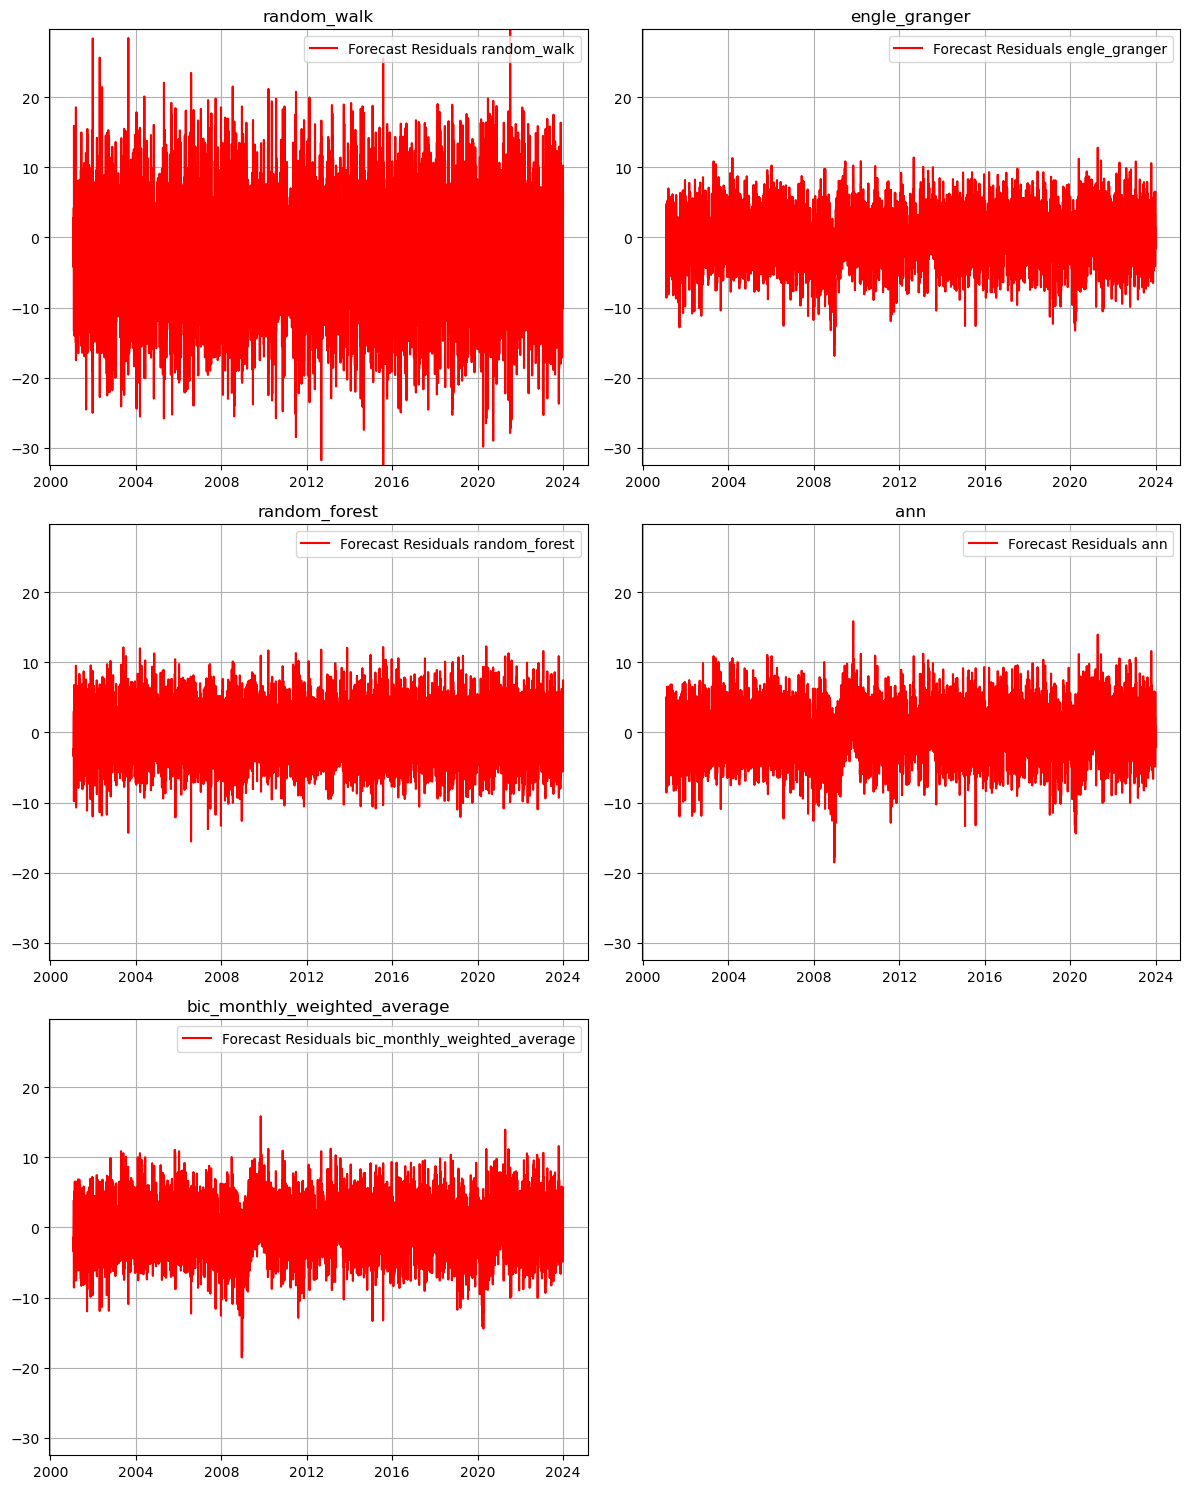

In [169]:
# Supponiamo che all_models_forecast_over_time_synthetic_data_no_svr_df sia già definito
observed_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]

# Troviamo i limiti minimi e massimi per i forecast residuals
y_min = min(data["forecast_residuals"].min() for data in models_dict.values())
y_max = max(data["forecast_residuals"].max() for data in models_dict.values())

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):

    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot dei forecast residuals
    ax.plot(data["forecast_residuals"], label=f"Forecast Residuals {model_name}", color='red')

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)

# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


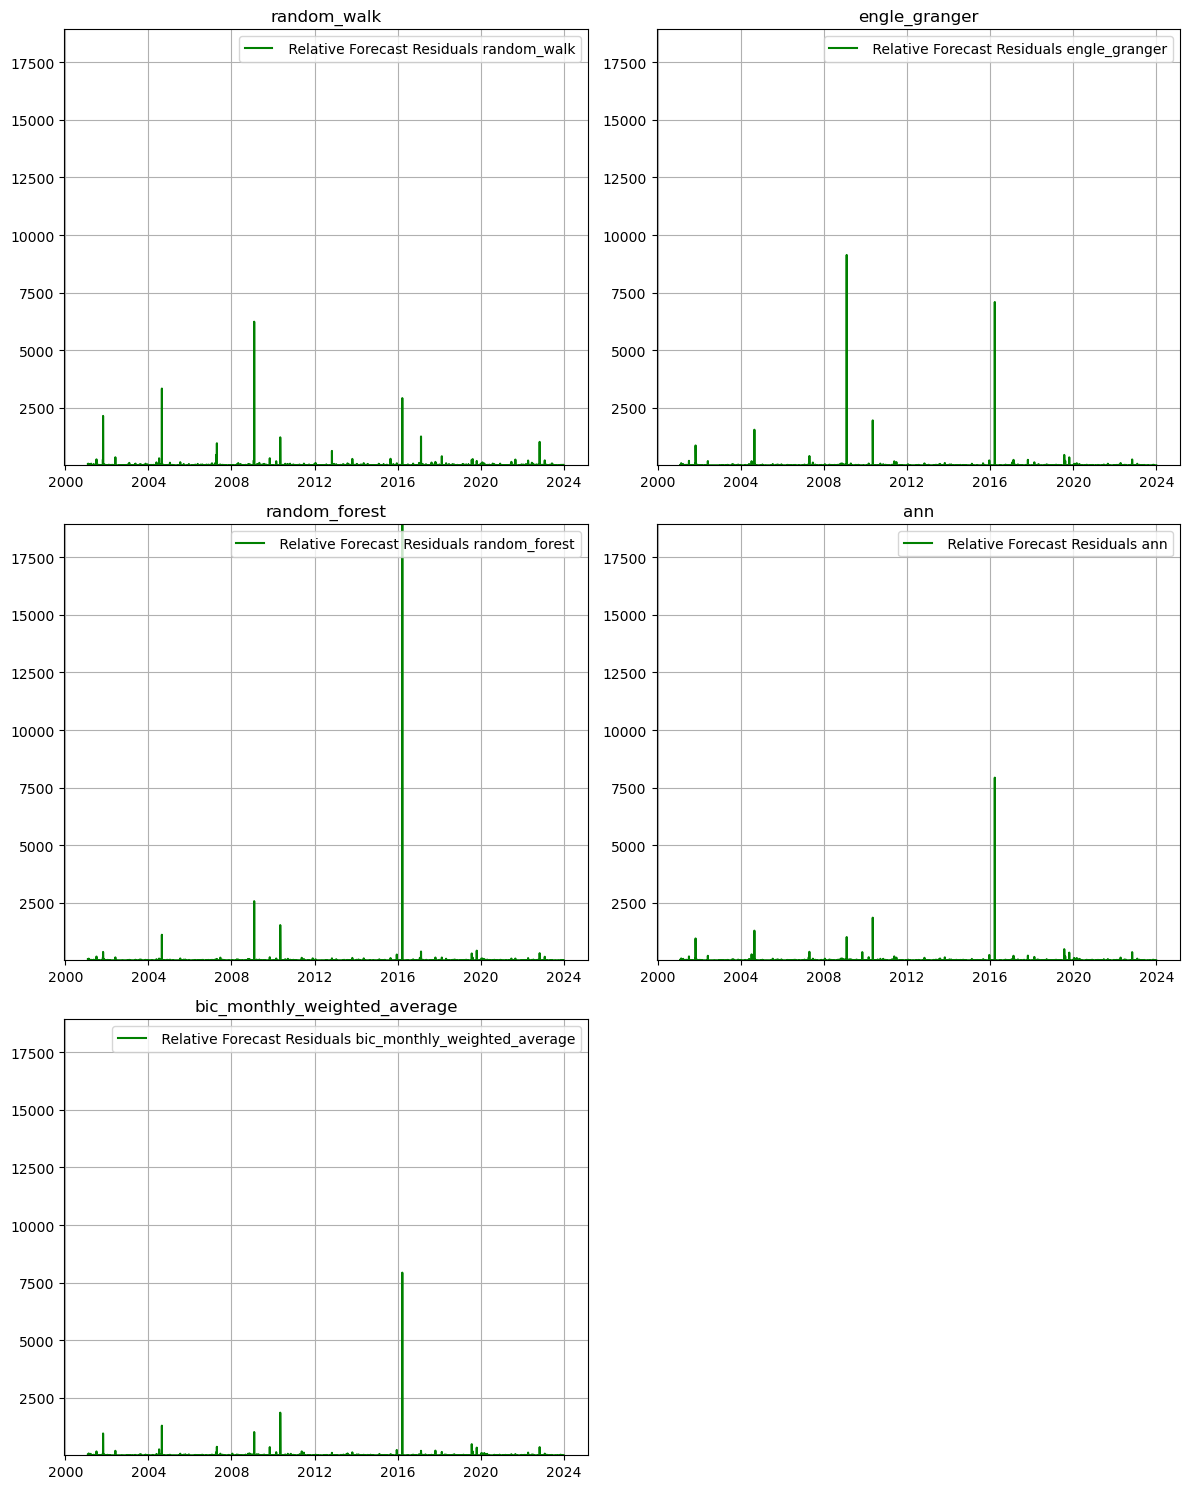

In [170]:
# Supponiamo che all_models_forecast_over_time_synthetic_data_no_svr_df sia già definito
observed_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]

# Troviamo i limiti minimi e massimi per i forecast residuals
y_min = min(data["relative_forecast_residuals"].min() for data in models_dict.values())
y_max = max(data["relative_forecast_residuals"].max() for data in models_dict.values())

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

relative_forecast_residuals_synthetic_data_no_svr_df = pd.DataFrame()

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):

    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot dei forecast residuals
    ax.plot(data["relative_forecast_residuals"], label=f" Relative Forecast Residuals {model_name}", color='g')

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)
    
    relative_forecast_residuals_synthetic_data_no_svr_df[model_name] = data["relative_forecast_residuals"]


# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


In [171]:
relative_forecast_residuals_synthetic_data_no_svr_df.to_csv("relative_forecast_residuals_synthetic_data_no_svr_df.csv", index=False)


In [172]:
relative_forecast_residuals_random_walk = (models_dict["random_walk"]["relative_forecast_residuals"])
print(relative_forecast_residuals_random_walk.idxmax(),relative_forecast_residuals_random_walk.max())

2009-02-03 00:00:00 6234.946659391981


In [173]:
relative_forecast_residuals_engle_granger = (models_dict["engle_granger"]["relative_forecast_residuals"])
print(relative_forecast_residuals_engle_granger.idxmax(),relative_forecast_residuals_engle_granger.max())

2009-02-03 00:00:00 9134.009247477146


In [174]:
relative_forecast_residuals_random_forest = (models_dict["random_forest"]["relative_forecast_residuals"])
print(relative_forecast_residuals_random_forest.idxmax(),relative_forecast_residuals_random_forest.max())

2016-03-22 00:00:00 18933.249137907726


In [175]:
relative_forecast_residuals_ann = (models_dict["ann"]["relative_forecast_residuals"])
print(relative_forecast_residuals_ann.idxmax(),relative_forecast_residuals_ann.max())

2016-03-22 00:00:00 7931.660602352127


In [176]:
relative_forecast_residuals_bic_monthly_weighted_average = (models_dict["bic_monthly_weighted_average"]["relative_forecast_residuals"])
print(relative_forecast_residuals_bic_monthly_weighted_average.idxmax(),relative_forecast_residuals_bic_monthly_weighted_average.max())

2016-03-22 00:00:00 7931.660602352127


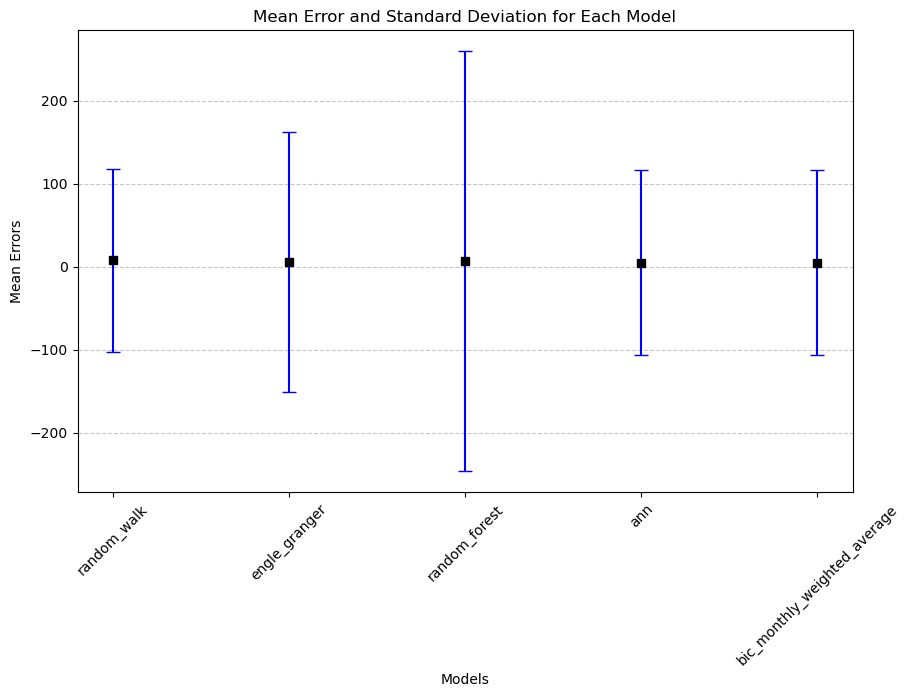

In [177]:
# Standard deviation of relative forecast residuals
results = {}

# Ciclo sui modelli
for model_name, model_data in models_dict.items():
    mean_residuals = np.mean(model_data["relative_forecast_residuals"])
    std_residuals = np.std(model_data["relative_forecast_residuals"])
    results[model_name] = (mean_residuals, std_residuals)

# Estrarre i nomi dei modelli e i valori calcolati
models = list(results.keys())
means = [results[m][0] for m in models]
std_devs = [results[m][1] for m in models]

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.errorbar(models, means, yerr=std_devs, fmt='s', capsize=5, color='black', ecolor='blue')

# Aggiungere etichette e titolo
plt.xlabel("Models")
plt.ylabel("Mean Errors")
plt.title("Mean Error and Standard Deviation for Each Model")
plt.xticks(rotation=45)  # Ruota le etichette per migliore leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.show()


#  Test RMSE for all models

In [178]:
rmse_dict = {}

# Identifica le colonne che contengono i forecast (escludendo intervalli di confidenza)
forecast_columns = [col for col in all_models_forecast_over_time_synthetic_data_no_svr_df.columns if col.startswith("forecast_")]

observed_sp500_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]

# Calcola l'RMSE per ogni modello
for col in forecast_columns:
    y_pred = all_models_forecast_over_time_synthetic_data_no_svr_df[col]  # Valori previsti
    rmse = np.sqrt(np.mean((observed_sp500_returns - y_pred) ** 2))  # RMSE formula
    rmse_dict[col] = rmse  # Salva nel dizionario

rmse_dict

{'forecast_randomwalk': 8.766723832114188,
 'forecast_engle_granger': 3.8331942046414635,
 'forecast_rf': 3.968410441566538,
 'forecast_ann': 3.952243380247982,
 'forecast_ensemble_learning_simple_mean': 3.8032804219823513,
 'forecast_ensemble_learning_weighted_r2': 3.812623617480043,
 'forecast_ensemble_learning_weighted_rmse': 3.802856274045023,
 'forecast_ensemble_learning_weighted_test_rmse': 3.802637883773065,
 'forecast_bic_monthly_best': 3.952243380247982,
 'forecast_aic_monthly_best': 3.952243380247982,
 'forecast_bic_monthly_weighted_average': 3.952243380247982,
 'forecast_aic_monthly_weighted_average': 3.952243380247982,
 'forecast_bic_monthly_weighted_average_converted': 2256.531064409611}

## Metrics Table

In [179]:
# Creazione del DataFrame
rmse_df = pd.DataFrame(list(rmse_dict.items()), columns=["Model", "RMSE"] )
# Imposta la colonna "Model" come indice
rmse_df.set_index("Model", inplace=True)
print(tabulate(rmse_df, headers="keys", tablefmt="plain", stralign="left"))

Model                                                  RMSE
forecast_randomwalk                                 8.76672
forecast_engle_granger                              3.83319
forecast_rf                                         3.96841
forecast_ann                                        3.95224
forecast_ensemble_learning_simple_mean              3.80328
forecast_ensemble_learning_weighted_r2              3.81262
forecast_ensemble_learning_weighted_rmse            3.80286
forecast_ensemble_learning_weighted_test_rmse       3.80264
forecast_bic_monthly_best                           3.95224
forecast_aic_monthly_best                           3.95224
forecast_bic_monthly_weighted_average               3.95224
forecast_aic_monthly_weighted_average               3.95224
forecast_bic_monthly_weighted_average_converted  2256.53


# T-test

In [180]:
# Supponiamo che questi siano i tuoi errori calcolati (sostituiscili con i tuoi dati reali)
errors_dict = {
    "random_walk": models_dict["random_walk"]["forecast_residuals"],
    "engle_granger": models_dict["engle_granger"]["forecast_residuals"],
    "Random_forest": models_dict["random_forest"]["forecast_residuals"],
    "ann": models_dict["ann"]["forecast_residuals"],
    "bic_monthly_weighted_average": models_dict["bic_monthly_weighted_average"]["forecast_residuals"],
    }


# Generiamo tutte le coppie possibili di modelli
model_pairs = list(itertools.combinations(errors_dict.keys(), 2))

# Eseguiamo il test t per ogni coppia
t_test_results = []
for model1, model2 in model_pairs:
    t_stat, p_value = ttest_rel(errors_dict[model1], errors_dict[model2])
    t_test_results.append((model1, model2, t_stat, p_value))



In [181]:
# Creiamo una matrice quadrata inizializzata con NaN
p_value_matrix_forecast_residuals = pd.DataFrame(np.nan, index = errors_dict.keys(), columns = errors_dict.keys())

# Inseriamo i p-value nei punti corretti della matrice (simmetrica)
for model1, model2, t_stat, p_value in t_test_results:
    p_value_matrix_forecast_residuals.loc[model1, model2] = round(p_value, 4)
    p_value_matrix_forecast_residuals.loc[model2, model1] = round(p_value, 4)  # Simmetria

p_value_matrix_forecast_residuals


random_walk  engle_granger  Random_forest  \
random_walk                           NaN         0.0000         0.0000   
engle_granger                         0.0            NaN         0.0005   
Random_forest                         0.0         0.0005            NaN   
ann                                   0.0         0.0000         0.8606   
bic_monthly_weighted_average          0.0         0.0000         0.8606   

                                 ann  bic_monthly_weighted_average  
random_walk                   0.0000                        0.0000  
engle_granger                 0.0000                        0.0000  
Random_forest                 0.8606                        0.8606  
ann                              NaN                           NaN  
bic_monthly_weighted_average     NaN                           NaN

In [182]:
# Errori relativi

relative_errors_dict = {
    "random_walk": models_dict["random_walk"]["relative_forecast_residuals"],
    "engle_granger": models_dict["engle_granger"]["relative_forecast_residuals"],
    "Random_forest": models_dict["random_forest"]["relative_forecast_residuals"],
    "ann": models_dict["ann"]["relative_forecast_residuals"],
    "bic_monthly_weighted_average": models_dict["bic_monthly_weighted_average"]["relative_forecast_residuals"],
    }


# Generiamo tutte le coppie possibili di modelli
model_pairs = list(itertools.combinations(relative_errors_dict.keys(), 2))

# Eseguiamo il test t per ogni coppia
t_test_results_relative_residuals = []
for model1, model2 in model_pairs:
    t_stat, p_value = ttest_rel(relative_errors_dict[model1], relative_errors_dict[model2])
    t_test_results_relative_residuals.append((model1, model2, t_stat, p_value))



In [183]:
# Creiamo una matrice quadrata inizializzata con NaN
p_value_matrix_forecast_relative_residuals = pd.DataFrame(np.nan, index = relative_errors_dict.keys(), columns = relative_errors_dict.keys())

# Inseriamo i p-value nei punti corretti della matrice (simmetrica)
for model1, model2, t_stat, p_value in t_test_results_relative_residuals:
    p_value_matrix_forecast_relative_residuals.loc[model1, model2] = round(p_value, 4)
    p_value_matrix_forecast_relative_residuals.loc[model2, model1] = round(p_value, 4)  # Simmetria

p_value_matrix_forecast_relative_residuals


random_walk  engle_granger  Random_forest  \
random_walk                           NaN         0.0680         0.6323   
engle_granger                      0.0680            NaN         0.8434   
Random_forest                      0.6323         0.8434            NaN   
ann                                0.0282         0.4271         0.4103   
bic_monthly_weighted_average       0.0282         0.4271         0.4103   

                                 ann  bic_monthly_weighted_average  
random_walk                   0.0282                        0.0282  
engle_granger                 0.4271                        0.4271  
Random_forest                 0.4103                        0.4103  
ann                              NaN                           NaN  
bic_monthly_weighted_average     NaN                           NaN

## Weights Table

In [184]:
'''
# Creation of the statistics dictionary for BIC weights
stat_dict_bic = {
    'Engle Granger BIC': {
        'Mean': np.mean(weight_bic_engle_granger_list),
        'Std Dev': np.std(weight_bic_engle_granger_list),
        'Min': np.min(weight_bic_engle_granger_list),
        'Max': np.max(weight_bic_engle_granger_list),
    },
    'Random Forest BIC': {
        'Mean': np.mean(weight_bic_rf_list),
        'Std Dev': np.std(weight_bic_rf_list),
        'Min': np.min(weight_bic_rf_list),
        'Max': np.max(weight_bic_rf_list),
    },
    'SVR BIC': {
        'Mean': np.mean(weight_bic_svr_list),
        'Std Dev': np.std(weight_bic_svr_list),
        'Min': np.min(weight_bic_svr_list),
        'Max': np.max(weight_bic_svr_list),
    },
    'ANN BIC': {
        'Mean': np.mean(weight_bic_ann_list),
        'Std Dev': np.std(weight_bic_ann_list),
        'Min': np.min(weight_bic_ann_list),
        'Max': np.max(weight_bic_ann_list),
    }
}

# Creation of the statistics dictionary for AIC weights
stat_dict_aic = {
    'Engle Granger AIC': {
        'Mean': np.mean(weight_aic_engle_granger_list),
        'Std Dev': np.std(weight_aic_engle_granger_list),
        'Min': np.min(weight_aic_engle_granger_list),
        'Max': np.max(weight_aic_engle_granger_list),
    },
    'Random Forest AIC': {
        'Mean': np.mean(weight_aic_rf_list),
        'Std Dev': np.std(weight_aic_rf_list),
        'Min': np.min(weight_aic_rf_list),
        'Max': np.max(weight_aic_rf_list),
    },
    'SVR AIC': {
        'Mean': np.mean(weight_aic_svr_list),
        'Std Dev': np.std(weight_aic_svr_list),
        'Min': np.min(weight_aic_svr_list),
        'Max': np.max(weight_aic_svr_list),
    },
    'ANN AIC': {
        'Mean': np.mean(weight_aic_ann_list),
        'Std Dev': np.std(weight_aic_ann_list),
        'Min': np.min(weight_aic_ann_list),
        'Max': np.max(weight_aic_ann_list),
    }
}

# Creation of DataFrames from the statistics dictionaries
stat_df_bic = pd.DataFrame(stat_dict_bic).T  # Transpose to have models as rows and statistics as columns
stat_df_aic = pd.DataFrame(stat_dict_aic).T
stat_df = pd.concat([stat_df_bic, stat_df_aic], axis=0)
print(stat_df)
'''

"\n# Creation of the statistics dictionary for BIC weights\nstat_dict_bic = {\n    'Engle Granger BIC': {\n        'Mean': np.mean(weight_bic_engle_granger_list),\n        'Std Dev': np.std(weight_bic_engle_granger_list),\n        'Min': np.min(weight_bic_engle_granger_list),\n        'Max': np.max(weight_bic_engle_granger_list),\n    },\n    'Random Forest BIC': {\n        'Mean': np.mean(weight_bic_rf_list),\n        'Std Dev': np.std(weight_bic_rf_list),\n        'Min': np.min(weight_bic_rf_list),\n        'Max': np.max(weight_bic_rf_list),\n    },\n    'SVR BIC': {\n        'Mean': np.mean(weight_bic_svr_list),\n        'Std Dev': np.std(weight_bic_svr_list),\n        'Min': np.min(weight_bic_svr_list),\n        'Max': np.max(weight_bic_svr_list),\n    },\n    'ANN BIC': {\n        'Mean': np.mean(weight_bic_ann_list),\n        'Std Dev': np.std(weight_bic_ann_list),\n        'Min': np.min(weight_bic_ann_list),\n        'Max': np.max(weight_bic_ann_list),\n    }\n}\n\n# Creation of

# Weights plots

In [185]:
models_weights_over_time_synthetic_data_no_svr_df.head()

ann  return_sp_500
2001-02-01  1.0       0.065081
2001-02-02  1.0      -1.673084
2001-02-05  1.0       5.058399
2001-02-06  1.0      -0.108983
2001-02-07  1.0     -10.951482

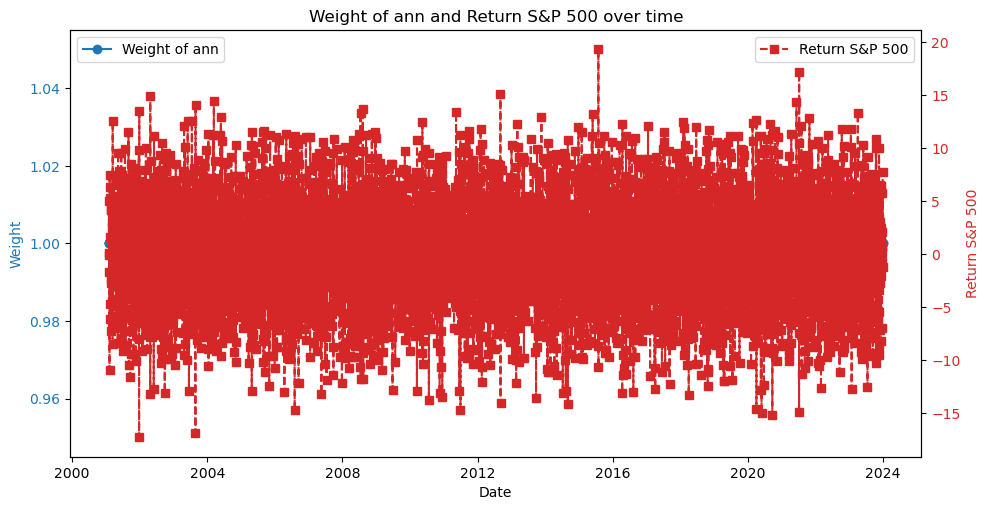

In [186]:
# Creiamo i grafici
for model_name in models_weights_over_time_synthetic_data_no_svr_df.columns[:-1]:  # Escludiamo la colonna 'return_sp_500'
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weight', color='tab:blue')
    ax1.plot(models_weights_over_time_synthetic_data_no_svr_df.index, models_weights_over_time_synthetic_data_no_svr_df[model_name], marker='o', linestyle='-', color='tab:blue', label=f'Weight of {model_name}')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Return S&P 500', color='tab:red')
    ax2.plot(models_weights_over_time_synthetic_data_no_svr_df.index, models_weights_over_time_synthetic_data_no_svr_df['return_sp_500'], marker='s', linestyle='dashed', color='tab:red', label='Return S&P 500')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    plt.title(f'Weight of {model_name} and Return S&P 500 over time')
    plt.savefig(f'plots/Weight_of_{model_name}_and_Return_S&P_500_over_time.svg', format='svg')

    plt.show()

## P-Values ADF TEST

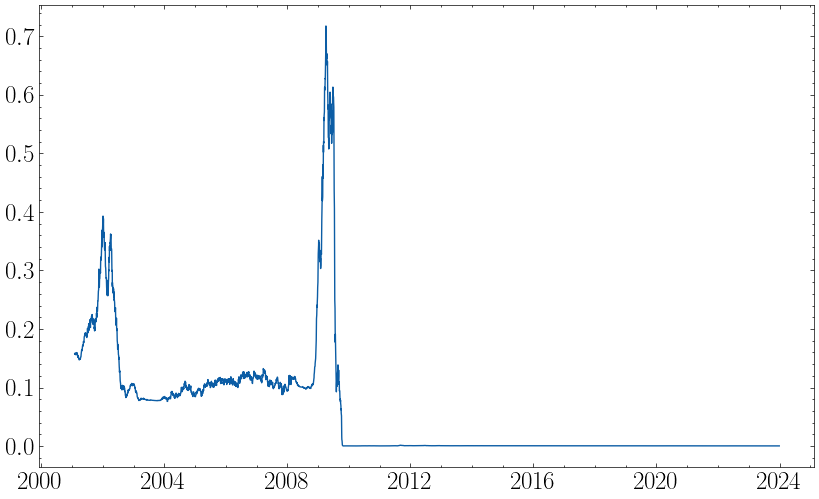

In [189]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    plt.plot(date_list, adf_output_list, label='ADF Test for residuals_Step1')
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    #plt.savefig('grafici/ADF_Test_for_residuals_Step1.svg', format='svg')

    plt.show()

## Coefficients of eps(t-1)

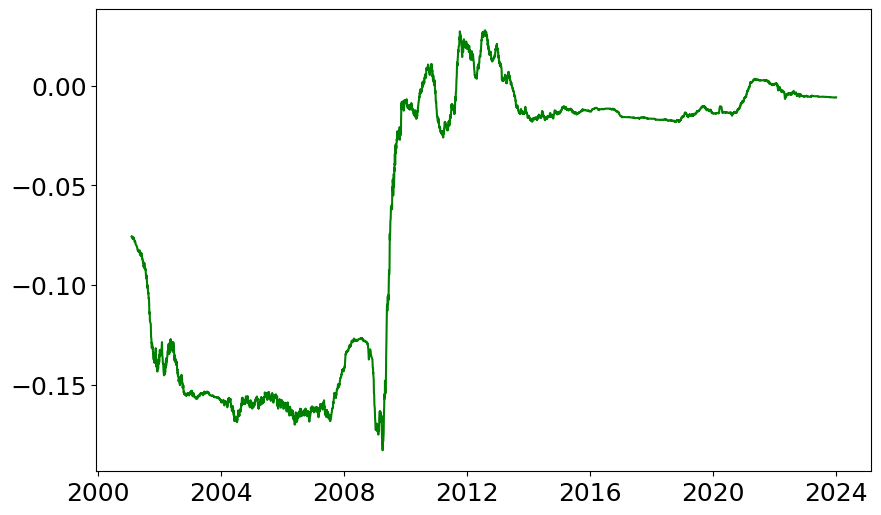

In [201]:

plt.figure(figsize=(10, 6))
plt.plot(date_list, coefficients_of_eps_t_1__step2_list, label='Coefficients of eps(t-1)', color='green')
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)
plt.grid(False)
#plt.savefig('grafici/Coefficients_of_eps(t-1).svg', format='svg')

plt.show()

## Rsquared_Step2

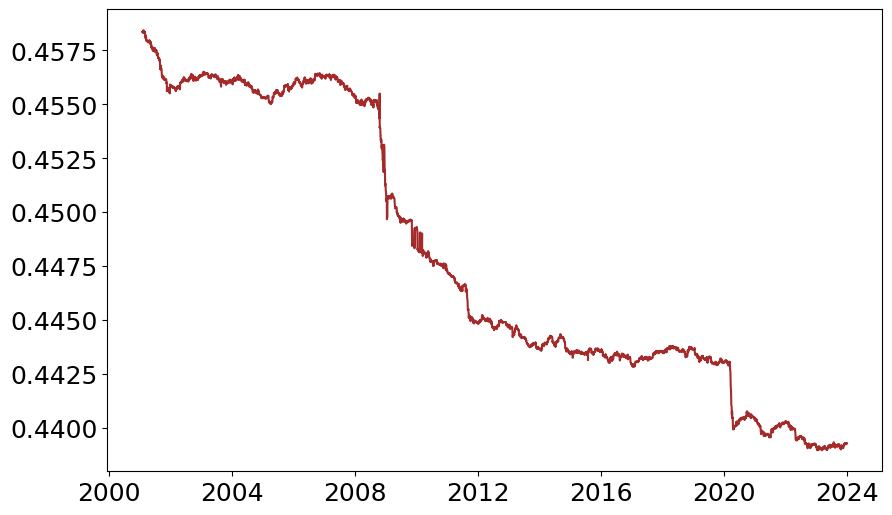

In [202]:
plt.figure(figsize=(10, 6))
plt.plot(date_list, rsquared_step2_list, label='Rsquared Step2', color='brown')
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)
plt.grid(False)
#plt.savefig('grafici/Rsquared_Step2.svg', format='svg')

plt.show()

# Hit Ratio

In [197]:
all_models_forecast_over_time_synthetic_data_no_svr_df.head()

observed_sp500_returns  forecast_randomwalk  \
2001-02-01                0.065081            -2.717320   
2001-02-02               -1.673084             2.565117   
2001-02-05                5.058399             0.826875   
2001-02-06               -0.108983             7.558357   
2001-02-07              -10.951482             2.390889   

            forecast_engle_granger  lower_bound_engle_granger  \
2001-02-01                1.206924                  -7.436898   
2001-02-02                1.132390                  -7.511158   
2001-02-05                2.637251                  -6.006167   
2001-02-06               -2.553330                 -11.196574   
2001-02-07               -2.372198                 -11.015272   

            upper_bound_engle_granger  forecast_rf  lower_bound_rf  \
2001-02-01                   9.850746     2.474166       -6.617069   
2001-02-02                   9.775938     1.729827       -7.361090   
2001-02-05                  11.280670     2.046671       -7.044391   
2001-02-06                   6.089915    -3.071525      -12.162623   
2001-02-07                   6.270875    -1.160595      -10.251466   

            upper_bound_rf  forecast_ann  lower_bound_ann  ...  \
2001-02-01       11.565400      1.501398        -7.339180  ...   
2001-02-02       10.820743      1.784897        -7.053576  ...   
2001-02-05       11.137733      1.172374        -7.663680  ...   
2001-02-06        6.019573     -2.881974       -11.717859  ...   
2001-02-07        7.930276     -2.384071       -11.230129  ...   

            upper_bound_bic_weighted_average  \
2001-02-01                         10.341976   
2001-02-02                         10.623370   
2001-02-05                         10.008429   
2001-02-06                          5.953910   
2001-02-07                          6.461987   

            forecast_aic_monthly_weighted_average  \
2001-02-01                               1.501398   
2001-02-02                               1.784897   
2001-02-05                               1.172374   
2001-02-06                              -2.881974   
2001-02-07                              -2.384071   

            lower_bound_aic_monthly_weighted_average  \
2001-02-01                                 -7.339180   
2001-02-02                                 -7.053576   
2001-02-05                                 -7.663680   
2001-02-06                                -11.717859   
2001-02-07                                -11.230129   

            upper_bound_aic_monthly_weighted_average  \
2001-02-01                                 10.341976   
2001-02-02                                 10.623370   
2001-02-05                                 10.008429   
2001-02-06                                  5.953910   
2001-02-07                                  6.461987   

            forecast_bic_monthly_weighted_average_converted  \
2001-02-01                                      1341.982773   
2001-02-02                                      1346.668818   
2001-02-05                                      1316.238356   
2001-02-06                                      1329.520612   
2001-02-07                                      1334.701462   

            lower_bound_bic_weighted_average_converted  \
2001-02-01                                 1223.343739   
2001-02-02                                 1227.643857   
2001-02-05                                 1199.934813   
2001-02-06                                 1212.045710   
2001-02-07                                 1216.633000   

            upper_bound_bic_weighted_average_converted  adf_output  \
2001-02-01                                 1460.621806    0.157426   
2001-02-02                                 1465.693780    0.157461   
2001-02-05                                 1432.541900    0.156969   
2001-02-06                                 1446.995513    0.158181   
2001-02-07                                 1452.769923    0.159042   

            rsqua

In [198]:
def binarize_returns(returns):
    
    binarized_returns_list = []
    
    for value in returns:
        
        if value >= 0:
            
            value = 1
            
        else:
            
            value = 0
            
        binarized_returns_list.append(value)
        
    returns = pd.Series(binarized_returns_list, index=returns.index)
     
    return returns       

In [204]:
observed_sp500_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]
observed_sp500_returns.head(10)

2001-02-01     0.065081
2001-02-02    -1.673084
2001-02-05     5.058399
2001-02-06    -0.108983
2001-02-07   -10.951482
2001-02-08     7.455684
2001-02-09     5.306734
2001-02-12    -6.169559
2001-02-13     1.606916
2001-02-14    -4.680079
Name: observed_sp500_returns, dtype: float64

In [205]:
binarize_returns (observed_sp500_returns).head(10)

2001-02-01    1
2001-02-02    0
2001-02-05    1
2001-02-06    0
2001-02-07    0
2001-02-08    1
2001-02-09    1
2001-02-12    0
2001-02-13    1
2001-02-14    0
dtype: int64

In [206]:
# Binarized Dataframe creation
for colonna in all_models_forecast_over_time_synthetic_data_no_svr_df.columns:
    
    if colonna == "observed_sp500_returns":
        binarized_observed_sp500_returns = binarize_returns(all_models_forecast_over_time_synthetic_data_no_svr_df[colonna])
        df_binarized = pd.DataFrame(index=all_models_forecast_over_time_synthetic_data_no_svr_df.index)
        df_binarized[colonna] = binarized_observed_sp500_returns
    
    elif colonna.startswith("forecast_"):
        binarized_forecast = binarize_returns(all_models_forecast_over_time_synthetic_data_no_svr_df[colonna])
        df_binarized[colonna] = binarized_forecast
  
df_binarized.head(10)  
    
hit_ratio_df = pd.DataFrame(columns = ["hit_ratio_percent"] , index = df_binarized.columns[1:])


    
df_binarized.head()

observed_sp500_returns  forecast_randomwalk  \
2001-02-01                       1                    0   
2001-02-02                       0                    1   
2001-02-05                       1                    1   
2001-02-06                       0                    1   
2001-02-07                       0                    1   

            forecast_engle_granger  forecast_rf  forecast_ann  \
2001-02-01                       1            1             1   
2001-02-02                       1            1             1   
2001-02-05                       1            1             1   
2001-02-06                       0            0             0   
2001-02-07                       0            0             0   

            forecast_ensemble_learning_simple_mean  \
2001-02-01                                       1   
2001-02-02                                       1   
2001-02-05                                       1   
2001-02-06                                       0   
2001-02-07                                       0   

            forecast_ensemble_learning_weighted_r2  \
2001-02-01                                       1   
2001-02-02                                       1   
2001-02-05                                       1   
2001-02-06                                       0   
2001-02-07                                       0   

            forecast_ensemble_learning_weighted_rmse  \
2001-02-01                                         1   
2001-02-02                                         1   
2001-02-05                                         1   
2001-02-06                                         0   
2001-02-07                                         0   

            forecast_ensemble_learning_weighted_test_rmse  \
2001-02-01                                              1   
2001-02-02                                              1   
2001-02-05                                              1   
2001-02-06                                              0   
2001-02-07                                              0   

            forecast_bic_monthly_best  forecast_aic_monthly_best  \
2001-02-01                          1                          1   
2001-02-02                          1                          1   
2001-02-05                          1                          1   
2001-02-06                          0                          0   
2001-02-07                          0                          0   

            forecast_bic_monthly_weighted_average  \
2001-02-01                                      1   
2001-02-02                                      1   
2001-02-05                                      1   
2001-02-06                                      0   
2001-02-07                                      0   

            forecast_aic_monthly_weighted_average  \
2001-02-01                                      1   
2001-02-02                                      1   
2001-02-05                                      1   
2001-02-06                                      0   
2001-02-07                                      0   

            forecast_bic_monthly_weighted_average_converted  
2001-02-01                                                1  
2001-02-02                                                1  
2001-02-05                                                1  
2001-02-06                                                1  
2001-02-07                                                1

In [207]:
for column in df_binarized.columns:
    
    if column == "observed_sp500_returns":
        continue
    
    comparison = df_binarized[column] == df_binarized["observed_sp500_returns"]
    num_hit_ratio = 0
    
    for value in comparison:
        if value == True:
            num_hit_ratio += 1
            
    hit_ratio = num_hit_ratio / len(comparison) * 100
    hit_ratio_df.loc[column] = hit_ratio

In [208]:
hit_ratio_df

hit_ratio_percent
forecast_randomwalk                                     35.357391
forecast_engle_granger                                   72.58848
forecast_rf                                             69.552394
forecast_ann                                            71.634282
forecast_ensemble_learning_simple_mean                  72.276197
forecast_ensemble_learning_weighted_r2                  72.501735
forecast_ensemble_learning_weighted_rmse                72.310895
forecast_ensemble_learning_weighted_test_rmse           72.328244
forecast_bic_monthly_best                               71.634282
forecast_aic_monthly_best                               71.634282
forecast_bic_monthly_weighted_average                   71.634282
forecast_aic_monthly_weighted_average                   71.634282
forecast_bic_monthly_weighted_average_converted         49.514226